In [1]:
"""
*****************************************************************************
                                   Notebook Only Imports
*****************************************************************************
"""
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker
from IPython.display import clear_output
from src.Dn4000Grad import *
import warnings

# Suppresses Warnings
warnings.filterwarnings('ignore')

In [2]:
"""
*****************************************************************************
                                   Matplotlib settings
*****************************************************************************
"""
plt.style.use('classic')
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\boldmath']
font = {'family' : 'Times New Roman',
    'weight' : 'normal',
    'size'   : 25}

plt.rc('font', **font)

plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['xtick.minor.size'] = 8
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['ytick.minor.size'] = 8
plt.rcParams['ytick.minor.width'] = 2
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)


plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['xtick.minor.size'] = 8
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['ytick.minor.size'] = 8
plt.rcParams['ytick.minor.width'] = 2
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

plt.rcParams['savefig.facecolor']='white'

In [3]:
"""
*****************************************************************************
                                   Parameters
*****************************************************************************
"""
# Constants
#============================================================================
INT_MAX = 10000

# Settings
#============================================================================
showProgressBars = True                                       # Show the progress of tasks
generateCompletenessPlots = False                             # Plot completeness plot as a function of r-band mag
generateDnHist1D = False                                      #
generateDnHist2D = False                                      #
generateKDEPlots = False                                      #
generateDnWithCorrectionHist2D = False                        #
generateMaguntudeLimitPlot = False                            #

# Dn4000 Constraints
#============================================================================
Dn4000Max = 3.0                                               #
Dn4000Min = 0.0                                               #

# Cluster List
#============================================================================
fullClusterList = fits.clusters                               # List of all clusters in the dataset
clustersToIgnore = ["SDSSCGA0782"]                            # List of cluster to exclude for the analysis

# File Directories
#============================================================================
spectroscopicMemberDataFileDir = "./data/HeCS_omnibus_dn4000.fits" # File path for spectrospoic members dataset
clusterObjectData3r200FileDir = "./data/HeCS_omnibus_3r200.fits"   # File path for all object within 3R200 of the cluster center
clusterDataFileDir = "./data/HeCS_omnibus_prop.txt"                # File path for infomation about the overall cluster i.e R200, M200 and redshift

# Completeness/Membership fraction calculations
#============================================================================
rbandBinSize = 1.0                                            # Rband apparent magnitude Bin Size in Mpc
completenessLimit = 0.5                                       # Completeness limit to calculate/use in the program (between 0.0-1.0) i.e. 0.5 = 50% completeness limit
rbandMax = 100                                                # Max r-band value for calculating the completeness limt
rbandMin = 15                                                 # Min r-band value for calculating the completeness limt

# Membership correction parameter
#============================================================================

# General
#----------------------------------------------------------------------------
imposeLimitOnCorrection = True                                #

# Bin Sizes
#----------------------------------------------------------------------------
rnormBinSize = 0.25                                           # Rnorm (Rcl / R200) Bin Size
MrBinSize = 0.8                                               # Abs. R-Band Magnitude Bin Size
grBinSize = 0.25                                              # g-r Color Bin Size

# Bin Constraints (Value of None the max/min values in dataset will be taken)
#----------------------------------------------------------------------------
rnormMax = None                                               # Max Rnorm (Rcl / R200) Value
rnormMin = None                                               # Min Rnorm (Rcl / R200) Value

MrMax = -20.625824886161126                                   # Max Abs. R-Band Magnitude Value
MrMin = -22.0                                                 # Min Abs. R-Band Magnitude Value FOr Correction bins 
                                                              # All objects with Mr < -22 are grouped in the same correction bin
    
grMax = 1.4                                                   # Max g-r Color Value
grMin = 0.65                                                  # Min g-r Color Value

# KDE Parameters
#----------------------------------------------------------------------------
dn4000Binwidth = 0.1                                          #
rNormBinwidth = 0.15                                          #
showOptimalBandwidth = False                                  #

# Maguntude Limit Calculation parameter
#============================================================================
redshiftBinMin = None
redshiftBinMax = None 
redshiftBinNum = 10

massBinMin = None
massBinMax = None #1842480000000000.0
massBinNum = 4

# Global variables
#============================================================================
clusterDict = None
clusterDictSpec = None
centerData = None
clusterList = None
sampleUsing = None

In [4]:
"""
*****************************************************************************
                              Finds Magnitude Limit
*****************************************************************************
"""
# Analysis for full Cluster List to get Mag Limit data
init()
lumDistDict = getLumDistDict()
memberClusterDict = genMemberDict(lumDistDict)
completnessDict, memberfractionDict = CalcCompletness() 
limit50, completenessPlotData = getCompletenessLimit(completnessDict, useAbsMag=False)
additionalMembersDict, additionalMembersLimitDict, binStats = getAdditionalMemberDict(memberClusterDict, lumDistDict, limit50)
sampledData, correctionDistPlotData, correctionDistRowName, correctionDistColName = sampleAdditionalMembers(memberClusterDict, additionalMembersLimitDict) if(imposeLimitOnCorrection) else sampleAdditionalMembers(memberClusterDict, additionalMembersDict)
plotDataDict = assignAdditionalMembers(memberClusterDict, additionalMembersLimitDict, sampledData) if(imposeLimitOnCorrection) else assignAdditionalMembers(memberClusterDict, additionalMembersDict, sampledData)

MrLimit, magLimitPlotData = magnitudeLimit(plotDataDict, completnessDict)

100%|█████████████████████████████████████████████|Generating Member Dictionary
100%|████████████|Calculating Completeness and Member Fraction for Each Cluster
100%|██████████████████████|Calculating the Completeness Limit for Each Cluster
100%|███████████████████████████████████████|Getting Stacked Sampled Parameters
100%|██████████████████████|Calculating the Completeness Limit for Each Cluster
100%|█████████████████████████████████████████████|Preparing The Stacked Sample


In [5]:
"""
*****************************************************************************
                       START OF DATA PROCESSING
                            Initialization
*****************************************************************************
"""
init(sample = "redshiftSampleComplete")

In [6]:
"""
*****************************************************************************
        Generates Member Dictionary And Calculates Completness Limits
*****************************************************************************
"""
lumDistDict = getLumDistDict()
memberClusterDict = genMemberDict(lumDistDict)
completnessDict, memberfractionDict = CalcCompletness() 
limit50, completenessPlotData = getCompletenessLimit(completnessDict, useAbsMag=False)

100%|█████████████████████████████████████████████|Generating Member Dictionary
100%|████████████|Calculating Completeness and Member Fraction for Each Cluster
100%|██████████████████████|Calculating the Completeness Limit for Each Cluster


In [7]:
"""
*****************************************************************************
                                    Binning
*****************************************************************************
"""
q, binningPlotData = getBinning(completnessDict, binType = 'equal')

100%|██████████████████████|Calculating the Completeness Limit for Each Cluster


In [8]:
"""
*****************************************************************************
                              Applies The Corrrection
*****************************************************************************
"""
additionalMembersDict, additionalMembersLimitDict, binStats = getAdditionalMemberDict(memberClusterDict, lumDistDict, limit50)
sampledData, correctionDistPlotData, correctionDistRowName, correctionDistColName = sampleAdditionalMembers(memberClusterDict, additionalMembersLimitDict) if(imposeLimitOnCorrection) else sampleAdditionalMembers(memberClusterDict, additionalMembersDict)
plotDataDict = assignAdditionalMembers(memberClusterDict, additionalMembersLimitDict, sampledData) if(imposeLimitOnCorrection) else assignAdditionalMembers(memberClusterDict, additionalMembersDict, sampledData)

100%|███████████████████████████████████████|Getting Stacked Sampled Parameters


In [9]:
"""
*****************************************************************************
                              Dn4000 Trend
*****************************************************************************
"""
slope, serr, intercept, ierr, dn4000RowName, dn4000ColName, dn4000PlotData = generateDn4000vsRnormPlots(plotDataDict, completnessDict, errorMethod = "std", xproj = 'Rnorm', dataIndex = 1)

100%|██████████████████████|Calculating the Completeness Limit for Each Cluster


In [10]:
"""
*****************************************************************************
                              Simulate Dn4000 Trend
*****************************************************************************
"""

count = 0
slopes, serr, intercepts, ierr, rowName, colName = [], [], [], [], [], []

class Worker(Thread):
    def __init__(self, length, xproj, numTotalRuns):
        super(Worker, self).__init__()
        self.length = length
        self.xproj = xproj
        self.numTotalRuns = numTotalRuns
        self.total=0

    def run(self):
        global count
        global slopes
        global serr
        global intercepts
        global ierr
        global rowName
        global colName

        for _ in range(self.length):
            sampledData, _, _, _ = sampleAdditionalMembers(memberClusterDict, additionalMembersLimitDict) if(imposeLimitOnCorrection) else sampleAdditionalMembers(memberClusterDict, additionalMembersDict)
            plotDataDict = assignAdditionalMembers(memberClusterDict, additionalMembersLimitDict, sampledData) if(imposeLimitOnCorrection) else assignAdditionalMembers(memberClusterDict, additionalMembersDict, sampledData)
            _slopes, _serr, _intercepts, _ierr, _rowName, _colName, __ = generateDn4000vsRnormPlots(plotDataDict, completnessDict, errorMethod = "std", xproj = self.xproj)

            slopes.append(_slopes)
            serr.append(_serr)
            intercepts.append(_intercepts)
            ierr.append(_ierr)
            rowName = _rowName
            colName = _colName
            count += 1

            clear_output(wait=True)
            print(str(count) + " / " + str(self.numTotalRuns), flush=True)
            
def simulate(completnessDict, xproj = 'Rnorm', numThreads = 10, numRuns = 500):   
    global count
    count = 0
    num_threads = numThreads
    num_runs = numRuns

    lock = Lock()
    threads = [Worker(int(np.ceil(num_runs / num_threads)), xproj, numRuns) for i in range(num_threads)]
    for thread in threads:
        thread.start()
        thread.join()

# Rcl/R200 simulation
simulate(completnessDict, xproj = 'Rnorm', numThreads = 10, numRuns = 500)
slopesRnorm, serrsRnorm, interceptsRnorm, ierrsRnorm, rowNameRnorm, colNameRnorm = slopes, serr, intercepts, ierr, rowName, colName
slopes_newRnorm, iqrsRnorm, errsRnorm, intercepts_newRnorm, iqriRnorm, erriRnorm = processFitResult(slopesRnorm, serrsRnorm, interceptsRnorm, ierrsRnorm)

# Resets result container
slopes, serr, intercepts, ierr, rowName, colName = [], [], [], [], [], []

# Log_10 Infall Time simulation
simulate(completnessDict, xproj = 'LogInfallTime', numThreads = 10, numRuns = 500)
slopesLogInfallTime, serrsLogInfallTime, interceptsLogInfallTime, ierrsLogInfallTime, rowNameLogInfallTime, colNameLogInfallTime = slopes, serr, intercepts, ierr, rowName, colName 
slopes_newLogInfallTime, iqrsLogInfallTime, errsLogInfallTime, intercepts_newLogInfallTime, iqriLogInfallTime, erriLogInfallTime = processFitResult(slopesLogInfallTime, serrsLogInfallTime, interceptsLogInfallTime, ierrsLogInfallTime)

10 / 10


In [11]:
"""
*****************************************************************************
                              Dv Plots
*****************************************************************************
"""
dVplotData1 = generateRelativeVelocityPlots(plotDataDict, 0.0, 0.11, 1e14, 1e15, useCorrection = True, useMagLimit = True)
dVplotData2 = generateRelativeVelocityPlots(plotDataDict, 0.11, 0.20, 1e14, 1e15, useCorrection = True, useMagLimit = True)
dVplotData3 = generateRelativeVelocityPlots(plotDataDict, 0.20, 0.30, 1e14, 1e15, useCorrection = True, useMagLimit = True)

100%|██████████████████████|Calculating the Completeness Limit for Each Cluster


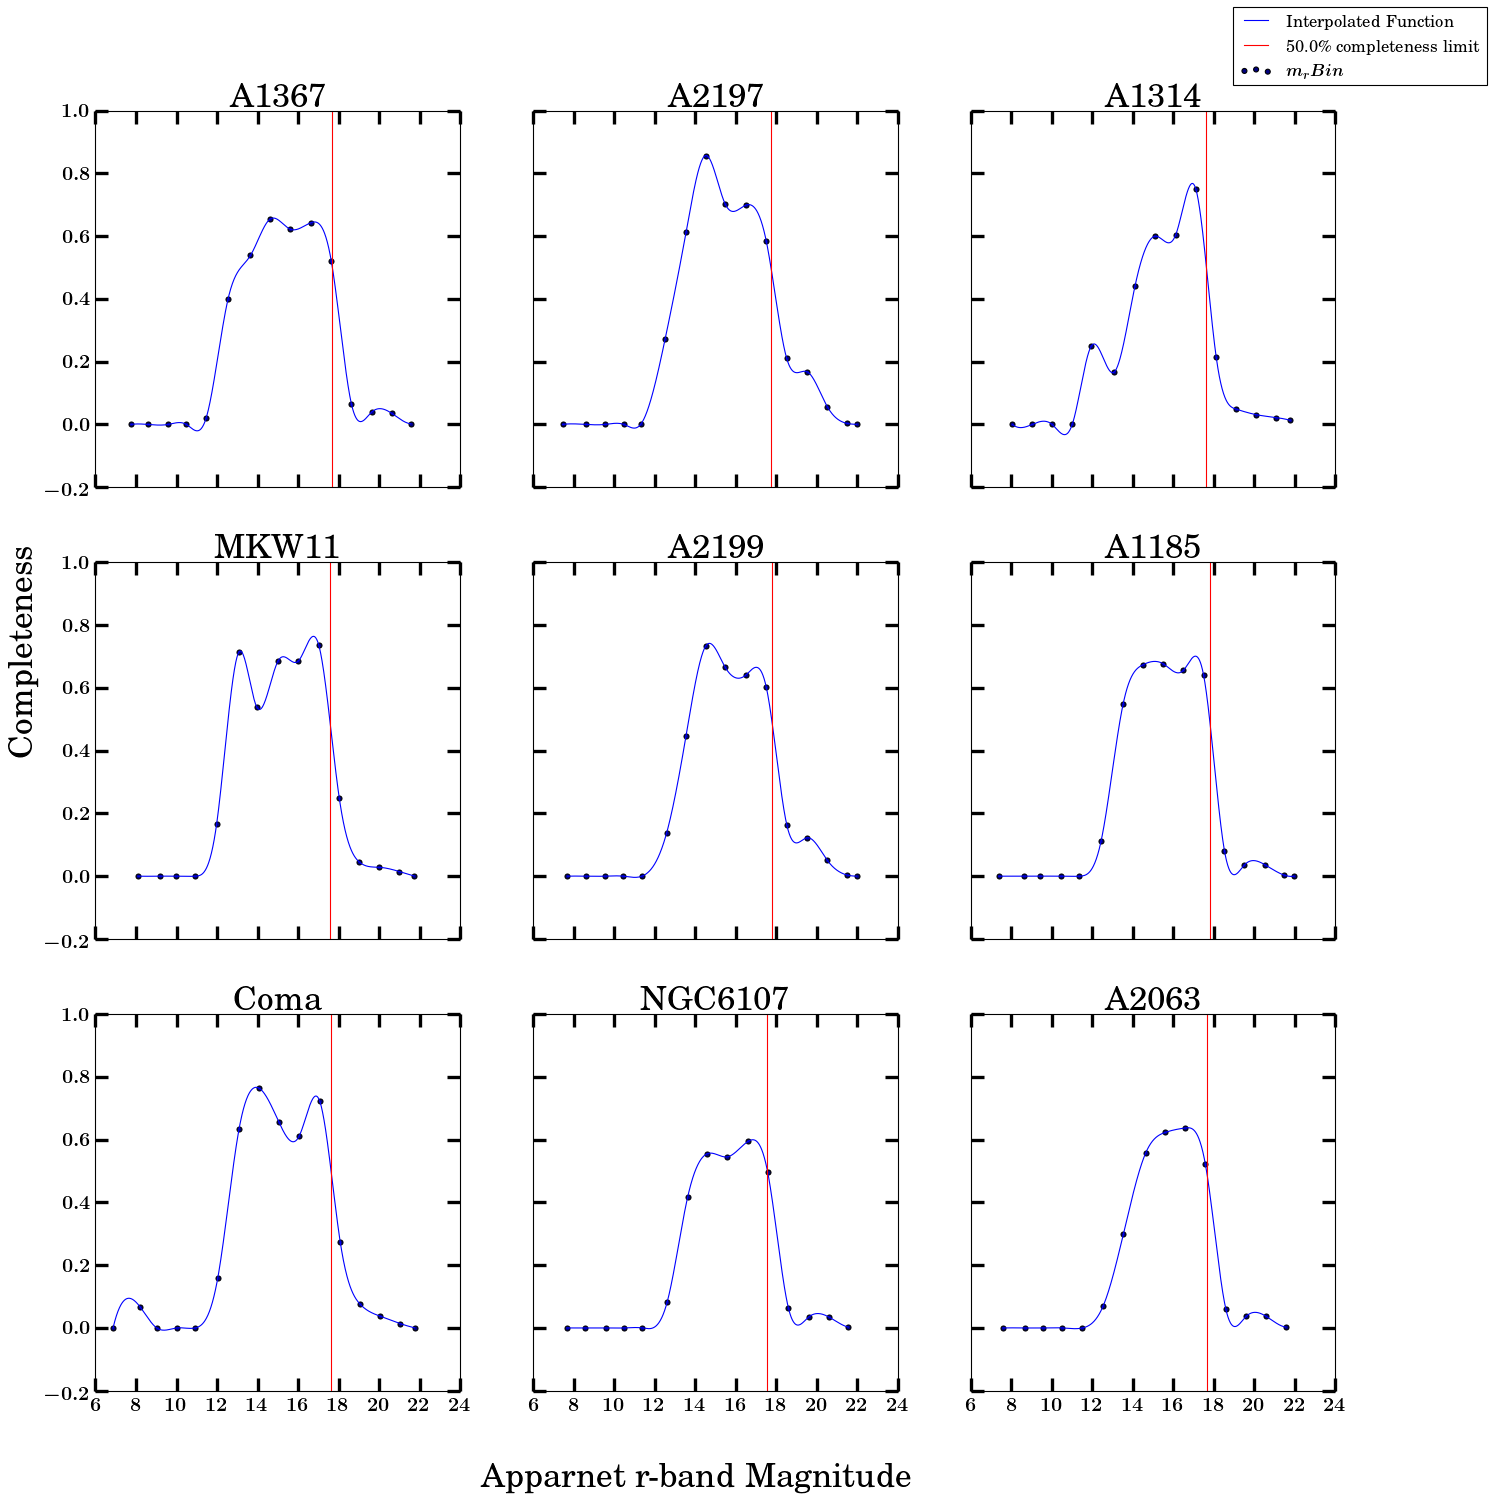

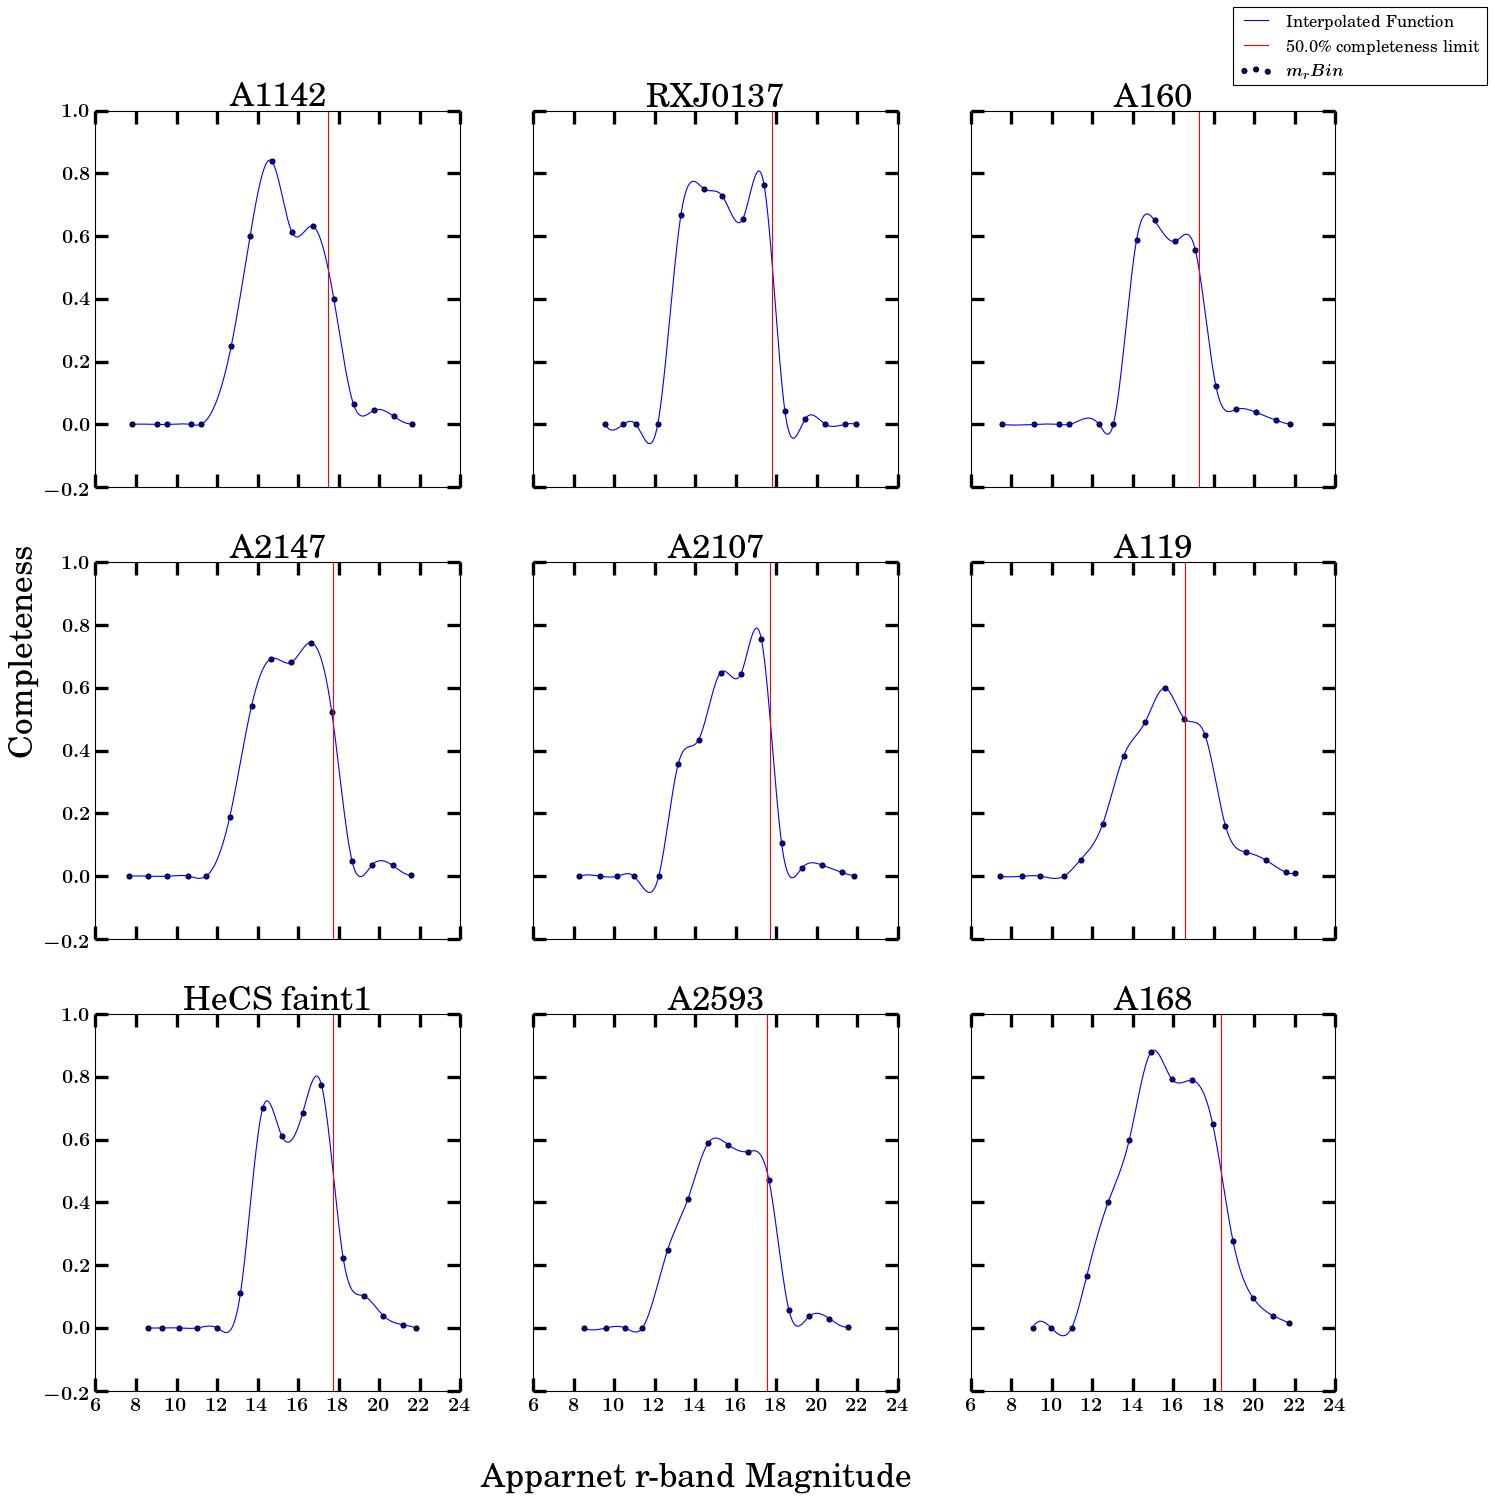

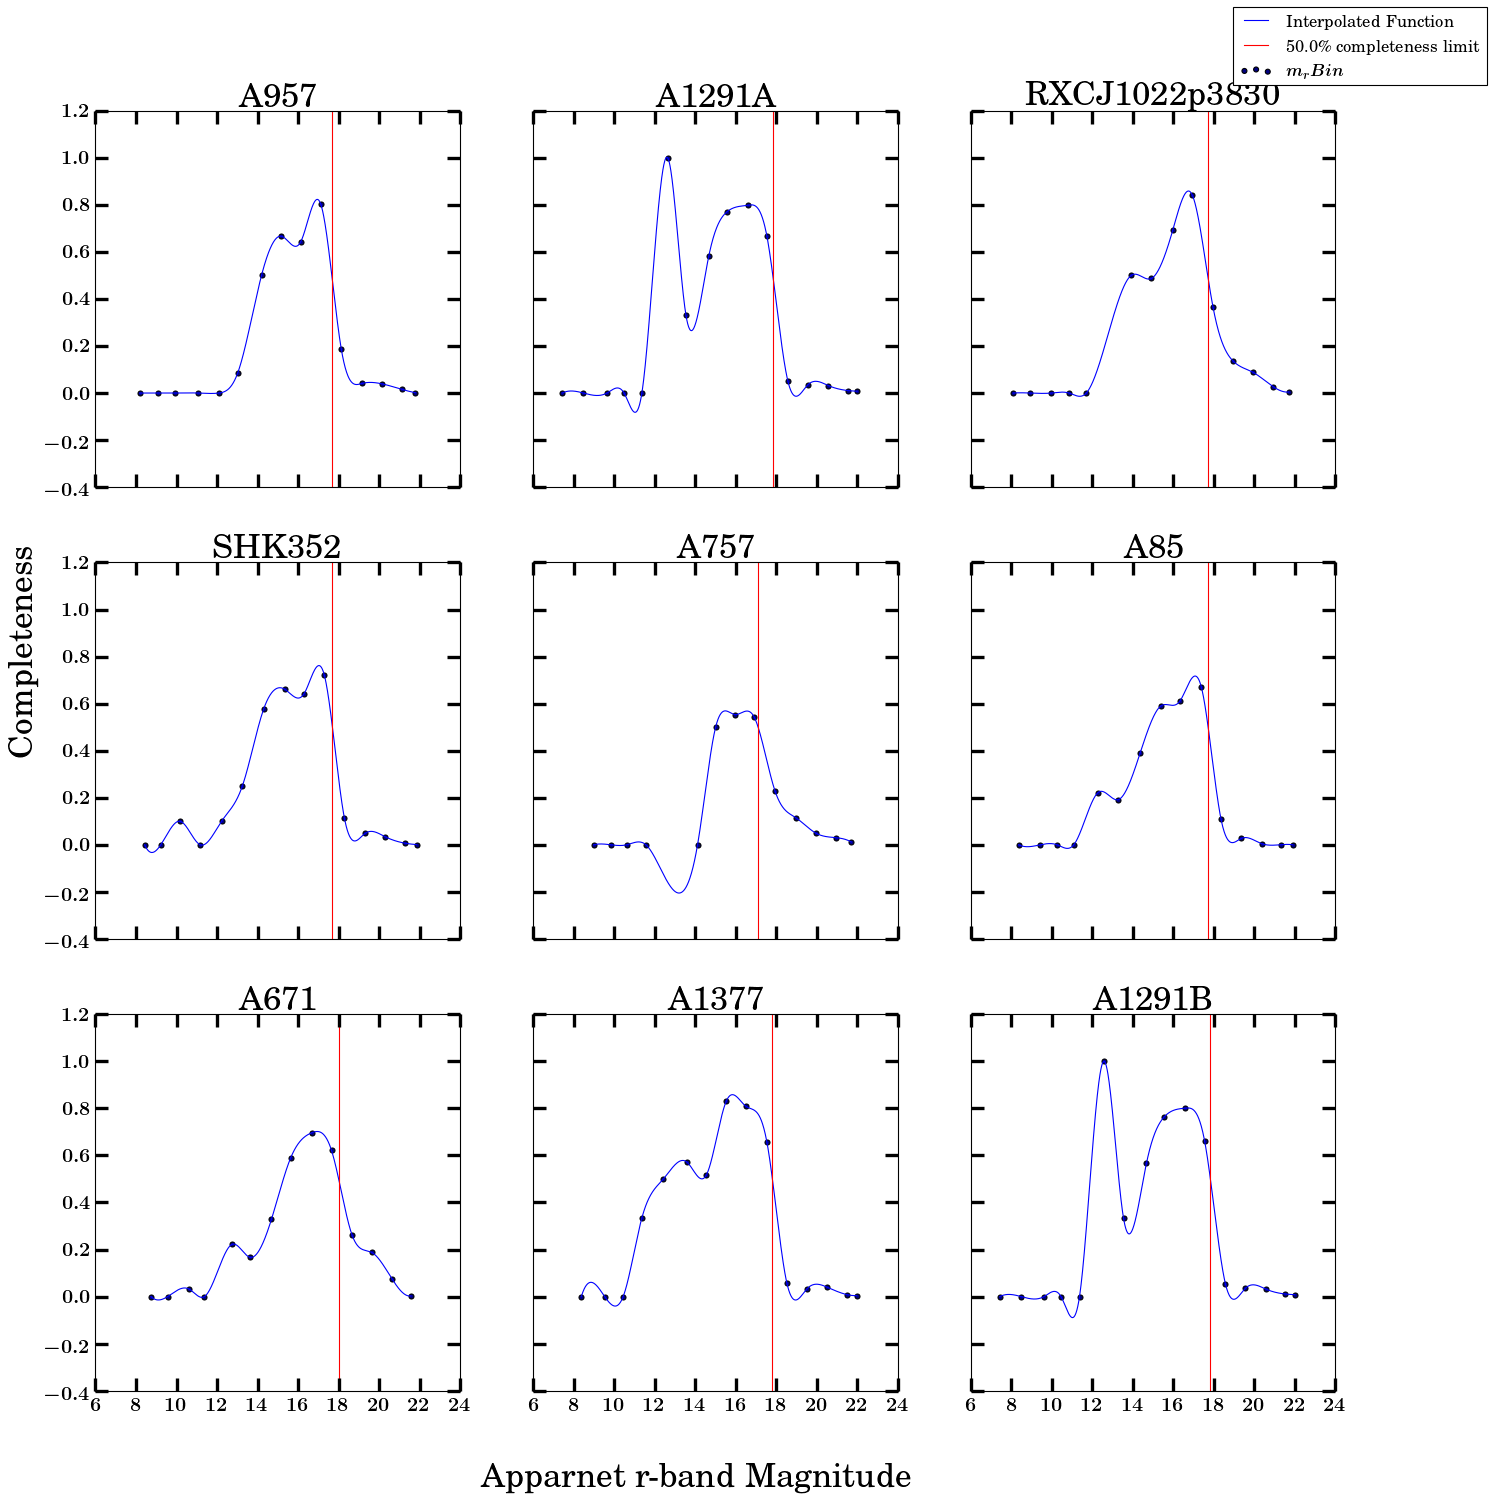

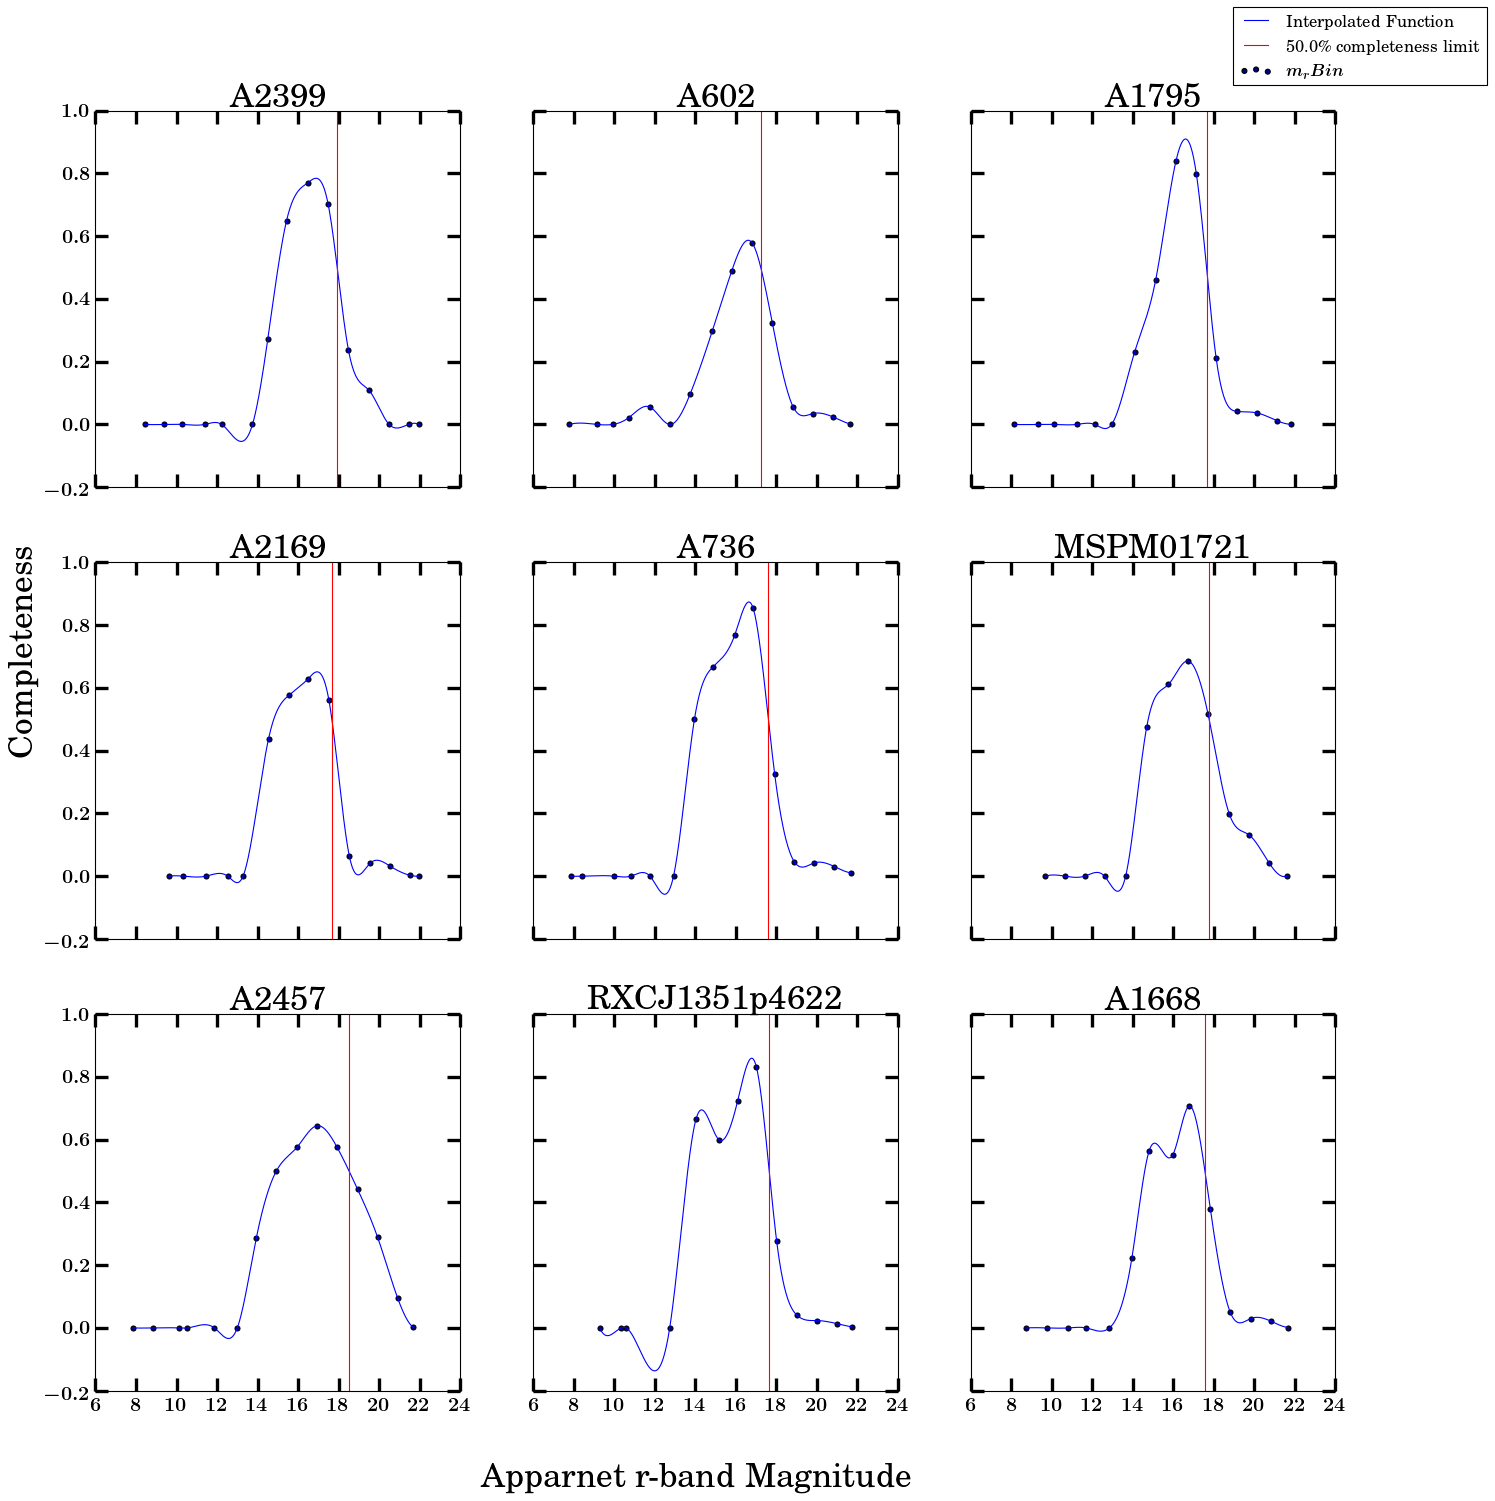

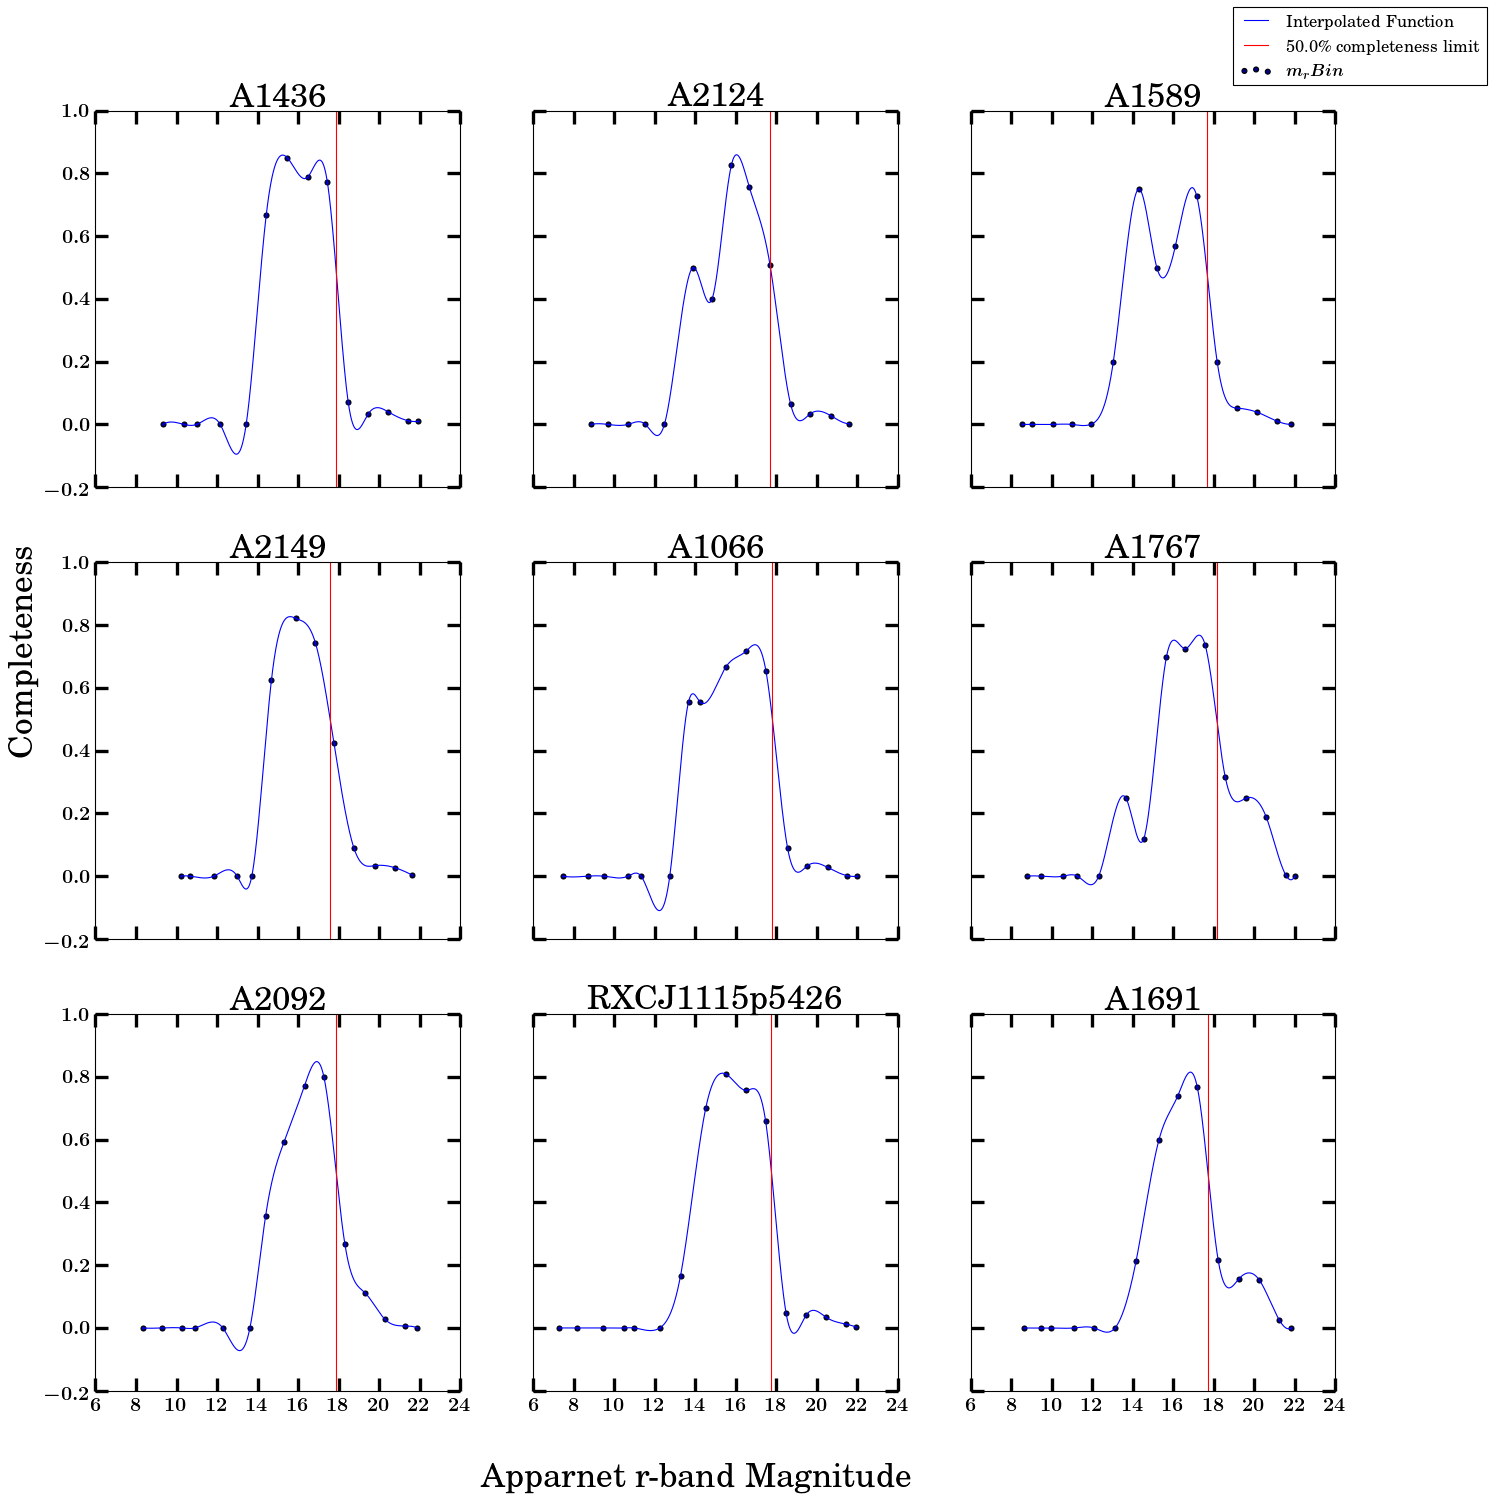

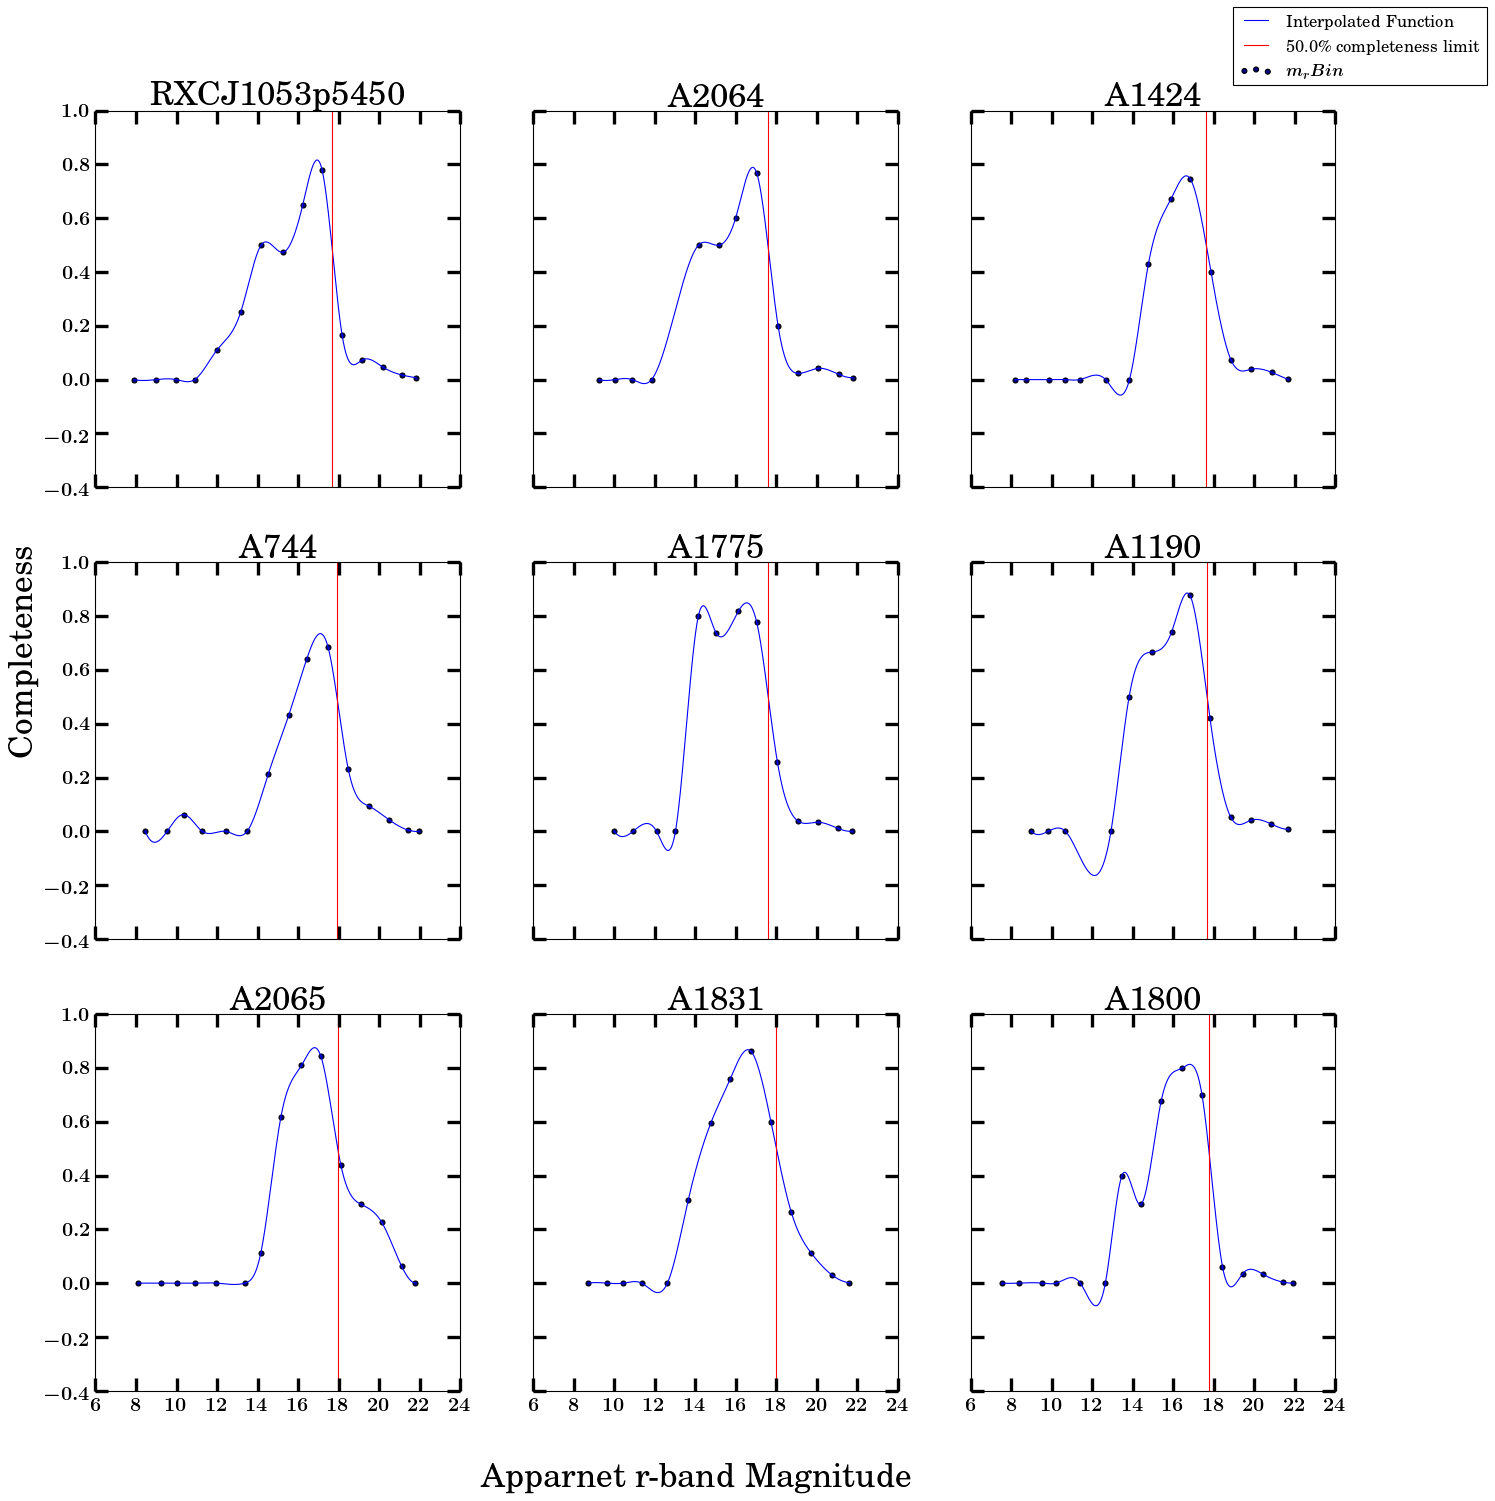

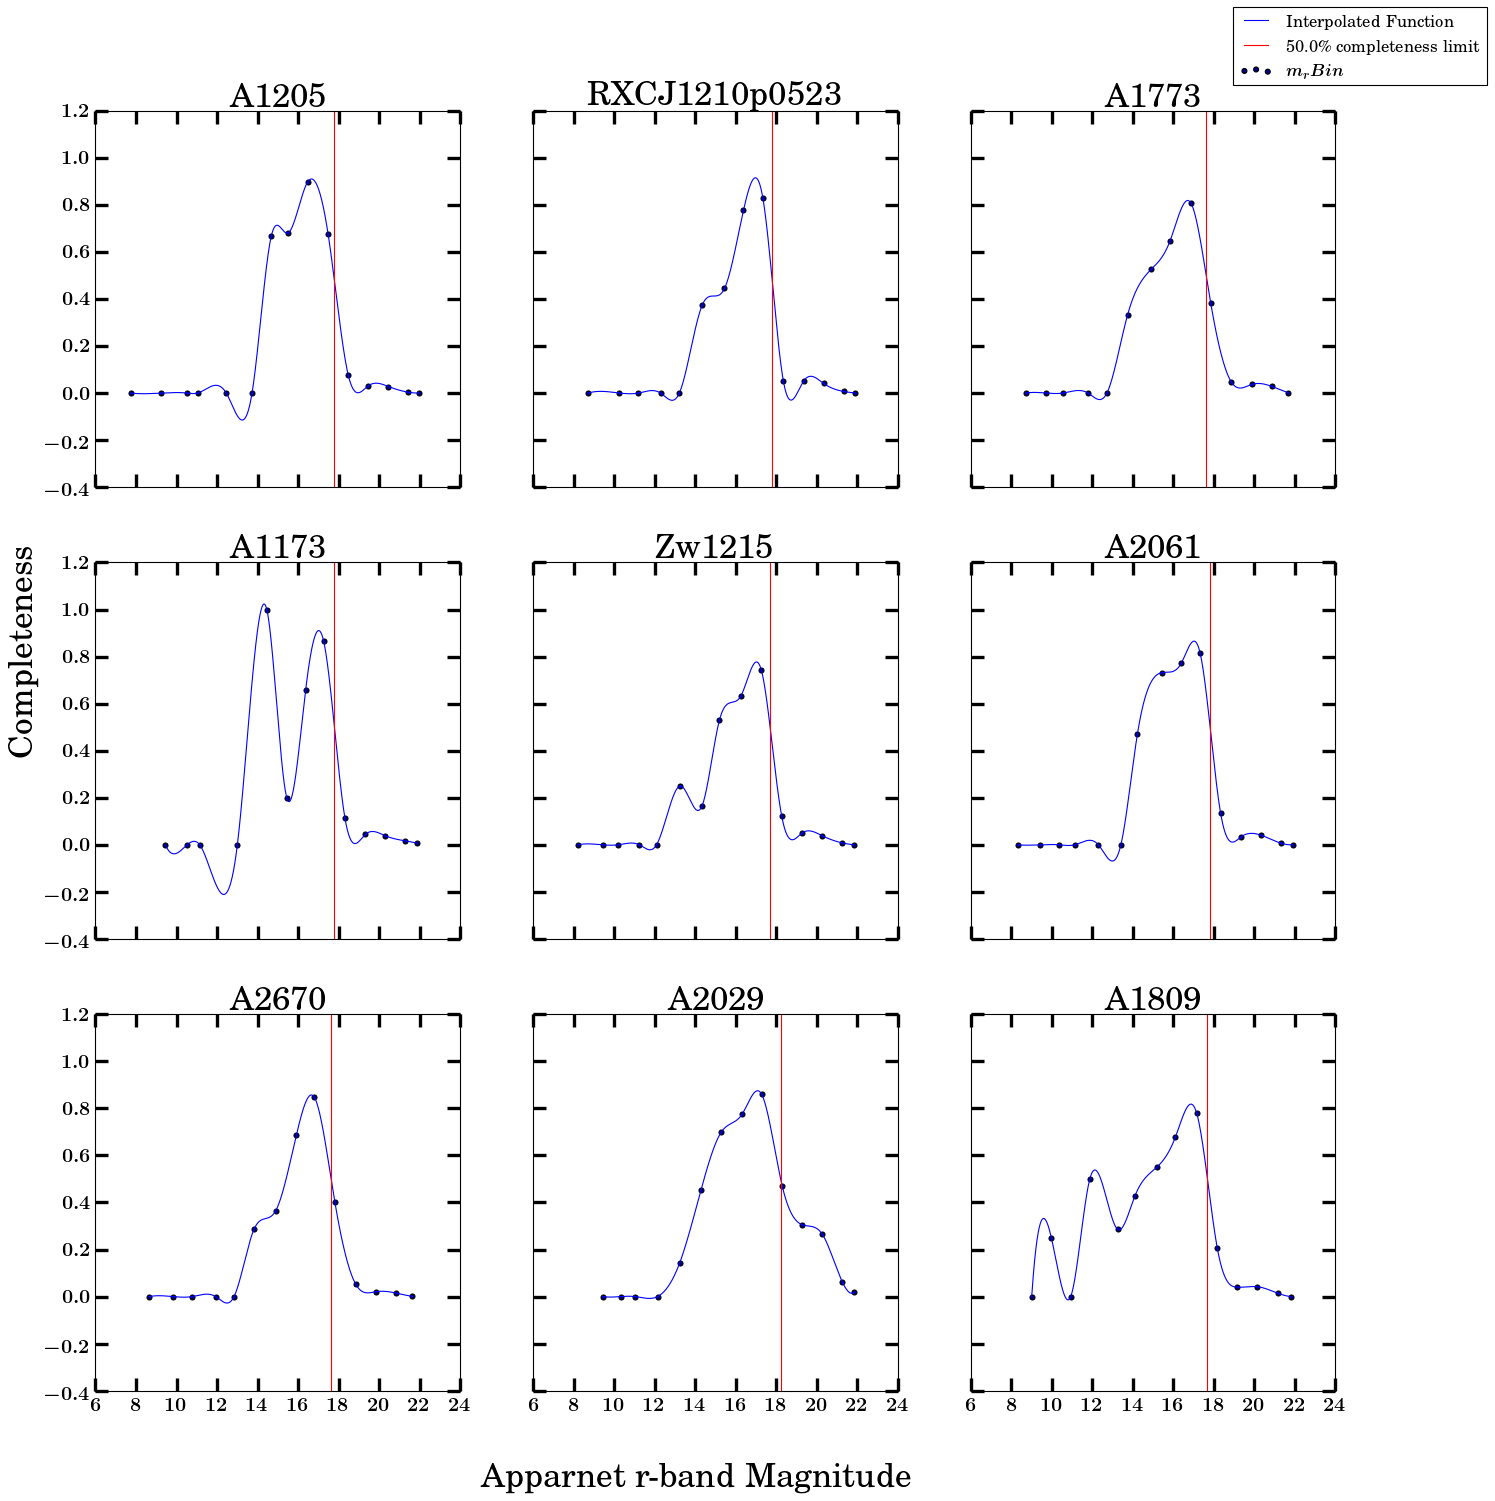

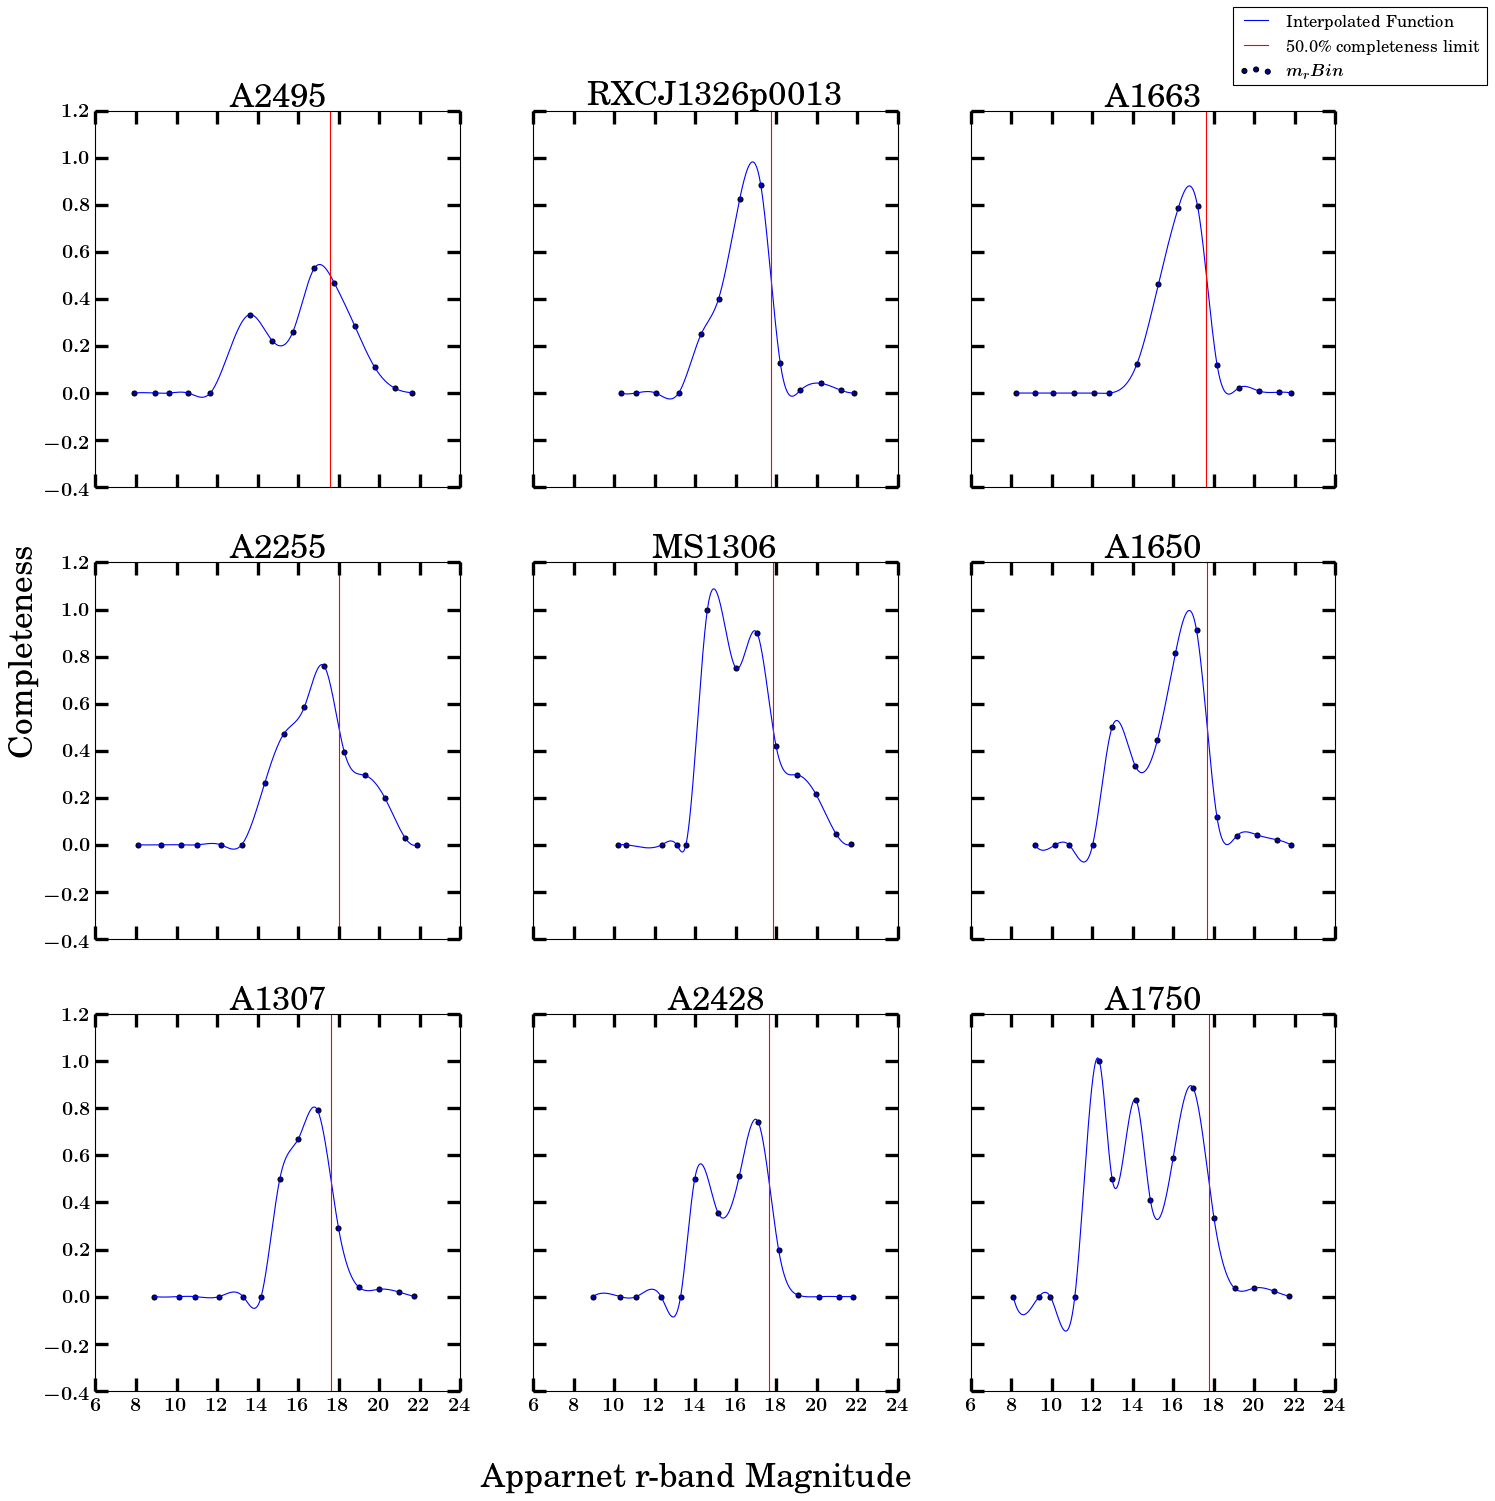

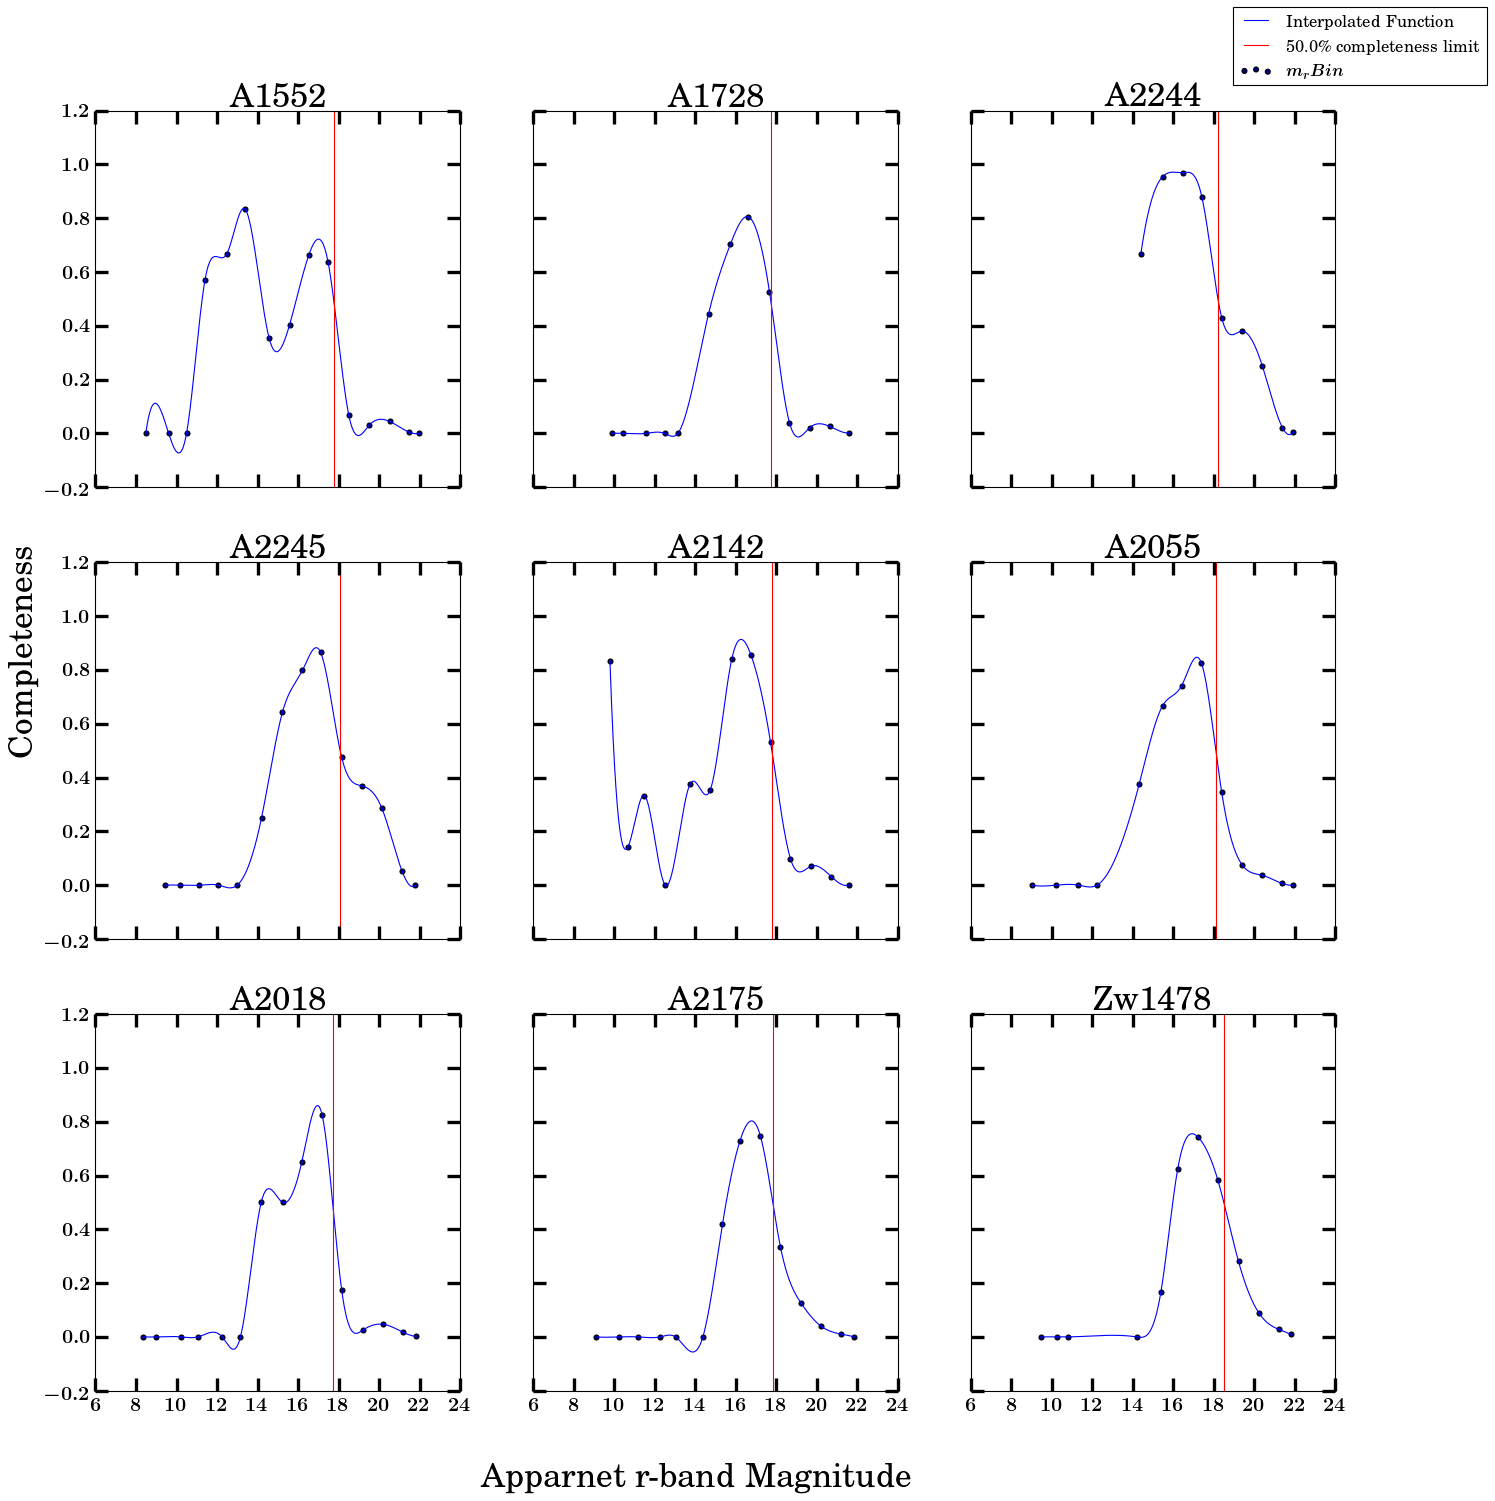

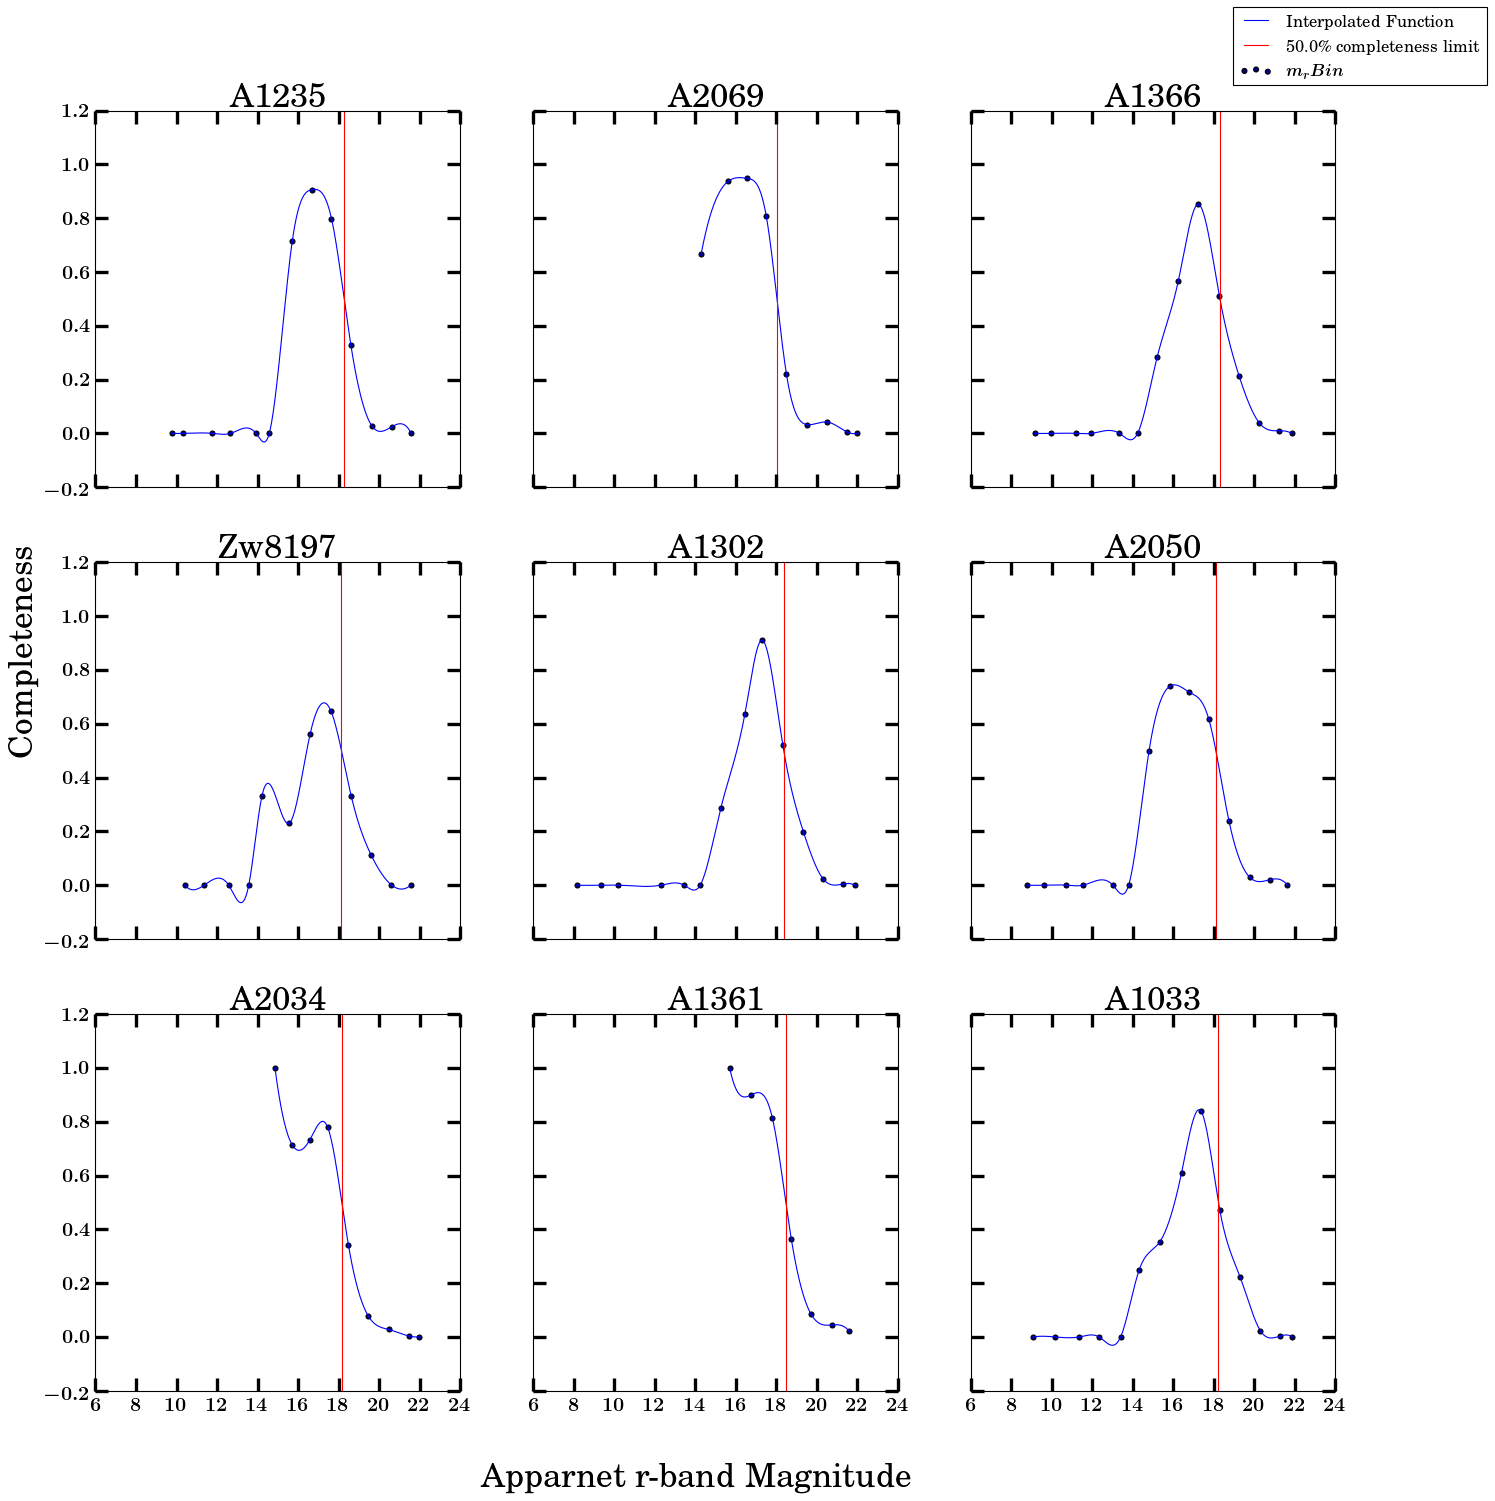

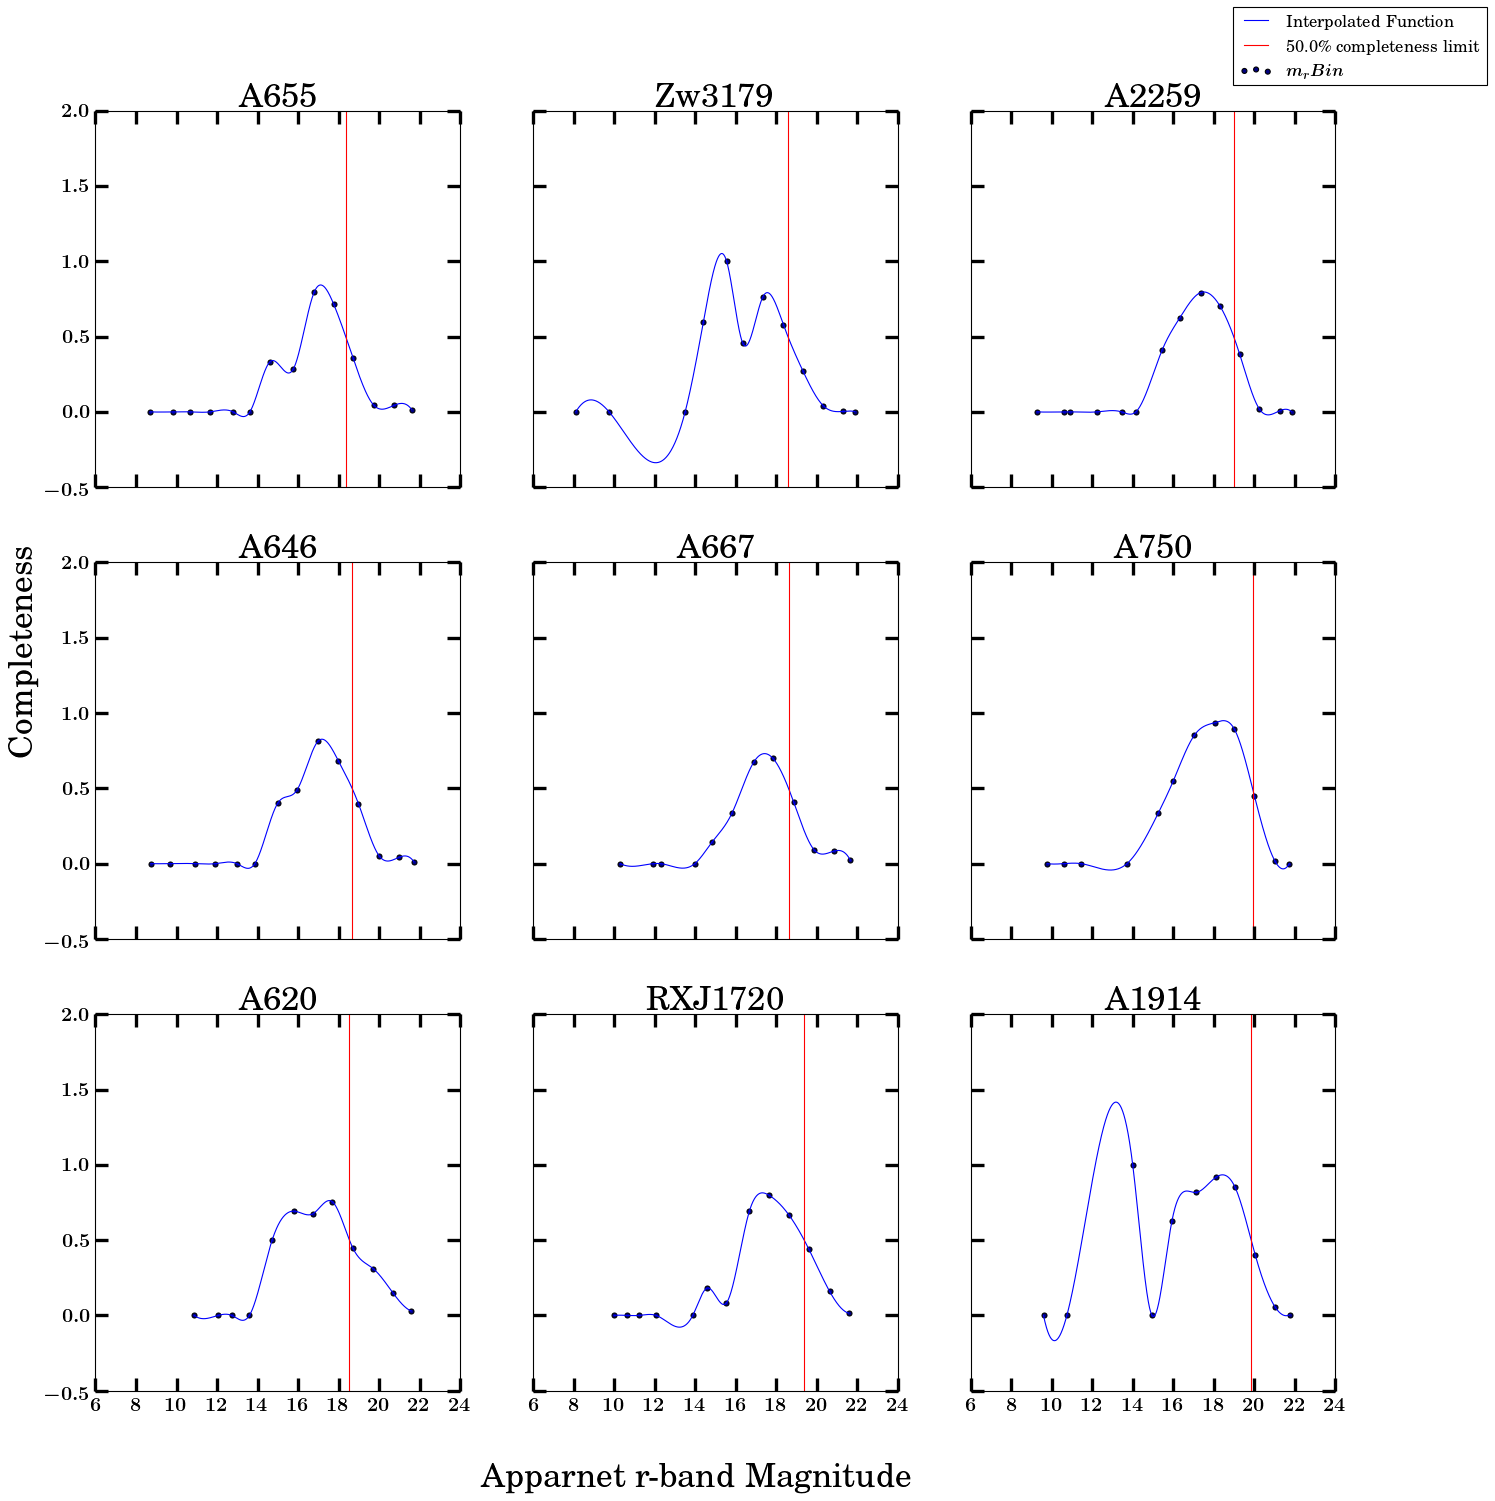

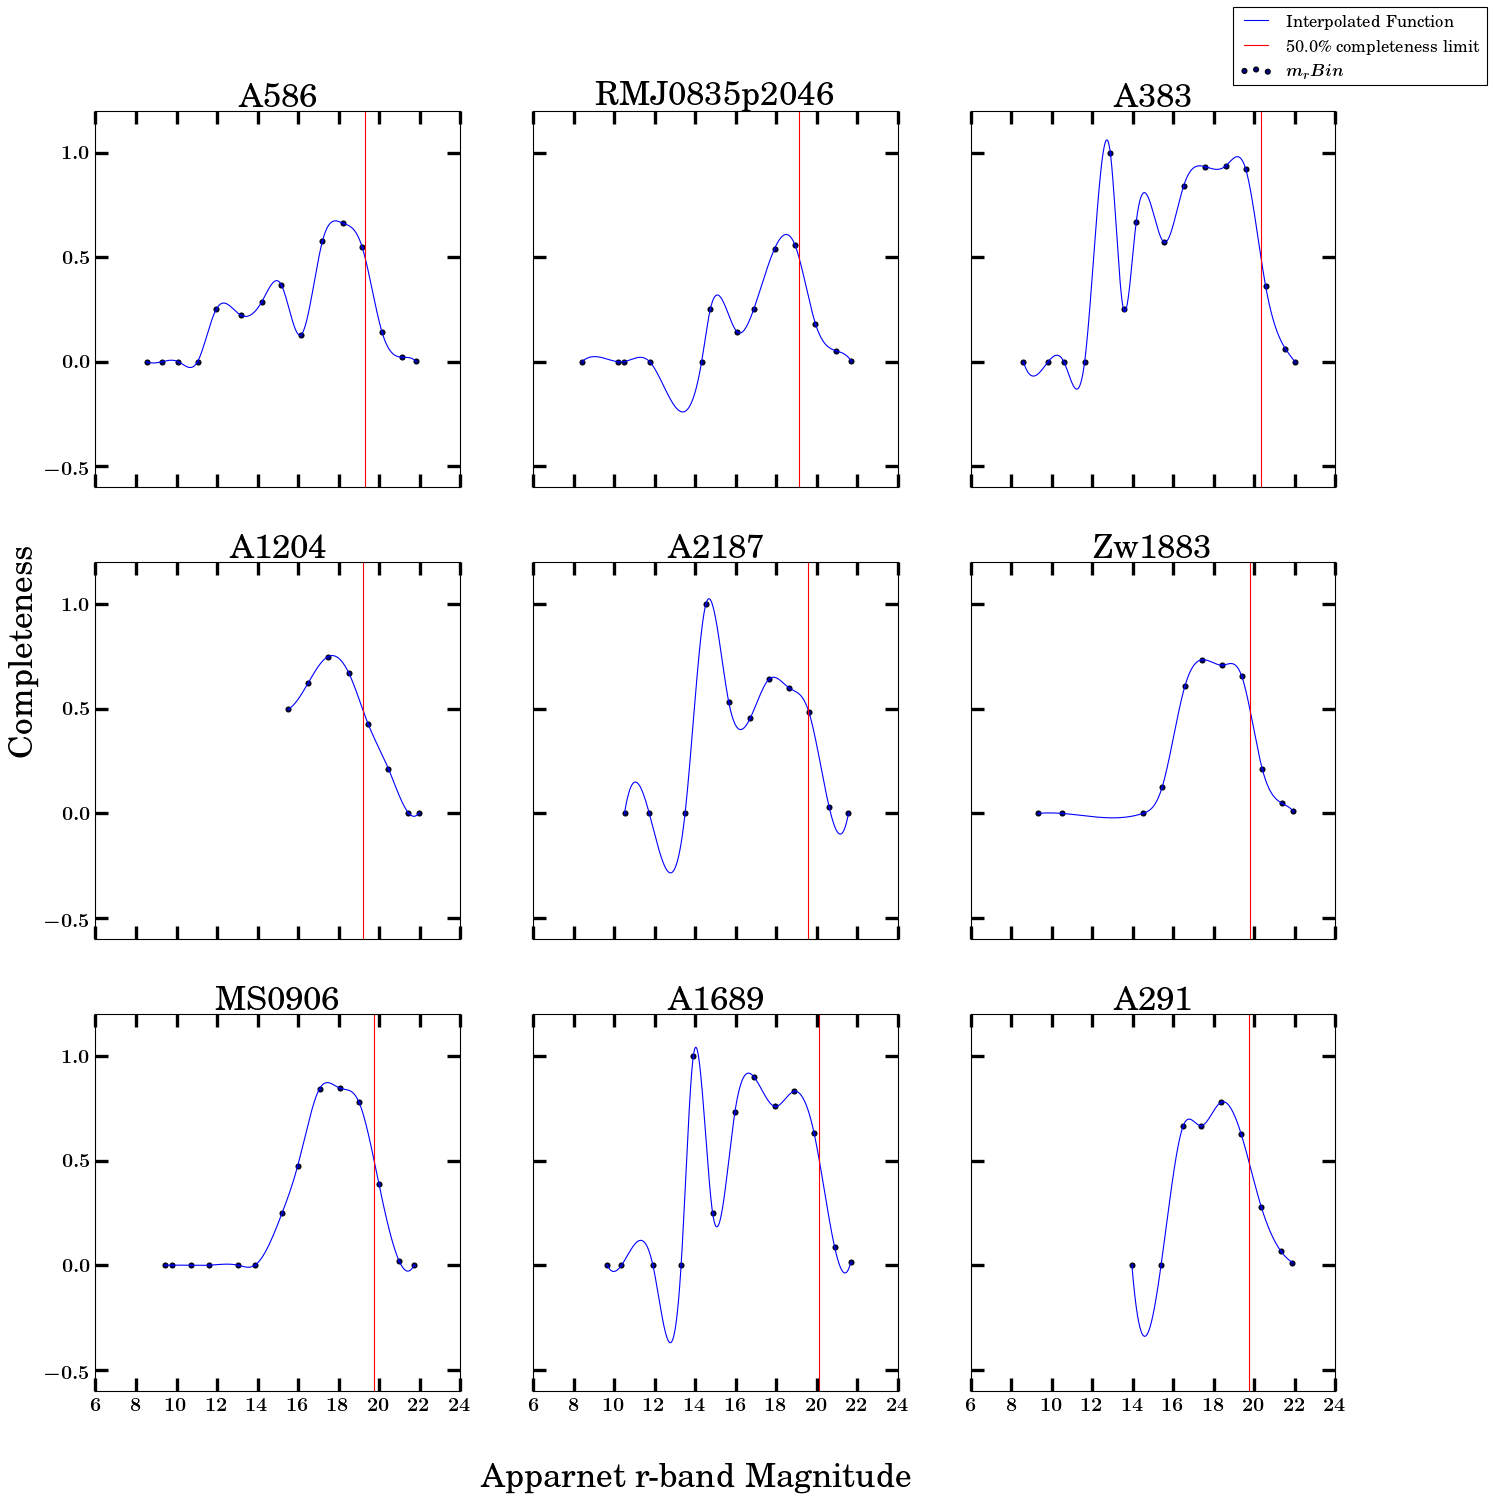

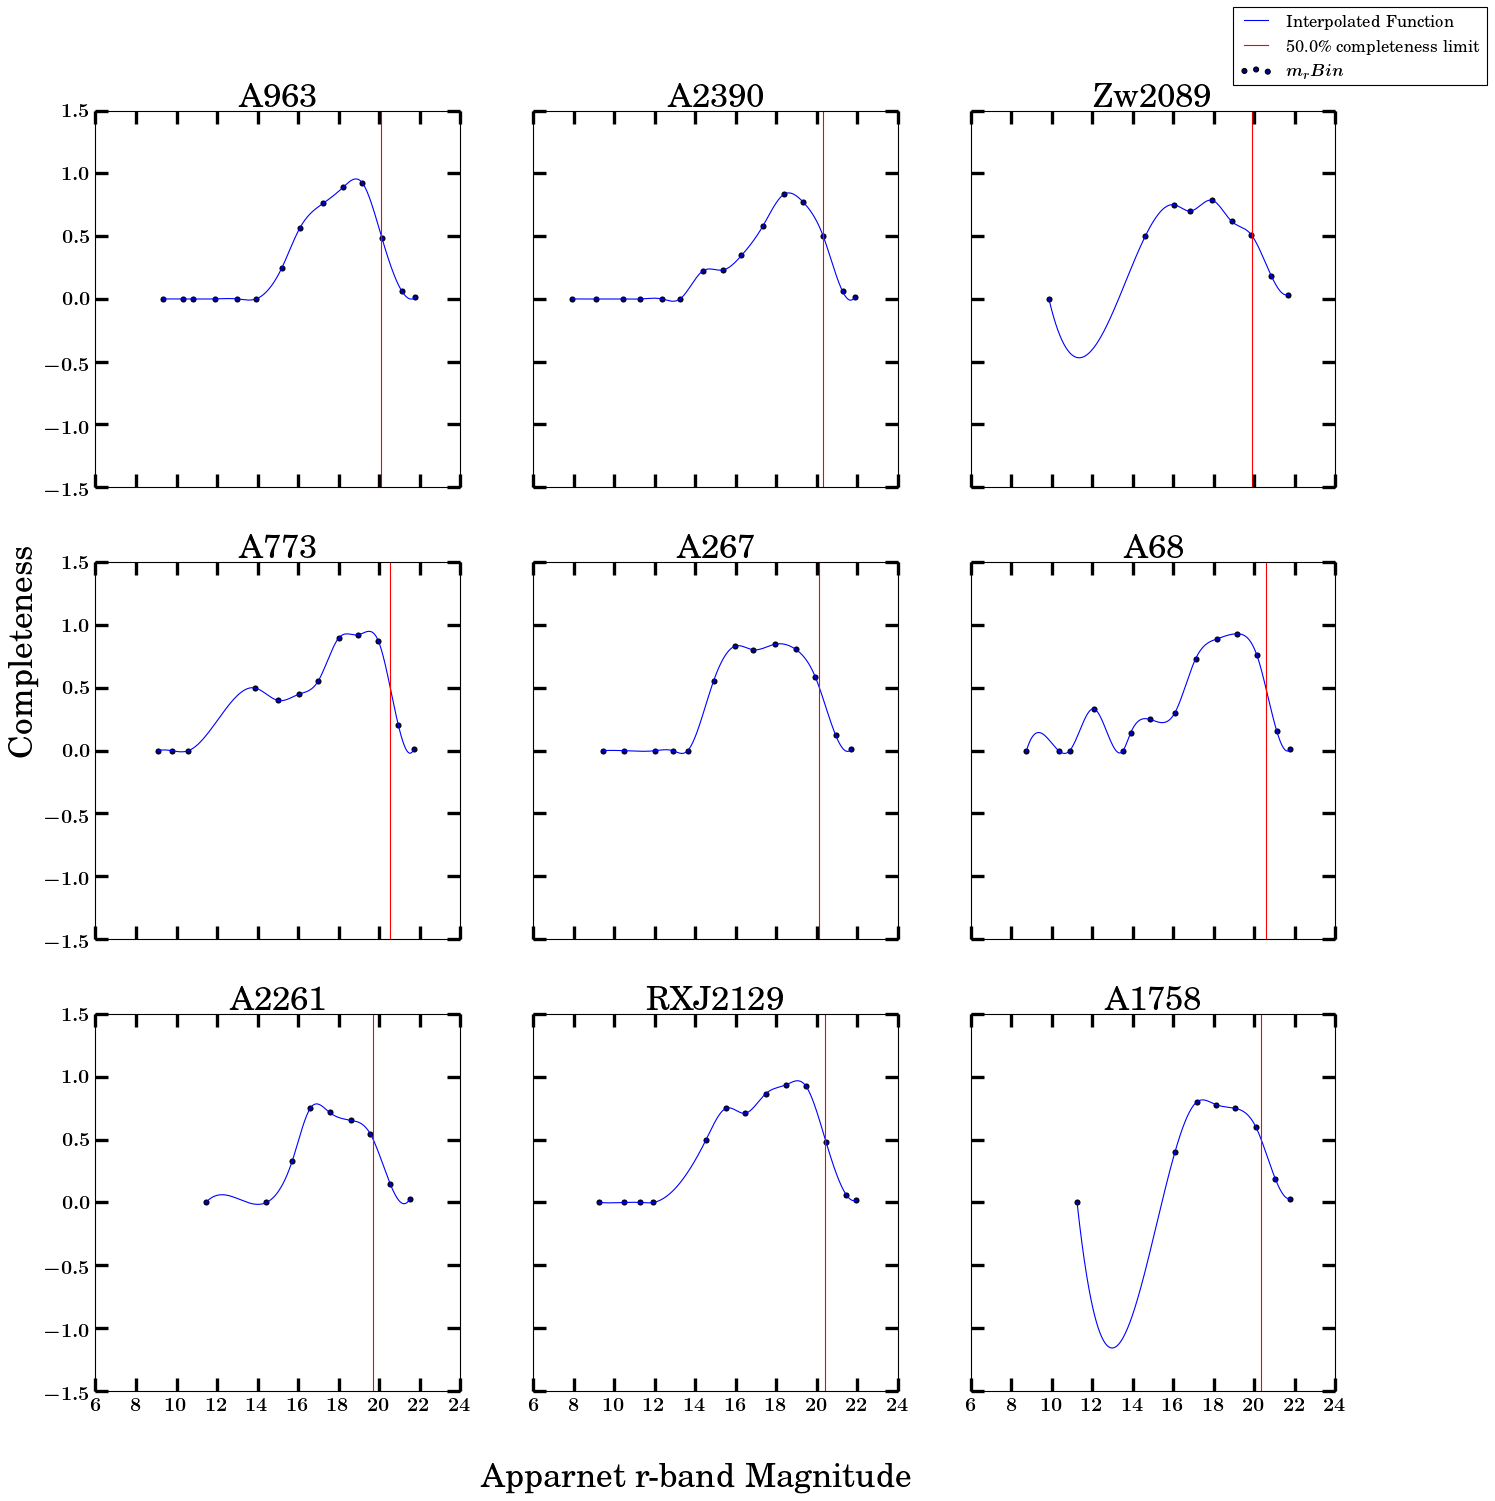

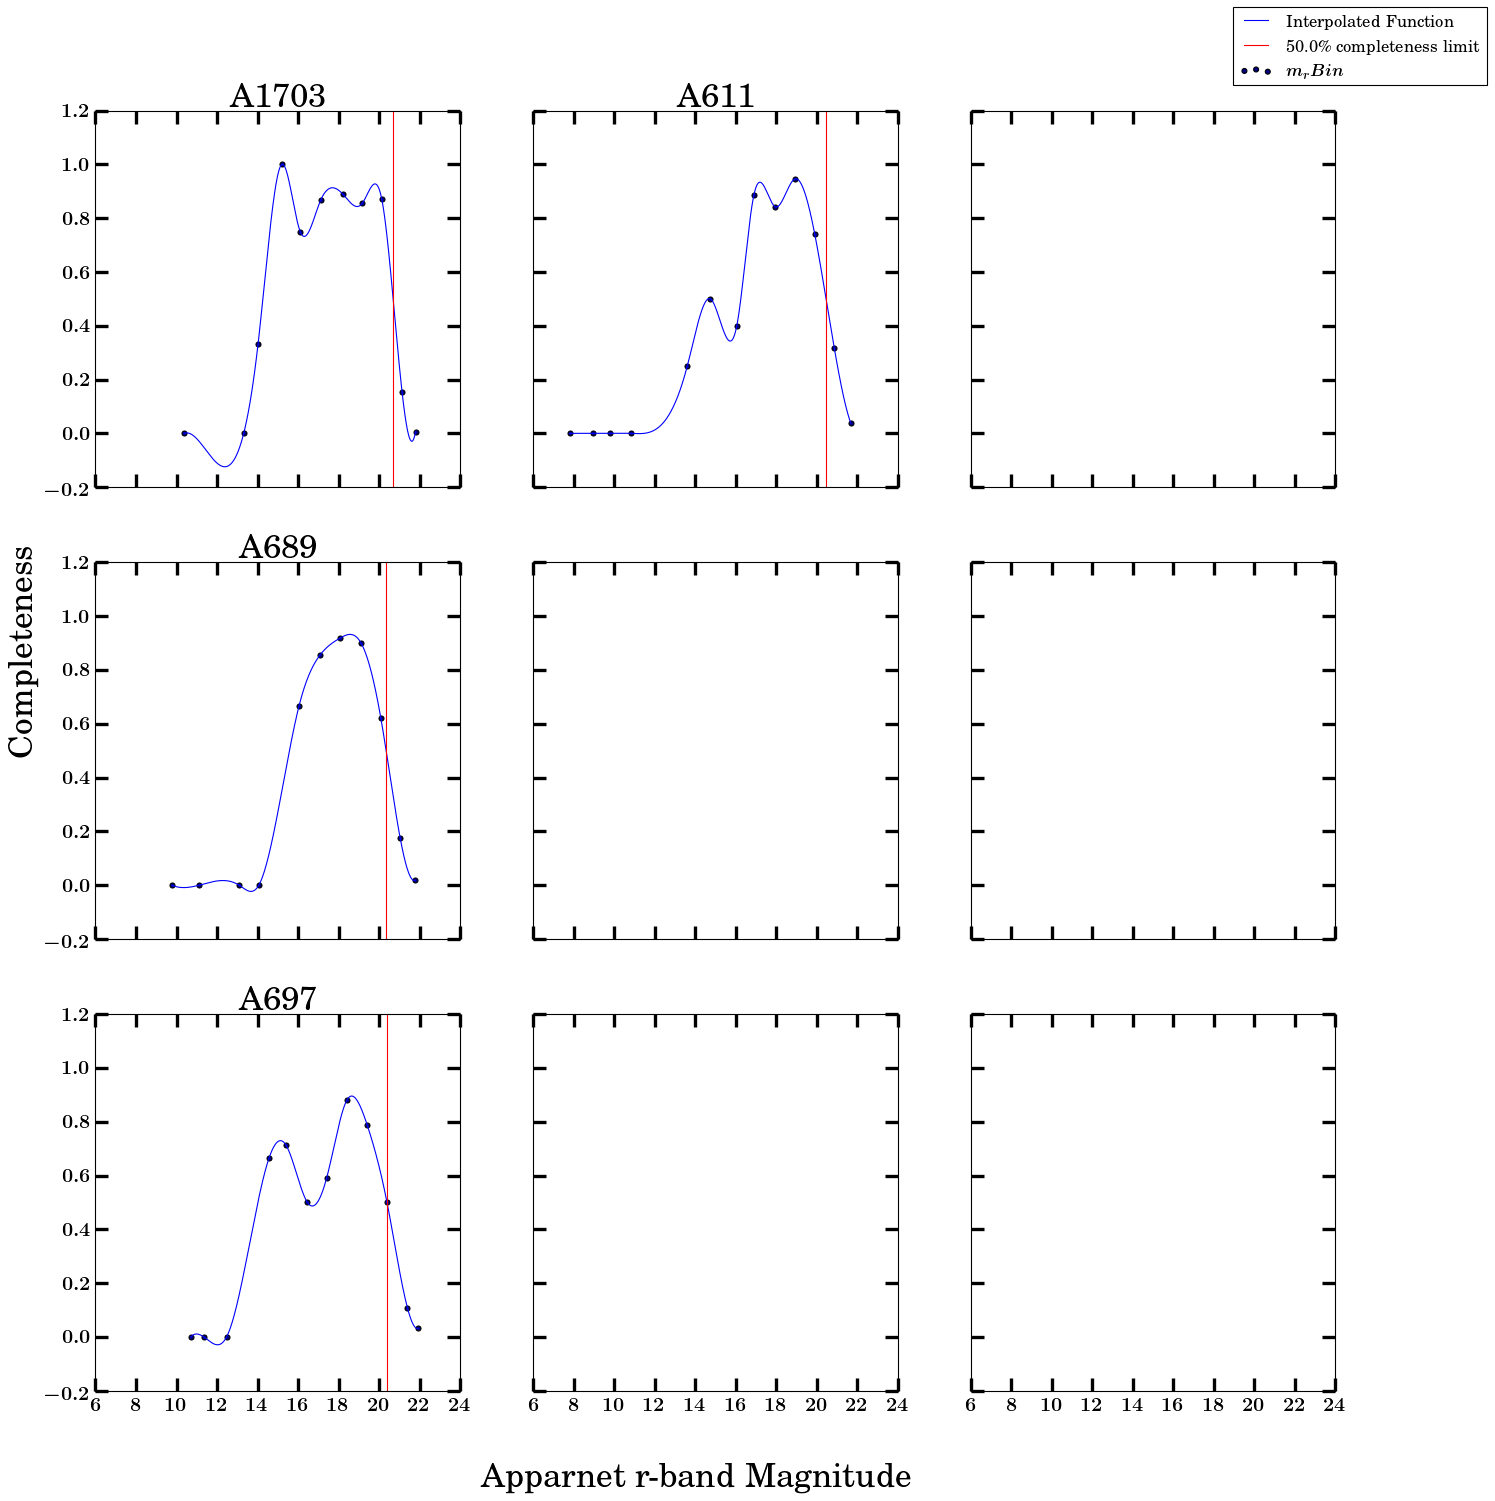

In [12]:
"""
*****************************************************************************
                             END OF DATA PROCESSING
                              Completeness Plots
                                  Apparent Mag
*****************************************************************************
"""
limit50, completenessPlotData = getCompletenessLimit(completnessDict, useAbsMag=False)

numPlotsPerAxis = 3
setLabel = True
fig, axs = plt.subplots(numPlotsPerAxis, numPlotsPerAxis, sharey = True, sharex = True, figsize=(20,20))
for i, cluster in enumerate(completenessPlotData):
    if (i % (numPlotsPerAxis**2) == 0 and i != 0):
        fig.patch.set_facecolor('xkcd:white')
        lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
        lines, labels = [sum(i, []) for i in zip(*lines_labels)]
        fig.legend(lines, labels, bbox_to_anchor = (0,-0.03,1,1), prop={'size': 15})
        fig.text(0.5, 0.04, 'Apparnet r-band Magnitude', ha='center', size=30)
        fig.text(0.08, 0.5, 'Completeness', ha='center', size=30, rotation=90) 
        #fig.savefig("CompLimitApp" + str(i // (numPlotsPerAxis**2)) + ".pdf", bbox_inches='tight')
        fig.show()
        fig, axs = plt.subplots(numPlotsPerAxis, numPlotsPerAxis, sharey = True, sharex = True, figsize=(20,20))
        setLabel = True
        
    rowIndex = i % numPlotsPerAxis
    colIndex = (i // numPlotsPerAxis) % numPlotsPerAxis 
    if (setLabel):
        axs[rowIndex, colIndex].plot(completenessPlotData[cluster][0], completenessPlotData[cluster][1], label="Interpolated Function")
        axs[rowIndex, colIndex].scatter(completnessDict[cluster][1], completnessDict[cluster][0], label=r"$m_{r} Bin$", c="navy")
        axs[rowIndex, colIndex].axvline(x=limit50[cluster], c='r', label=f"{completenessLimit * 100.0}\% completeness limit")
        setLabel = False
    else:
        axs[rowIndex, colIndex].plot(completenessPlotData[cluster][0], completenessPlotData[cluster][1])
        axs[rowIndex, colIndex].scatter(completnessDict[cluster][1], completnessDict[cluster][0], c="navy")
        axs[rowIndex, colIndex].axvline(x=limit50[cluster], c='r')
    plotTitle = cluster.replace("_", " ") # LaTeX doesn't like _
    axs[rowIndex, colIndex].set_title(plotTitle)
    
fig.patch.set_facecolor('xkcd:white')
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(i, []) for i in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor = (0,-0.03,1,1), prop={'size': 15})
fig.text(0.5, 0.04, 'Apparnet r-band Magnitude', ha='center', size=30)
fig.text(0.08, 0.5, 'Completeness', ha='center', size=30, rotation=90) 
#fig.savefig("CompLimitApp" + str(i // (numPlotsPerAxis**2)) + ".pdf", bbox_inches='tight')
fig.show()

100%|██████████████████████|Calculating the Completeness Limit for Each Cluster


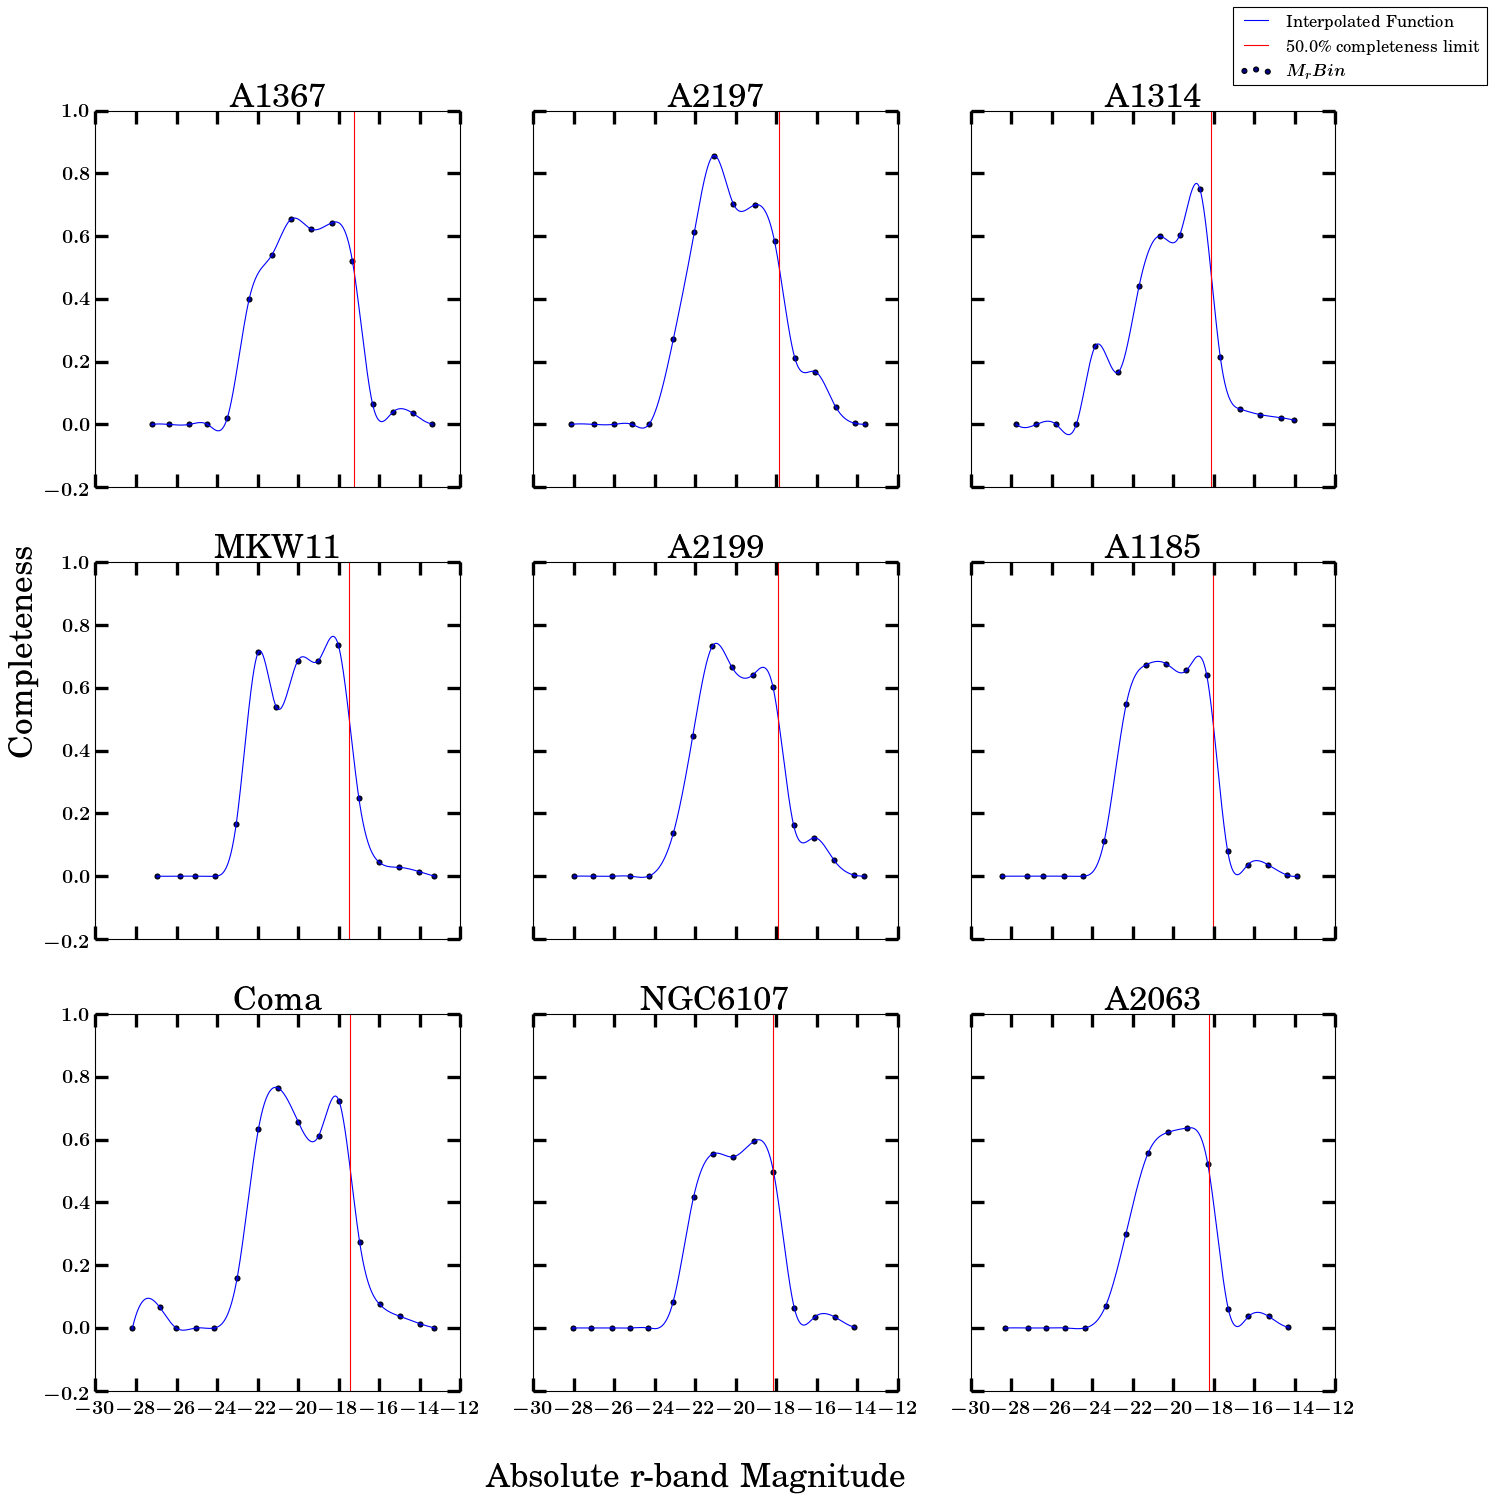

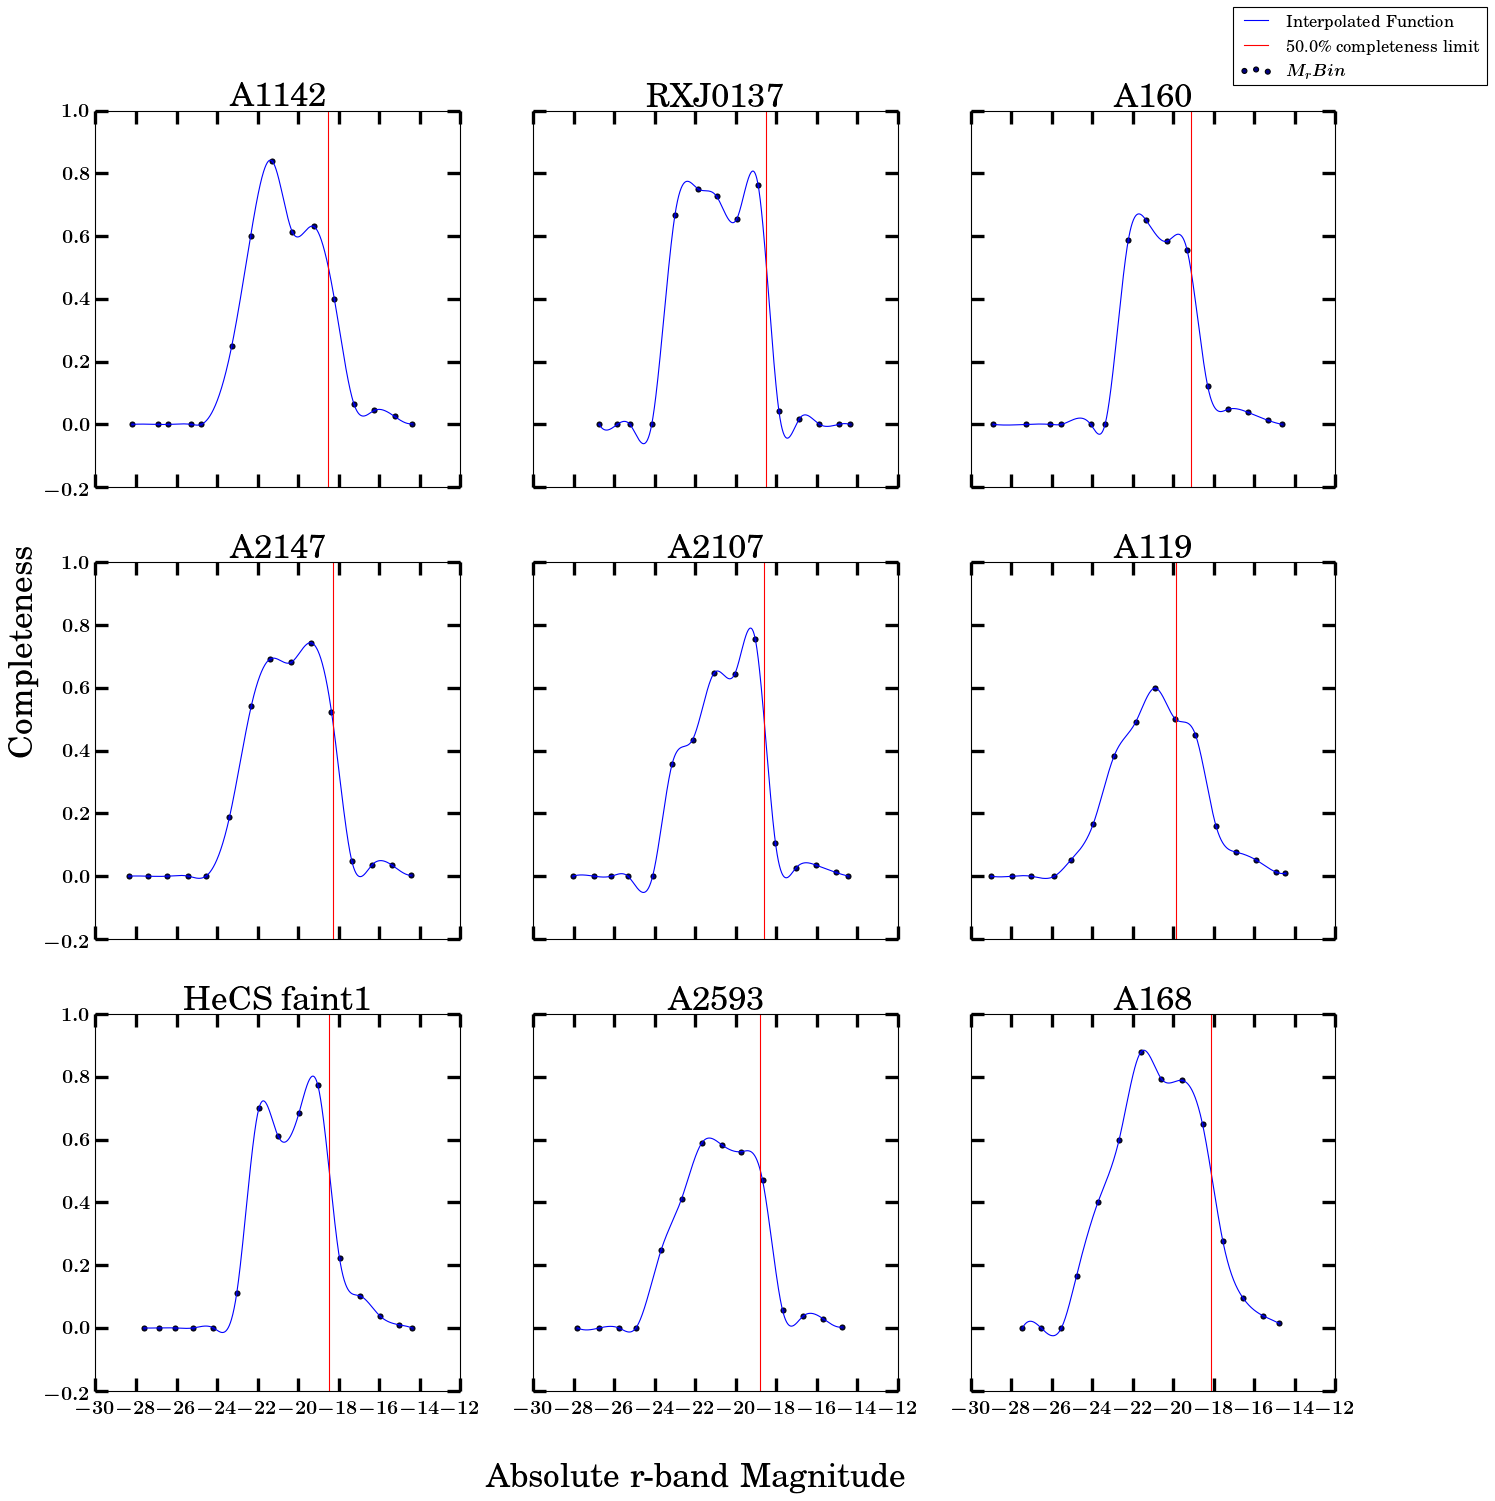

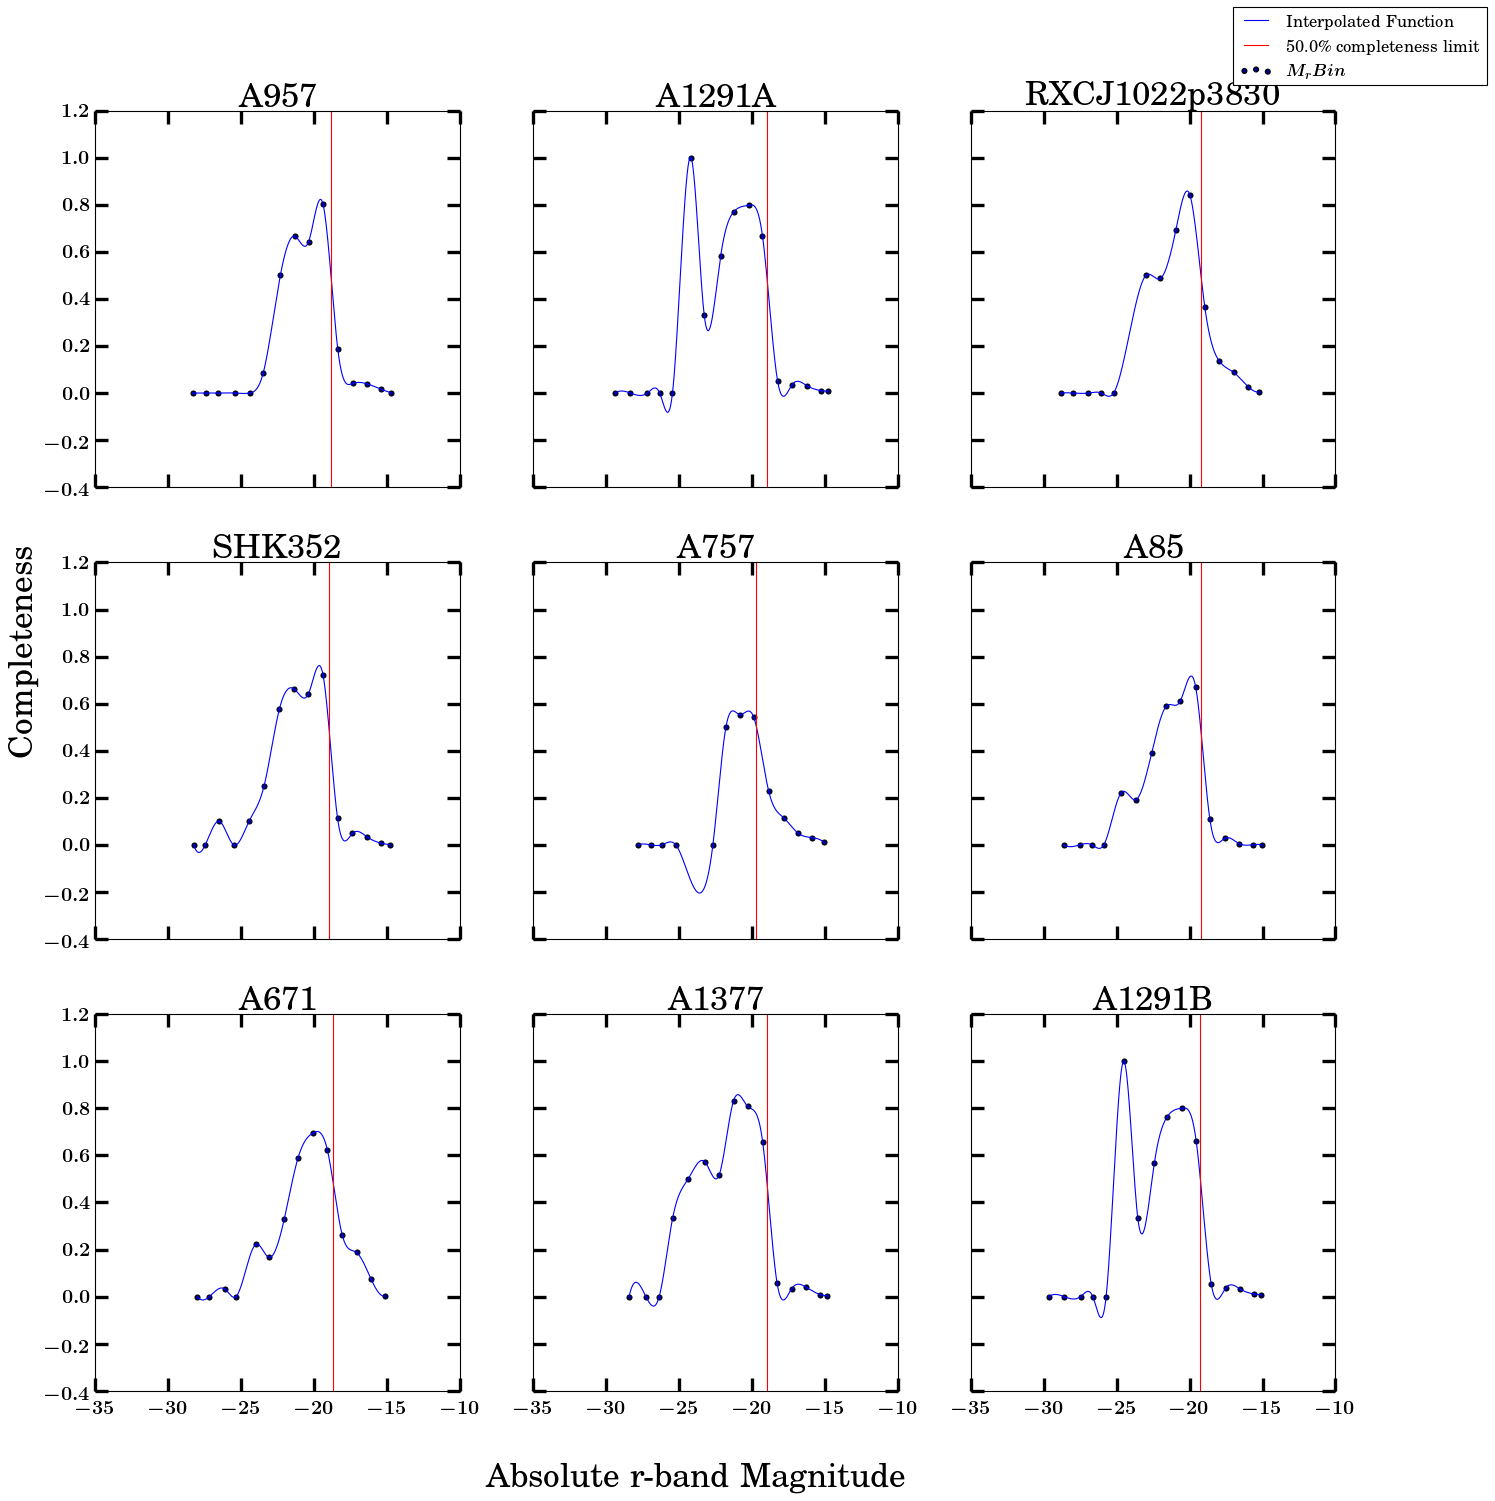

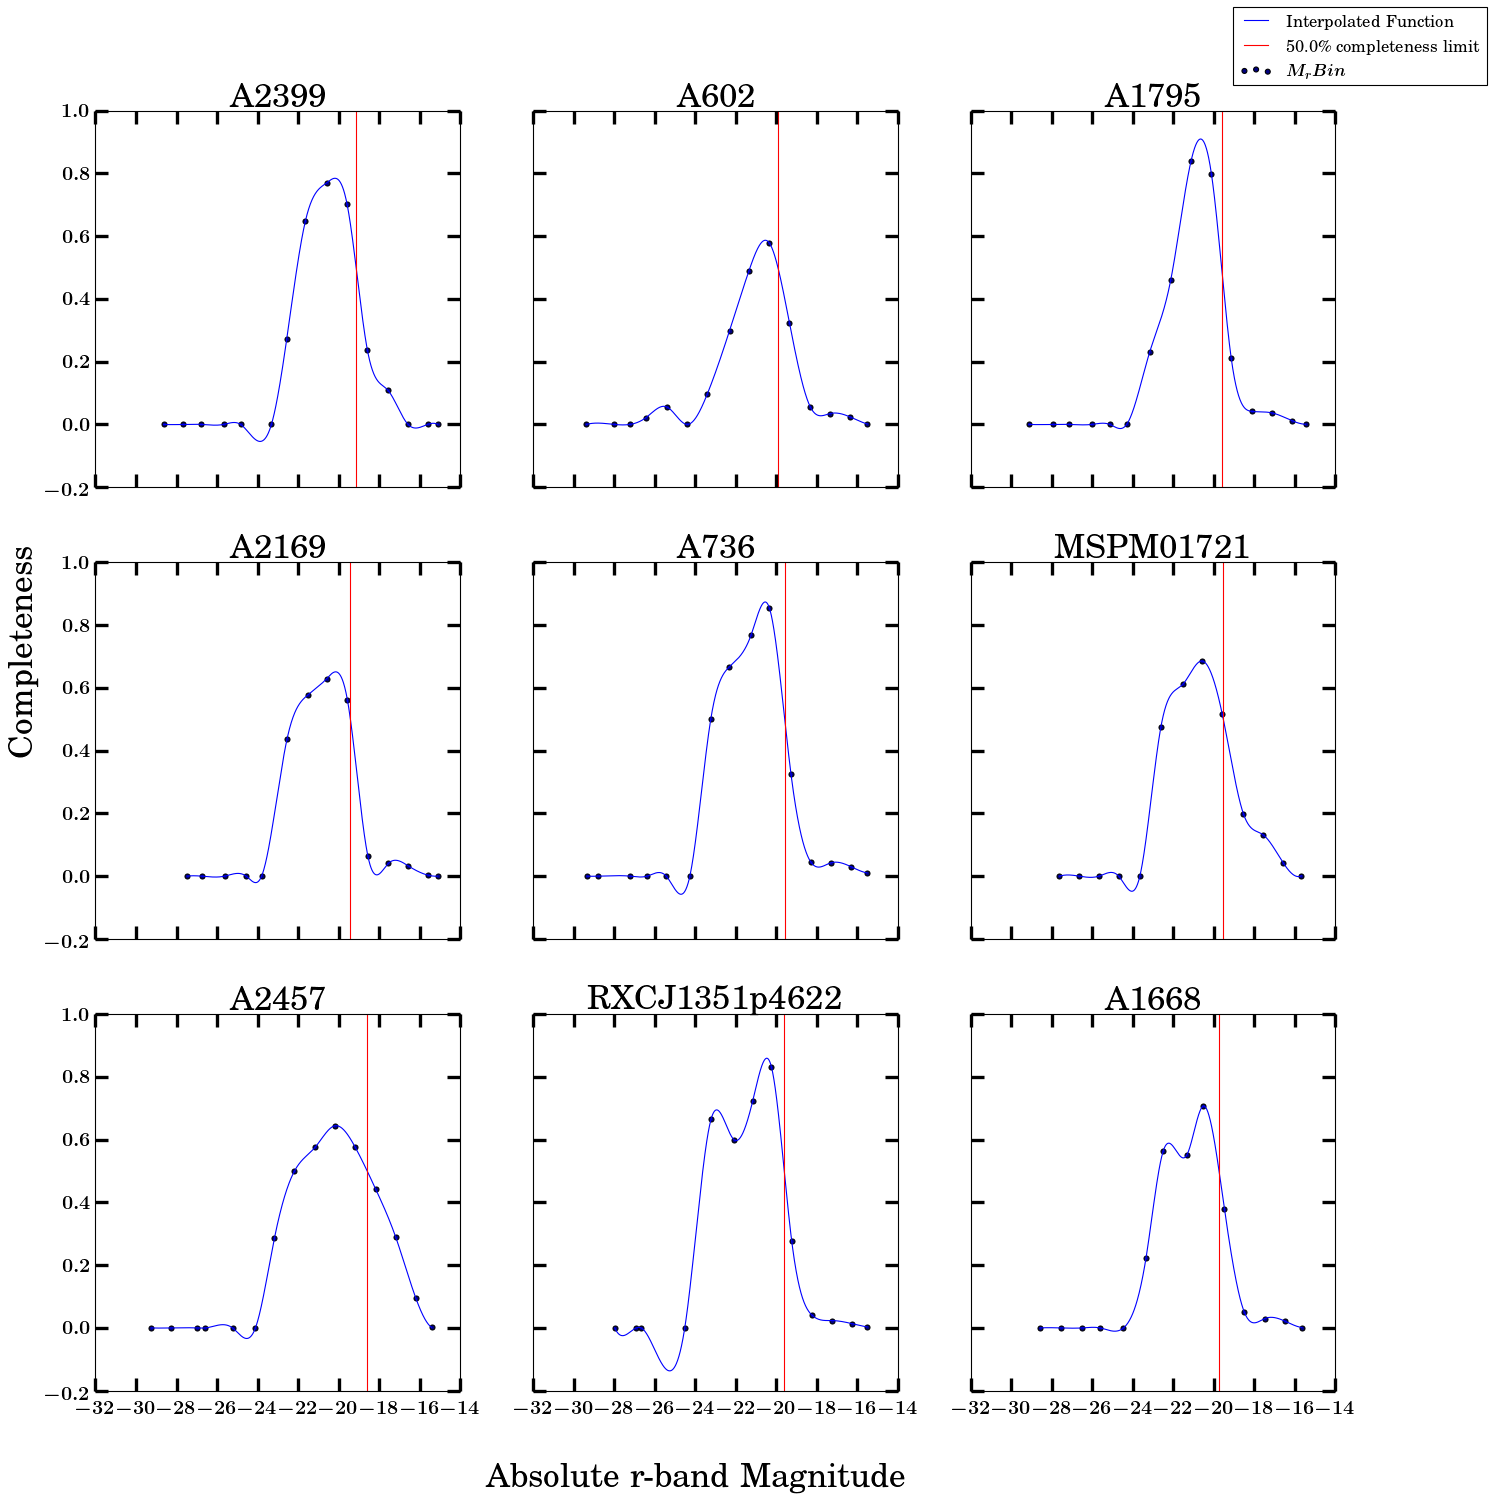

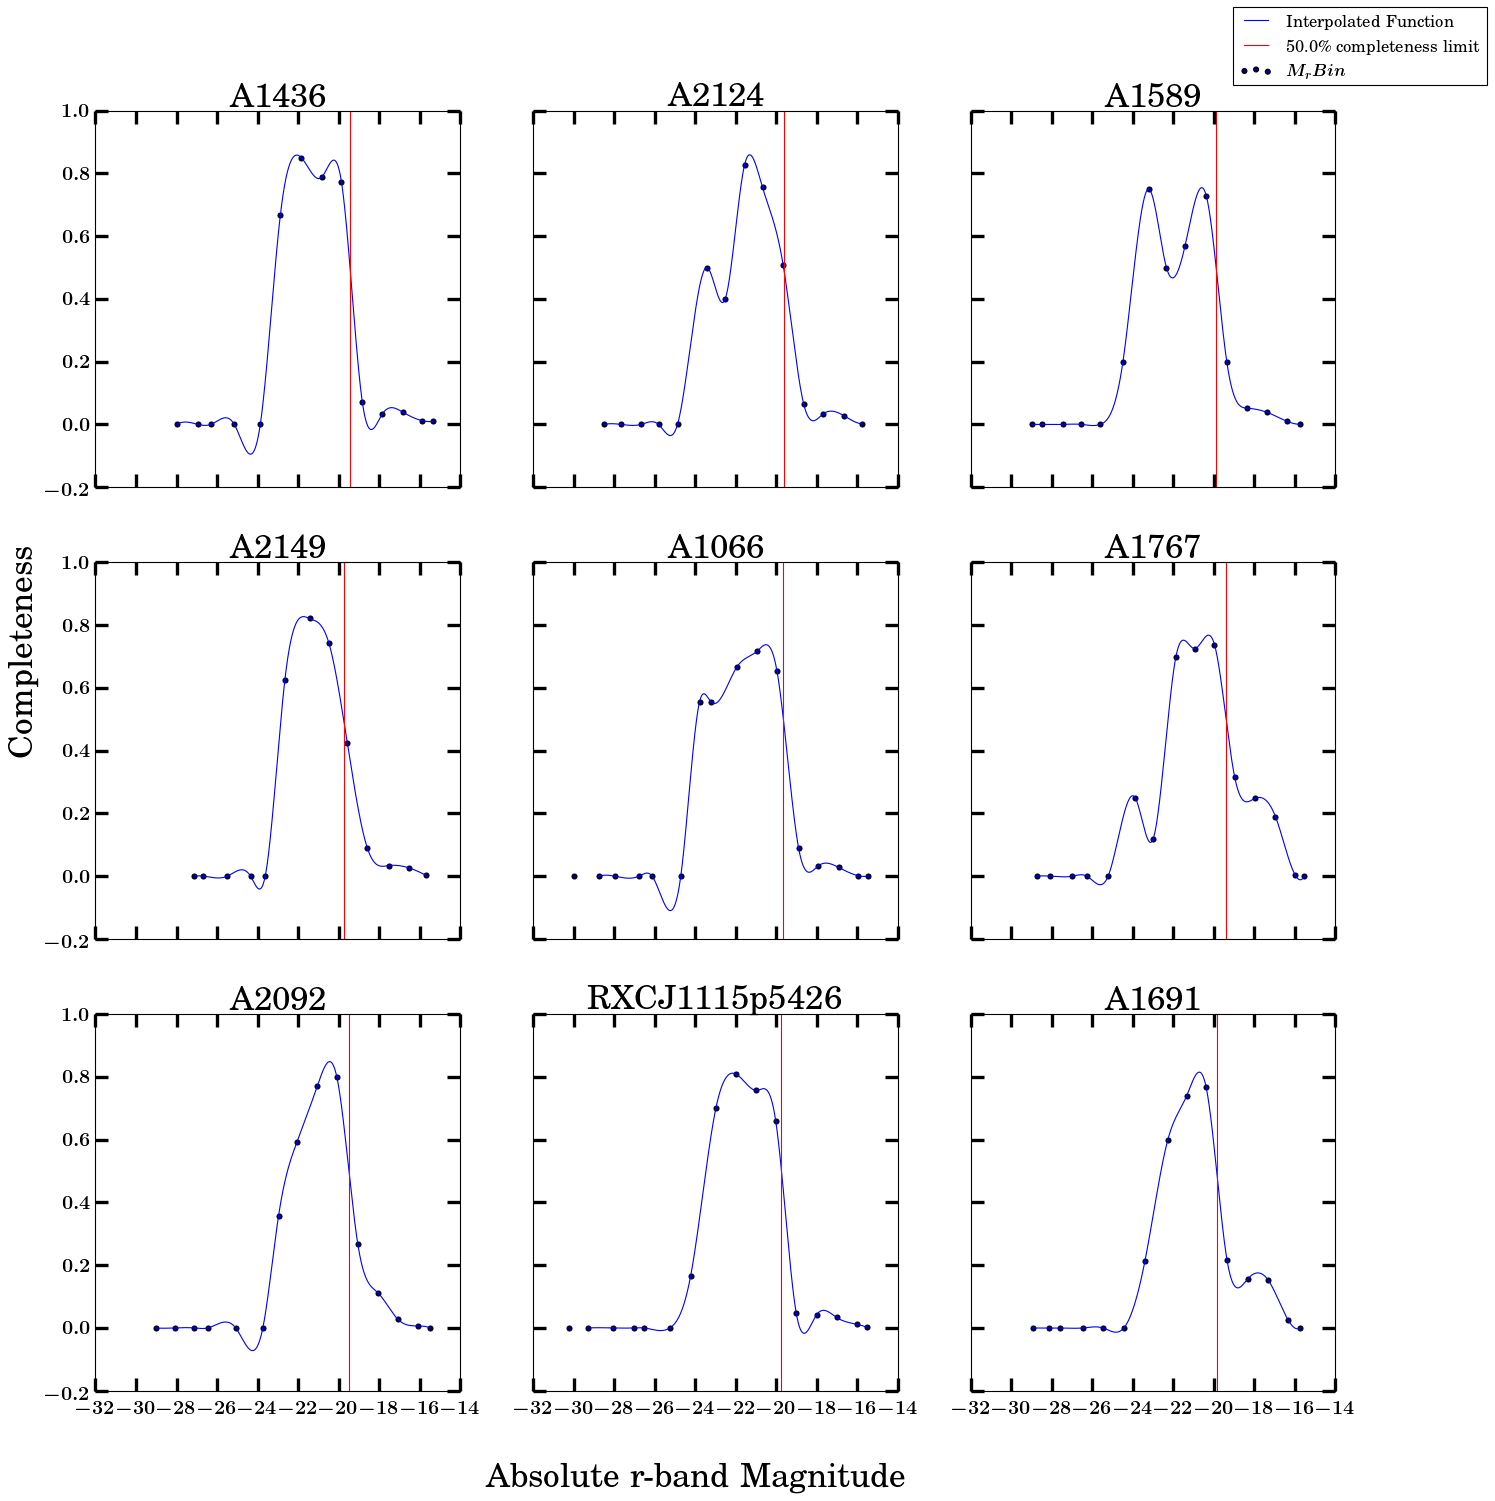

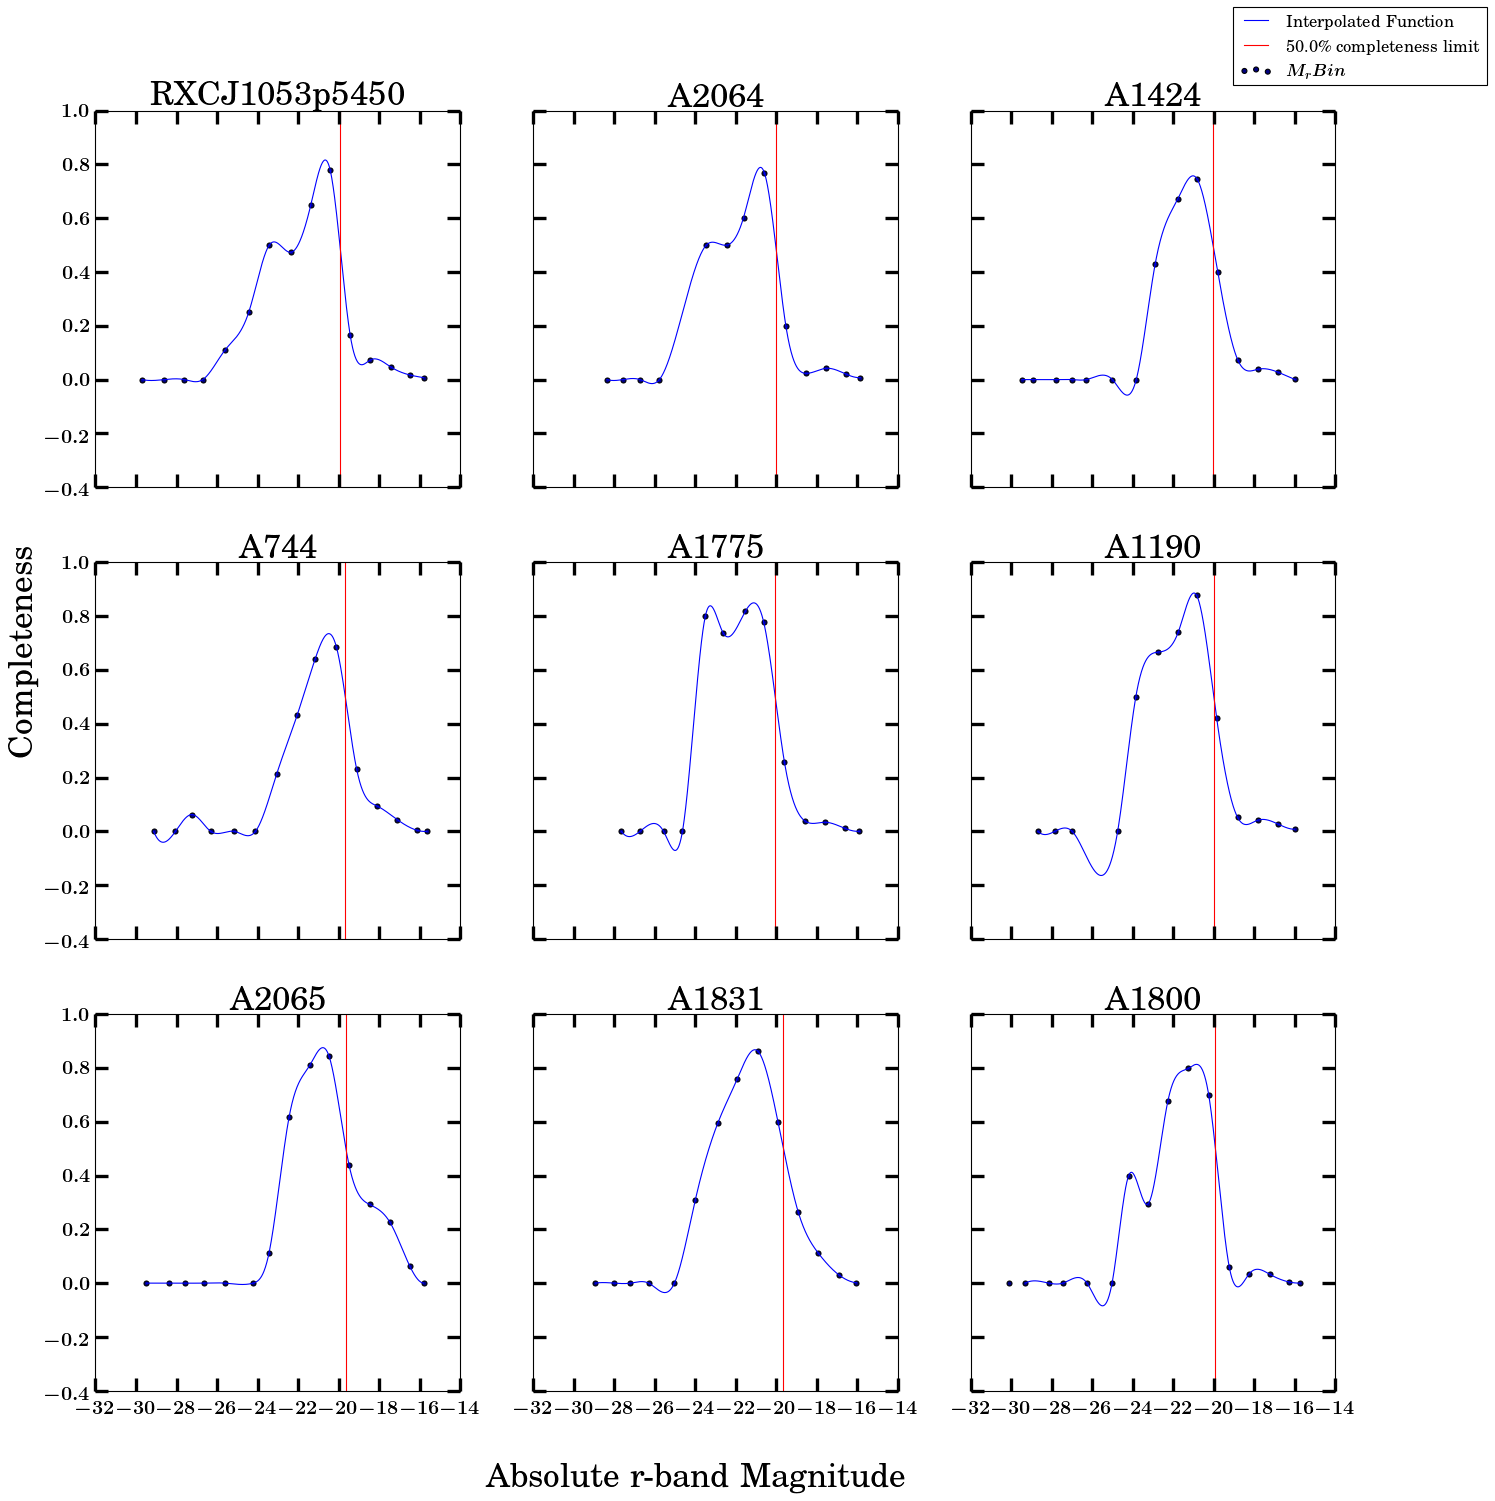

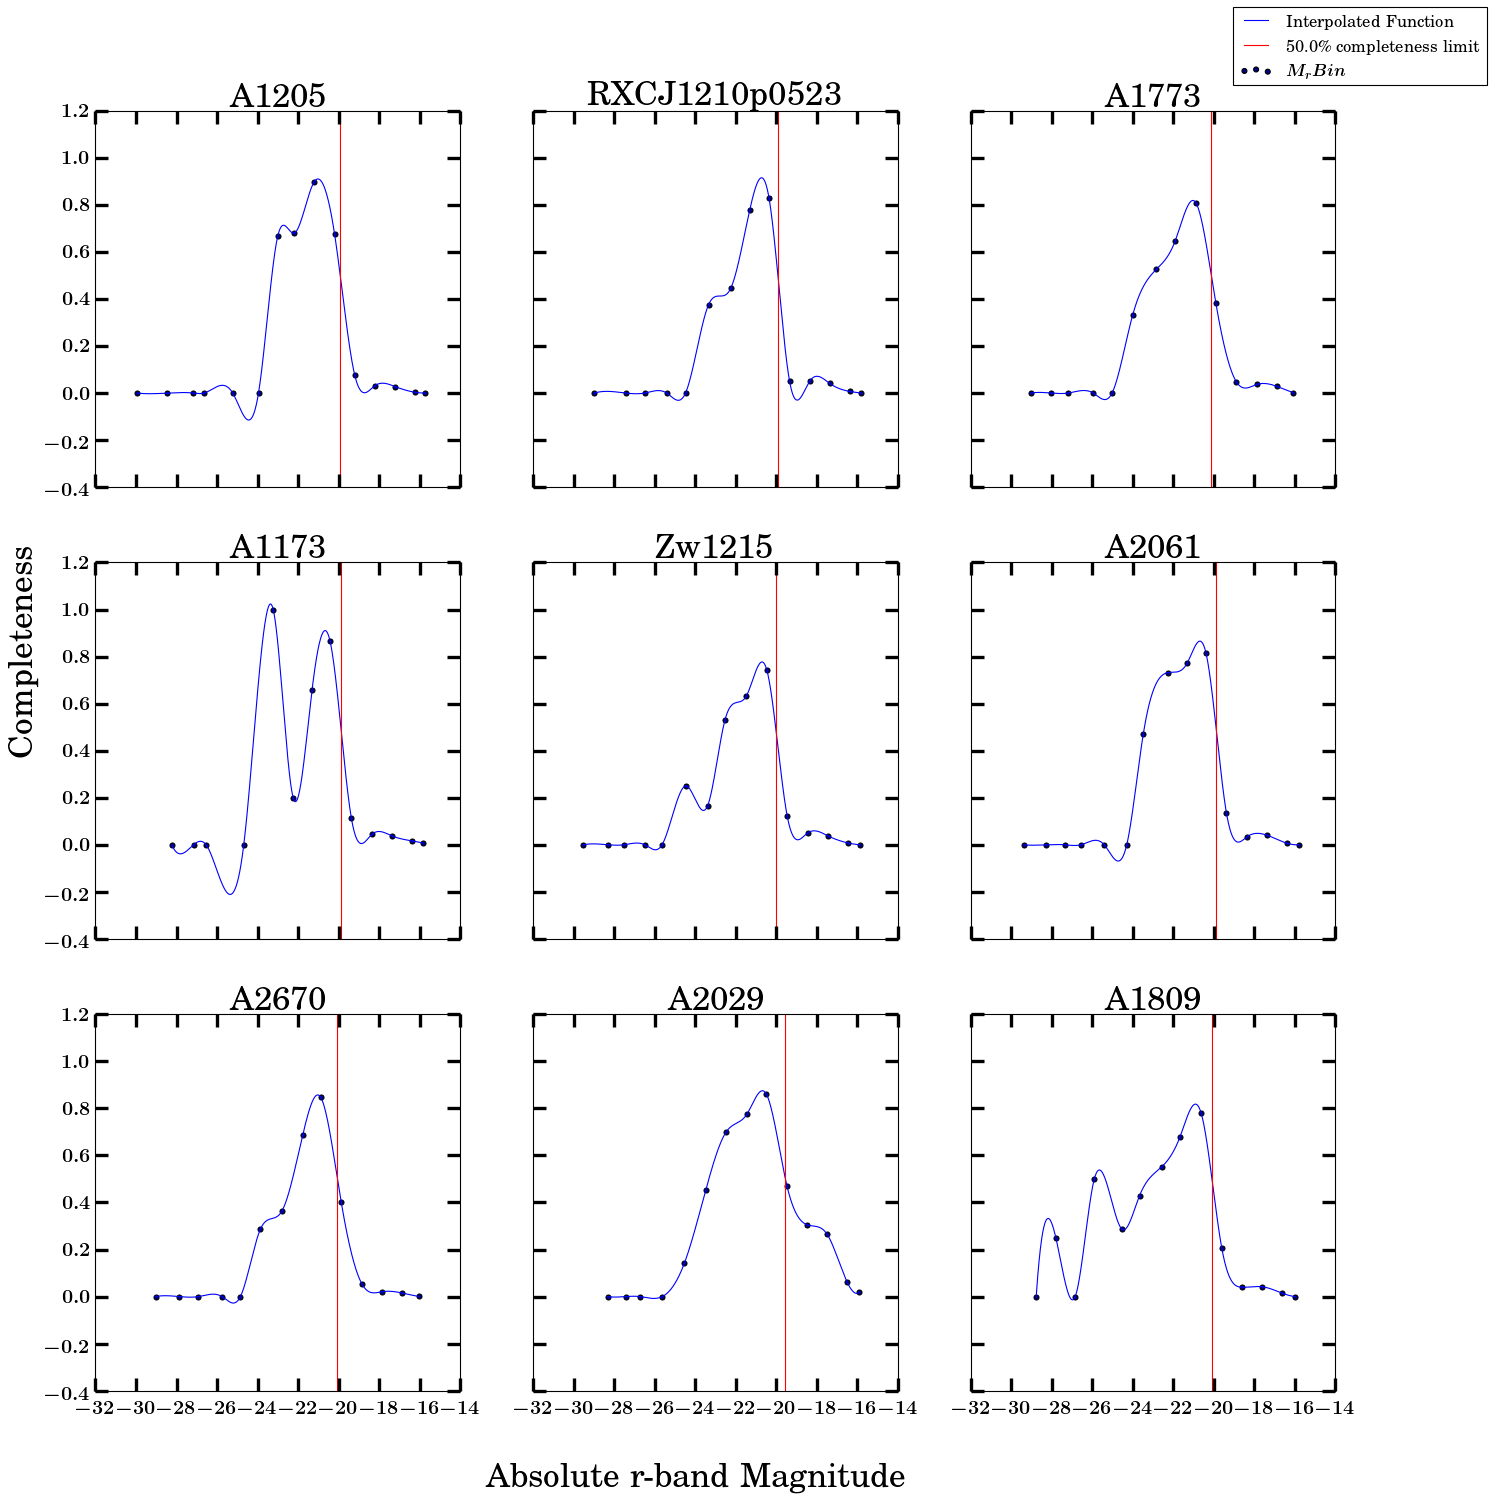

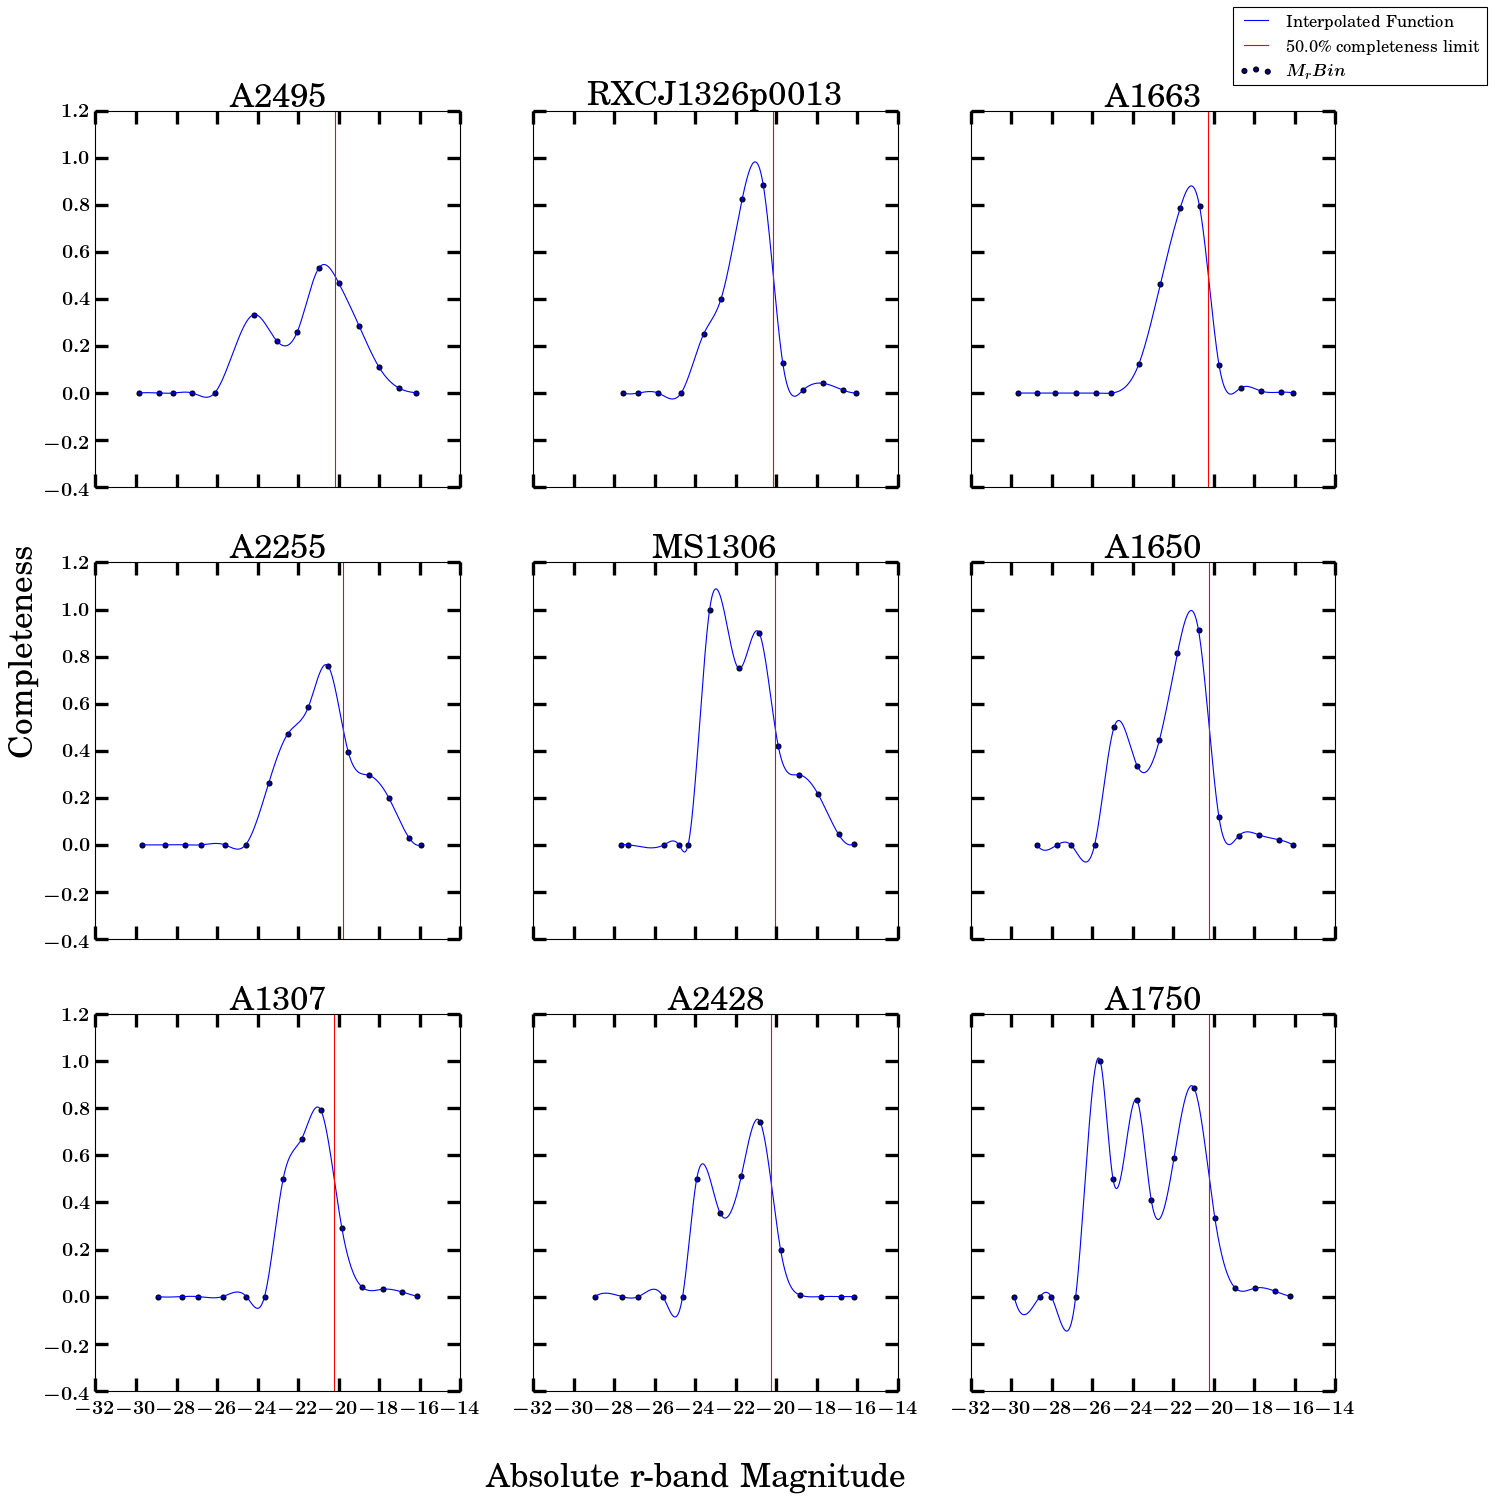

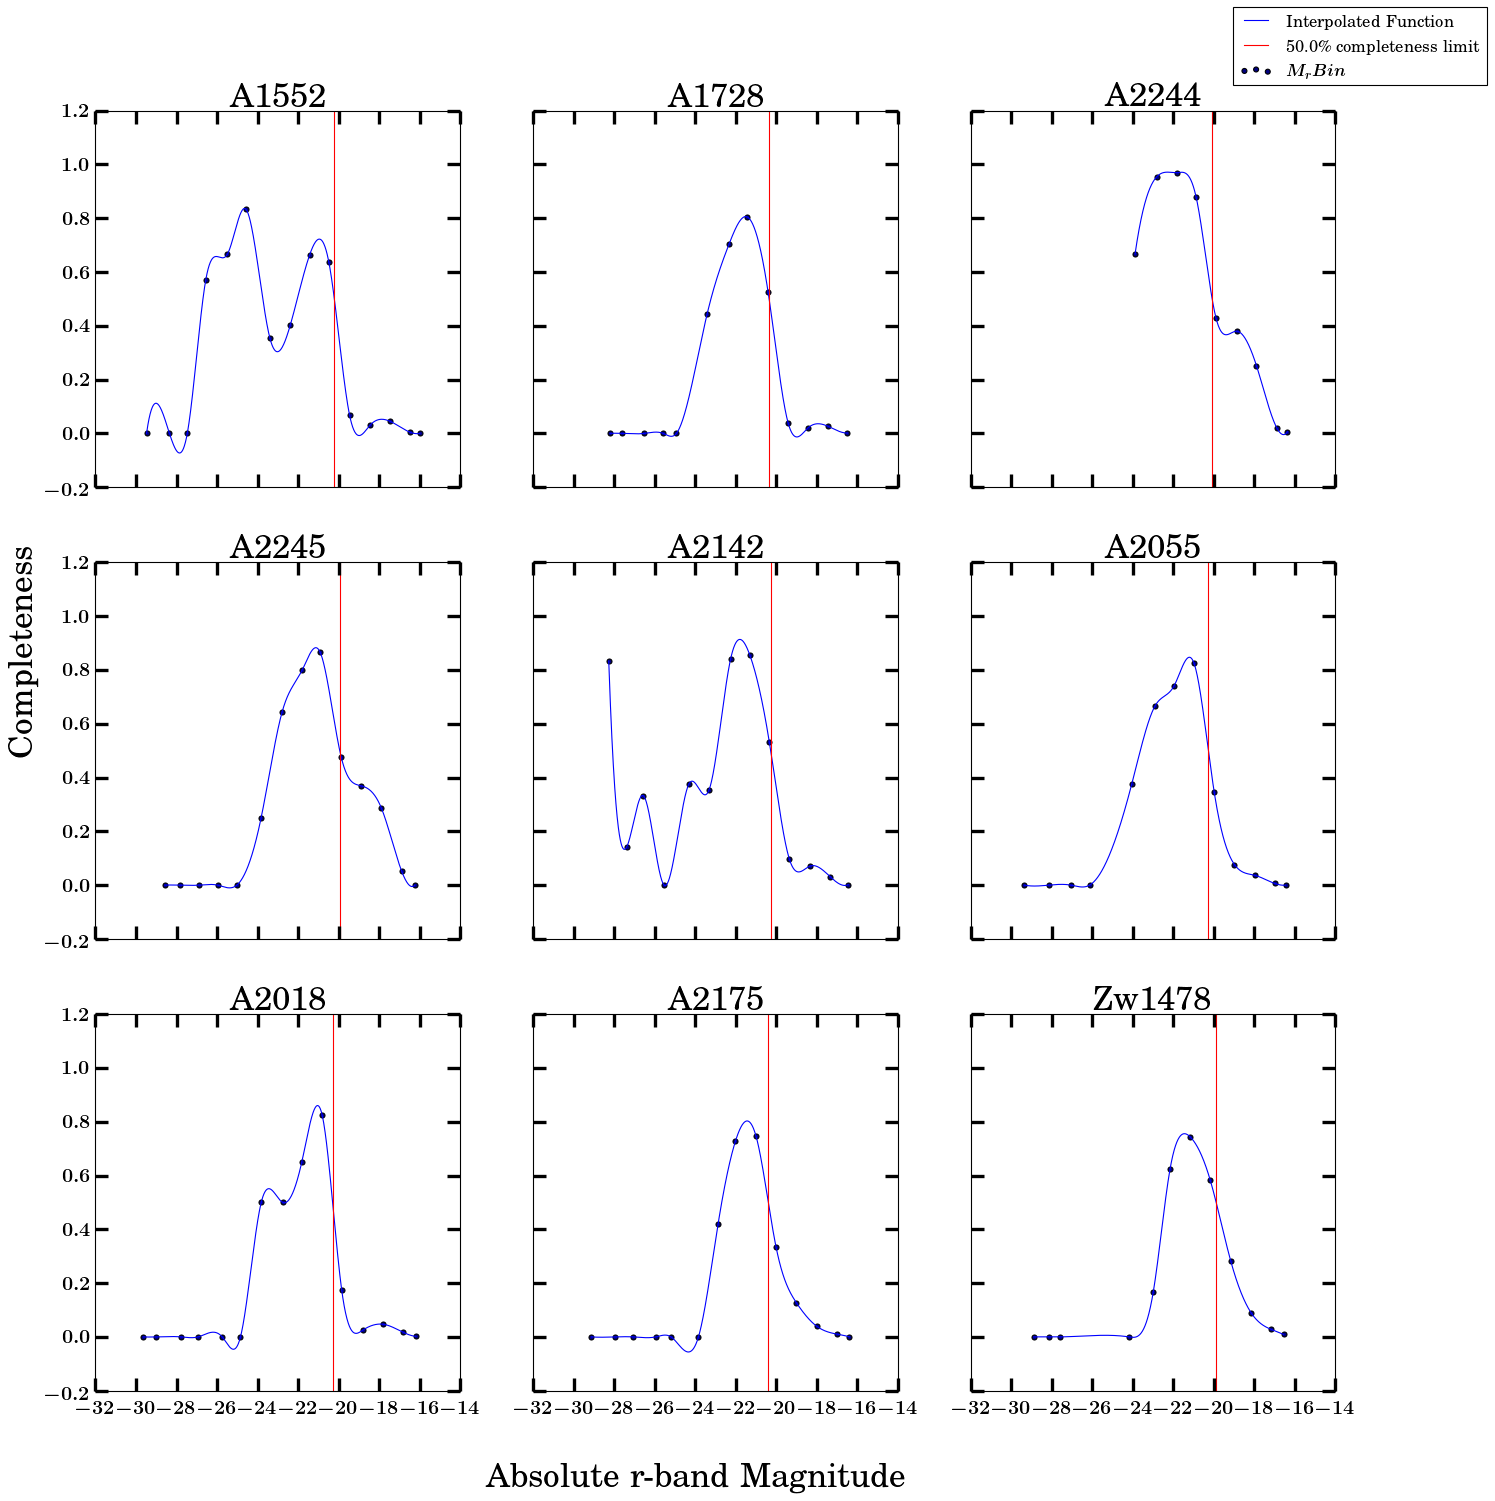

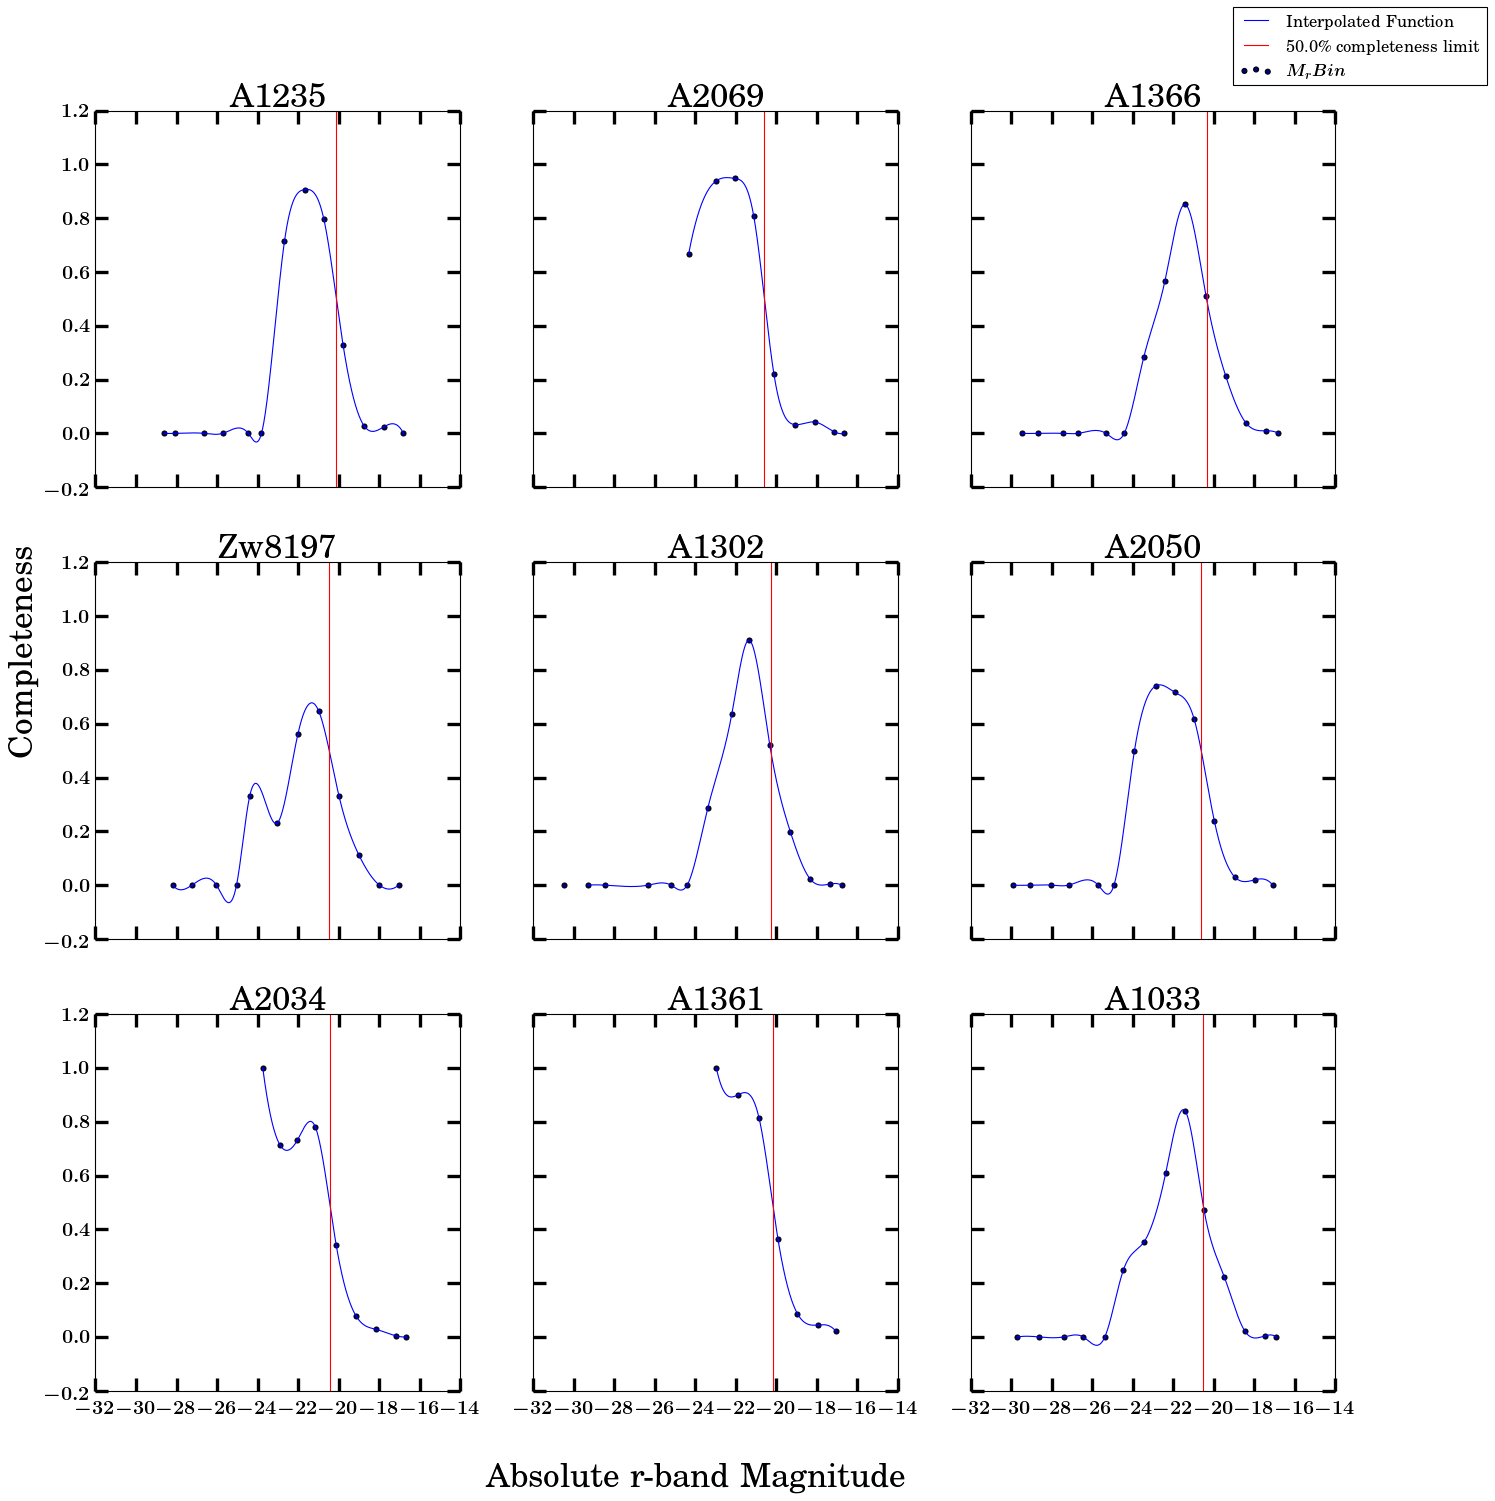

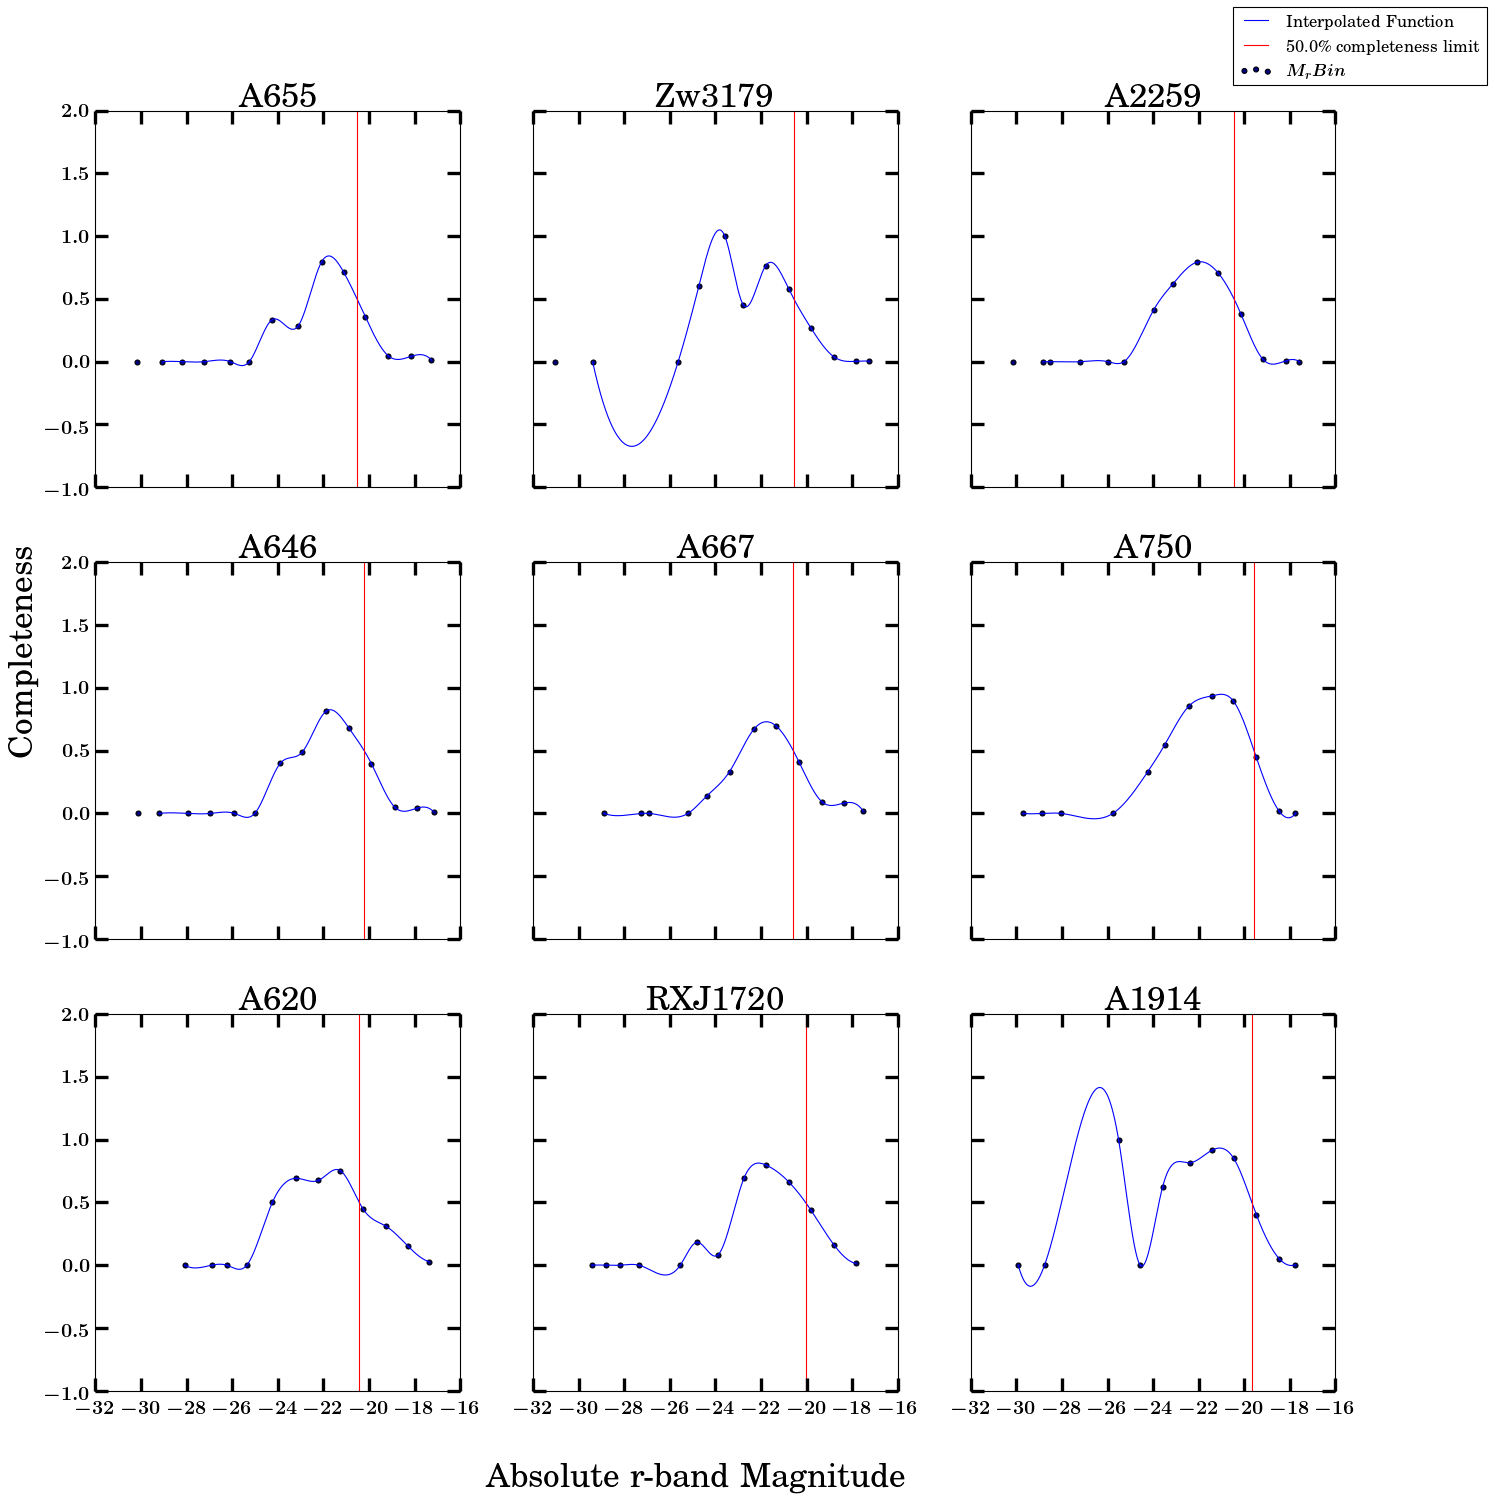

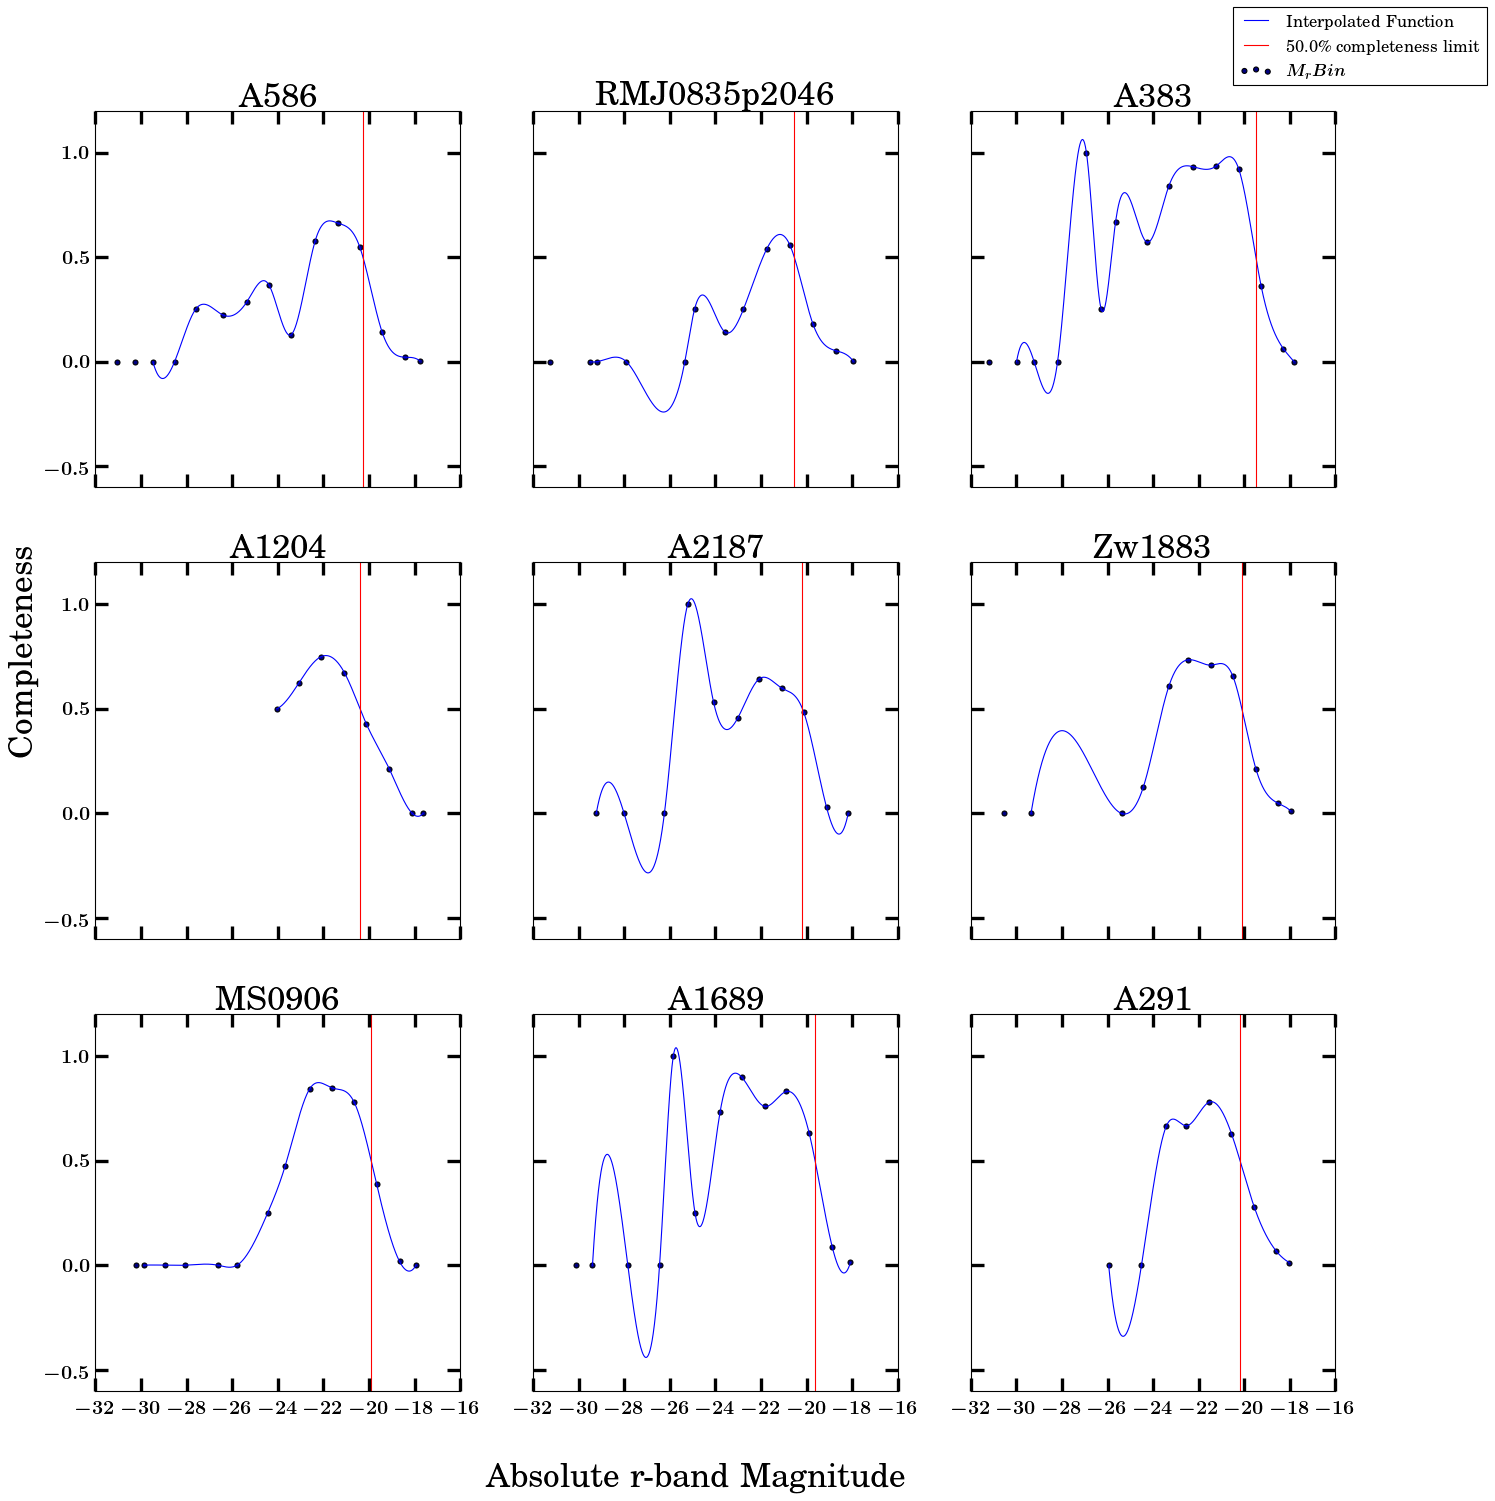

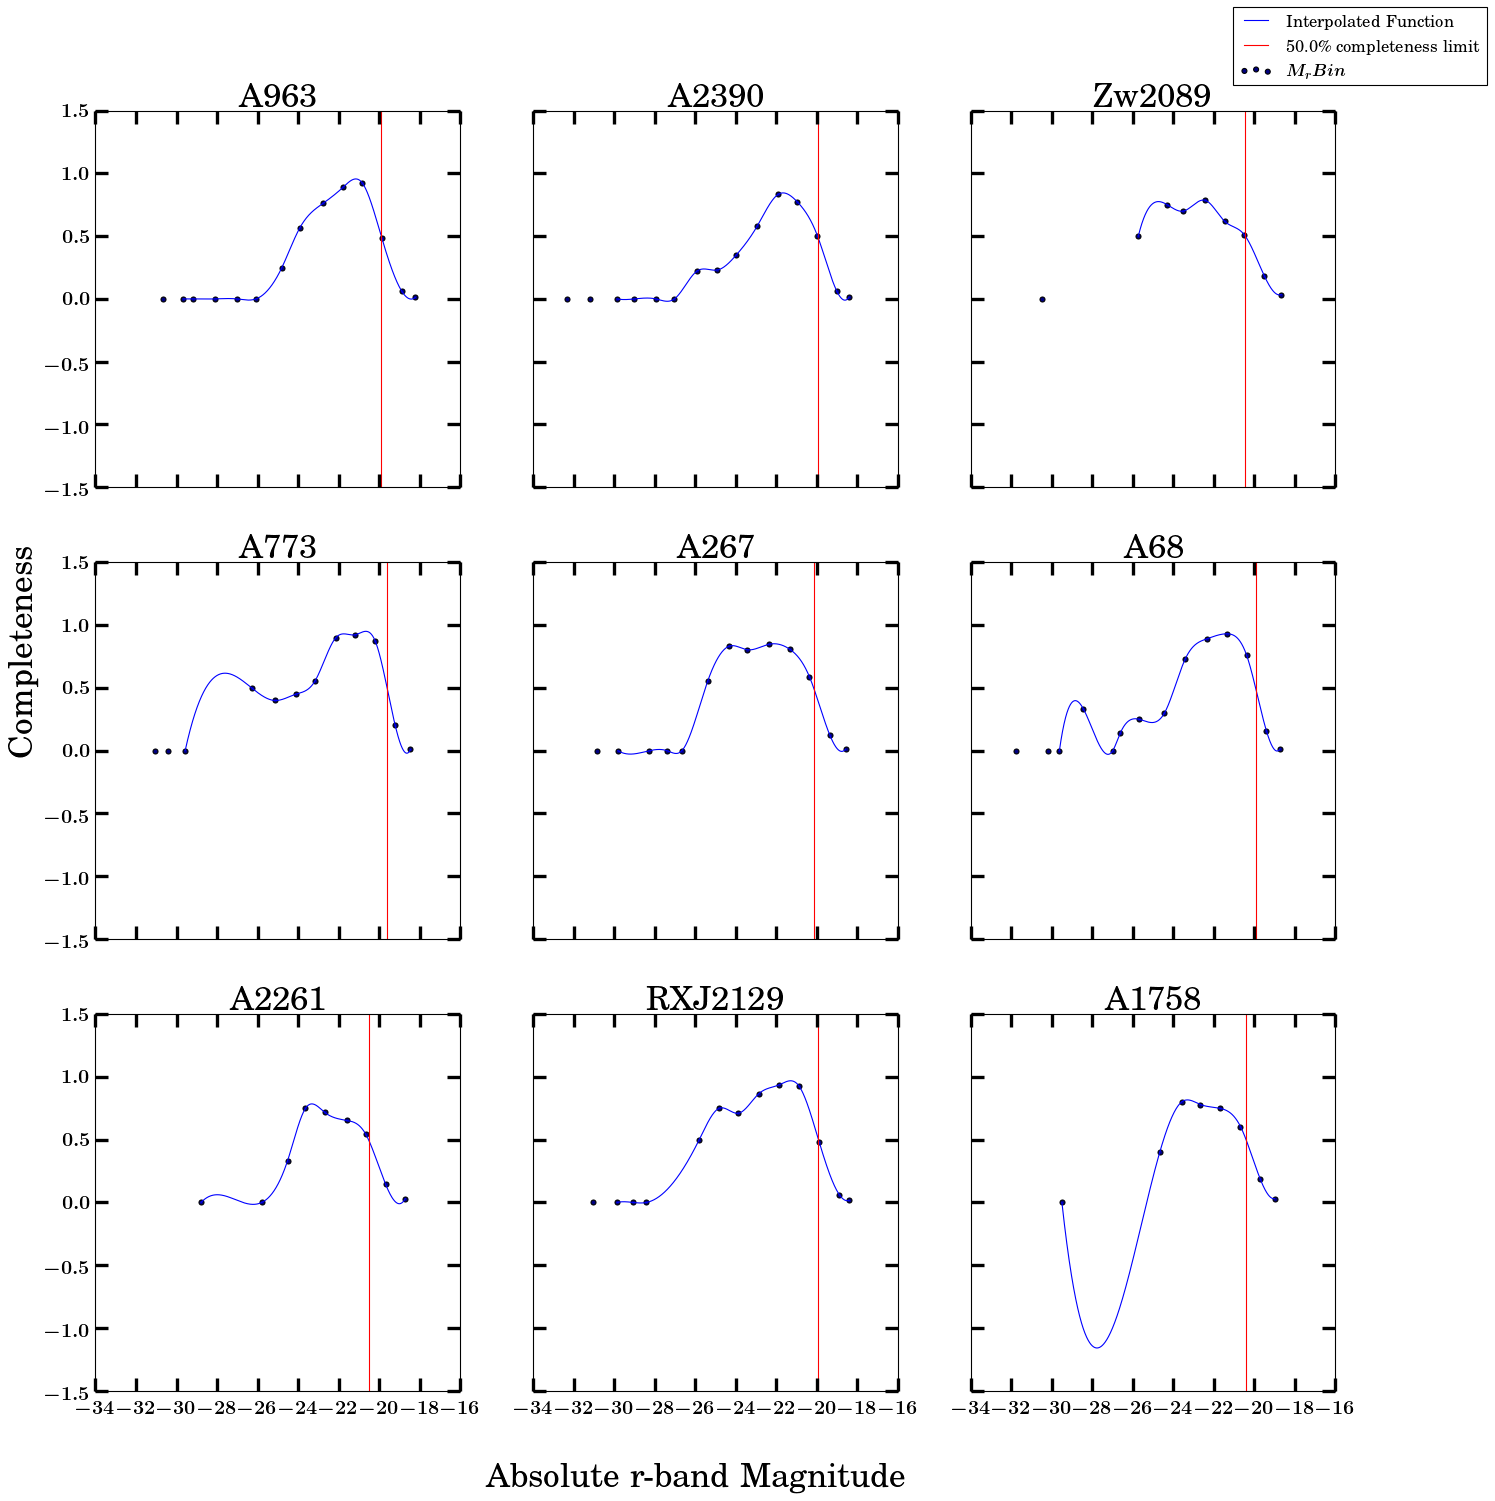

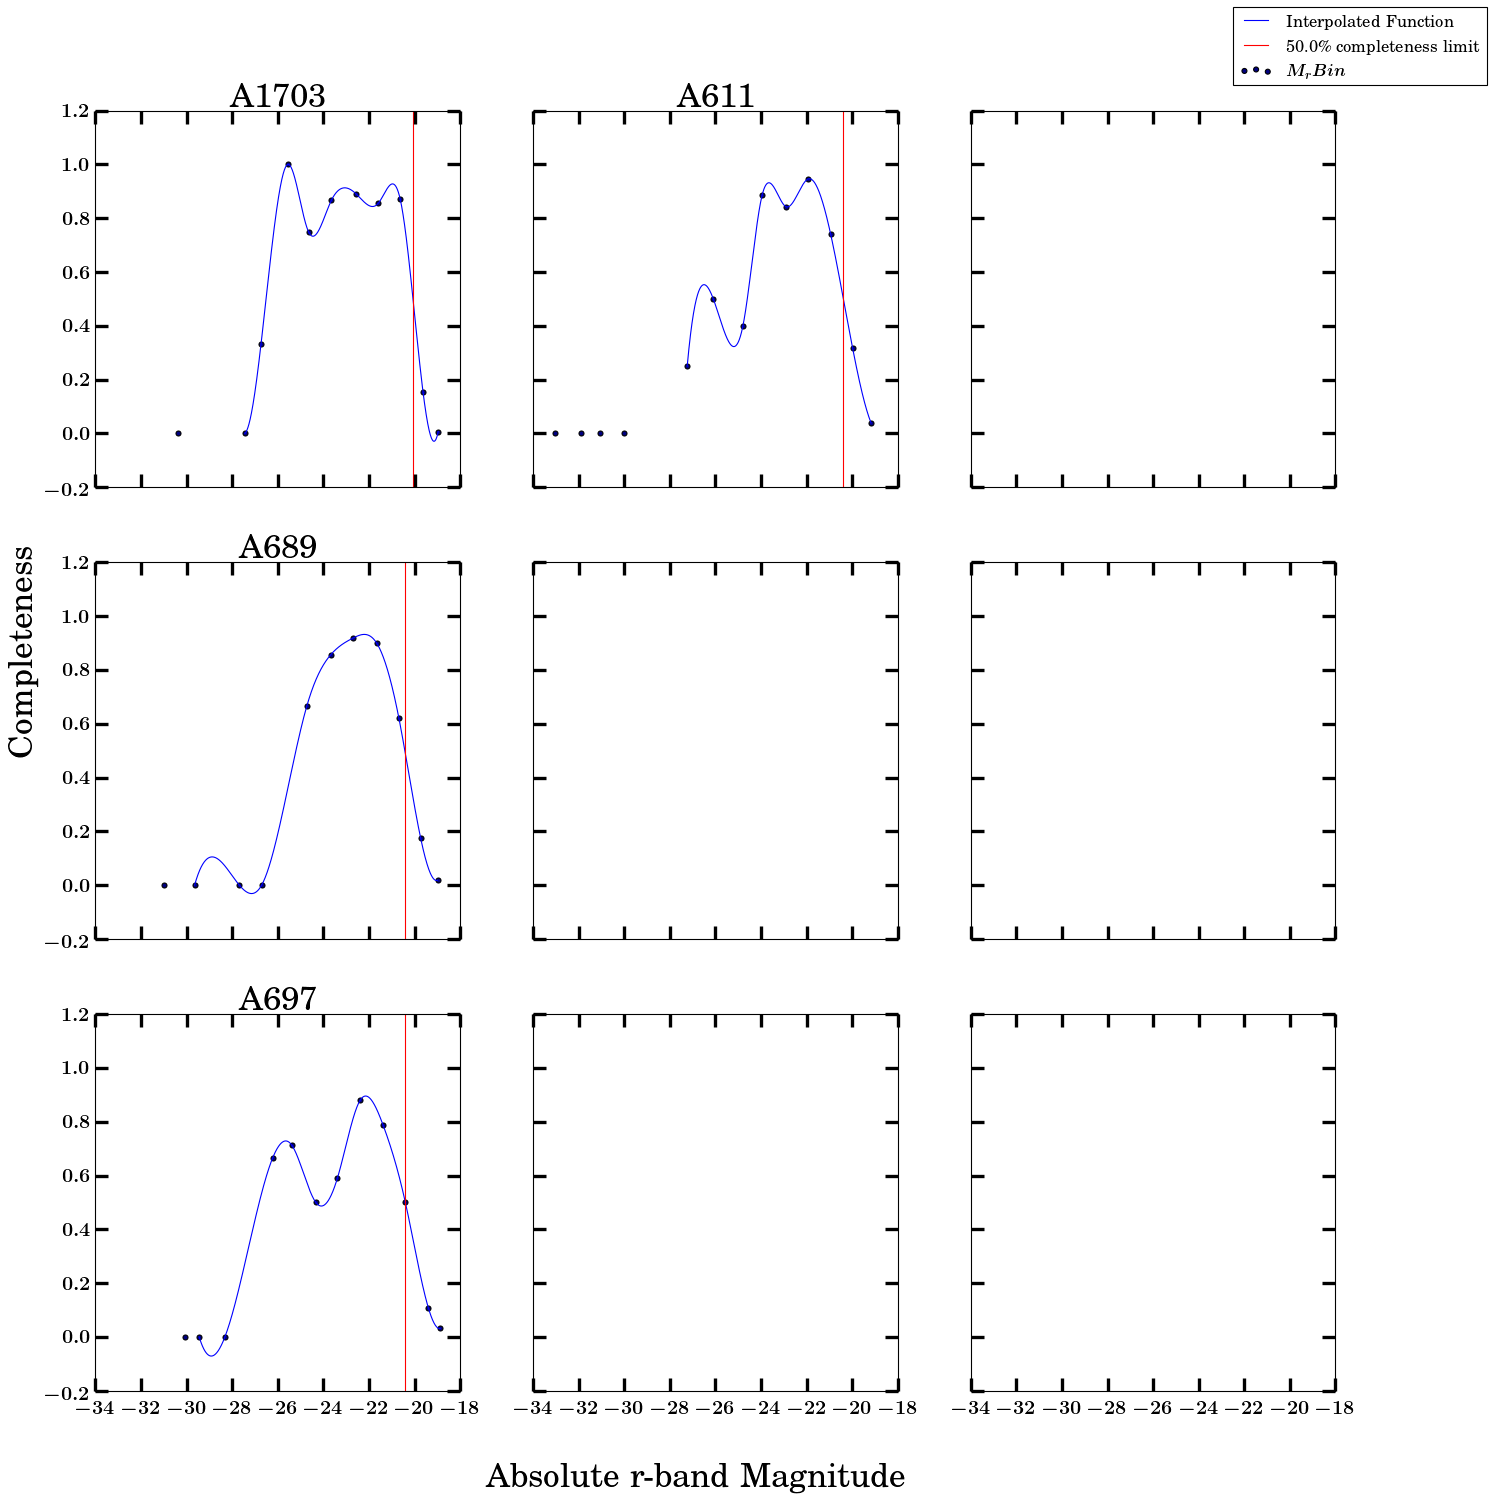

In [13]:
"""
*****************************************************************************
                              Completeness Plots
                                  Absolute Mag
*****************************************************************************
"""
limit50, completenessPlotData = getCompletenessLimit(completnessDict, useAbsMag=True)

numPlotsPerAxis = 3
fig, axs = plt.subplots(numPlotsPerAxis, numPlotsPerAxis, sharey = True, sharex = True, figsize=(20,20))
setLabel = True
for i, cluster in enumerate(completenessPlotData):
    if (i % (numPlotsPerAxis**2) == 0 and i != 0):
        fig.patch.set_facecolor('xkcd:white')
        lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
        lines, labels = [sum(i, []) for i in zip(*lines_labels)]
        fig.legend(lines, labels, bbox_to_anchor = (0,-0.03,1,1), prop={'size': 15})
        fig.text(0.5, 0.04, 'Absolute r-band Magnitude', ha='center', size=30)
        fig.text(0.08, 0.5, 'Completeness', ha='center', size=30, rotation=90) 
        #fig.savefig("CompLimitAbs" + str(i // (numPlotsPerAxis**2)) + ".pdf", bbox_inches='tight')
        fig.show()
        fig, axs = plt.subplots(numPlotsPerAxis, numPlotsPerAxis, sharey = True, sharex = True, figsize=(20,20))
        setLabel = True
        
    rowIndex = i % numPlotsPerAxis
    colIndex = (i // numPlotsPerAxis) % numPlotsPerAxis 
    if(setLabel):
        axs[rowIndex, colIndex].plot(completenessPlotData[cluster][0], completenessPlotData[cluster][1], label="Interpolated Function")
        axs[rowIndex, colIndex].scatter(getAbsMag(np.array(completnessDict[cluster][1]), cluster, lumDistDict), completnessDict[cluster][0], label=r"$M_{r} Bin$", c="navy")
        axs[rowIndex, colIndex].axvline(x=limit50[cluster], c='r', label=f"{completenessLimit * 100.0}\% completeness limit")
        setLabel = False
    else:
        axs[rowIndex, colIndex].plot(completenessPlotData[cluster][0], completenessPlotData[cluster][1])
        axs[rowIndex, colIndex].scatter(getAbsMag(np.array(completnessDict[cluster][1]), cluster, lumDistDict), completnessDict[cluster][0], c="navy")
        axs[rowIndex, colIndex].axvline(x=limit50[cluster], c='r')   
    plotTitle = cluster.replace("_", " ") # LaTeX doesn't like _
    axs[rowIndex, colIndex].set_title(plotTitle)
    
fig.patch.set_facecolor('xkcd:white')
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(i, []) for i in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor = (0,-0.03,1,1), prop={'size': 15})
fig.text(0.5, 0.04, 'Absolute r-band Magnitude', ha='center', size=30)
fig.text(0.08, 0.5, 'Completeness', ha='center', size=30, rotation=90) 
#fig.savefig("CompLimitAbs" + str(i // (numPlotsPerAxis**2)) + ".pdf", bbox_inches='tight')
fig.show()

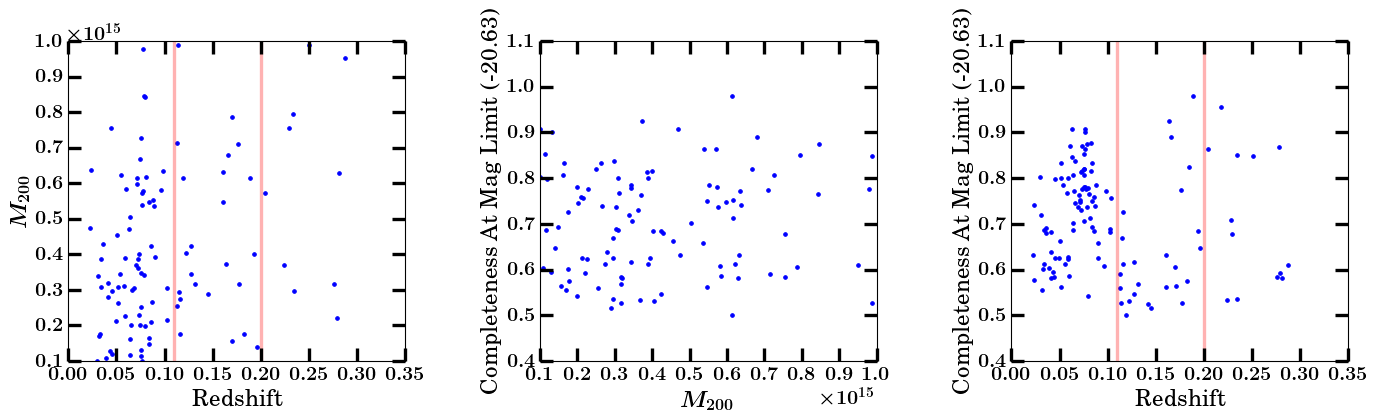

In [14]:
"""
*****************************************************************************
                              Binning Plots
*****************************************************************************
"""
fig, axs = plt.subplots(1, 3, figsize=(20,5))

axs[0].scatter(binningPlotData[0][1], binningPlotData[0][0] , s=10, c='b', edgecolors='b')
axs[0].axvline(x=q[:,1][0], c='r', alpha=0.3, linewidth=3.0)
axs[0].axvline(x=q[:,1][1], c='r', alpha=0.3, linewidth=3.0)
axs[0].set_xlabel("Redshift", size='small')
axs[0].set_ylabel("$M_{200}$", size='small')
axs[0].set_ylim(1e14, 1e15)
axs[1].scatter(binningPlotData[1][0], binningPlotData[1][1] ,s=10, c='b', edgecolors='b')
axs[1].set_xlabel("$M_{200}$", size='small')
axs[1].set_ylabel("Completeness At Mag Limit (" + str(round(MrMax,2)) + ")", size='small')
axs[1].set_xlim(1e14, 1e15)
axs[2].scatter(binningPlotData[2][0], binningPlotData[2][1] ,s=10, c='b', edgecolors='b')
axs[2].axvline(x=q[:,1][0], c='r', alpha=0.3, linewidth=3.0)
axs[2].axvline(x=q[:,1][1], c='r', alpha=0.3, linewidth=3.0)
axs[2].set_xlabel("Redshift", size='small')
axs[2].set_ylabel("Completeness At Mag Limit (" + str(round(MrMax,2)) + ")", size='small')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig.patch.set_facecolor('xkcd:white')
fig.savefig("binningE.pdf", bbox_inches='tight')  
fig.show()

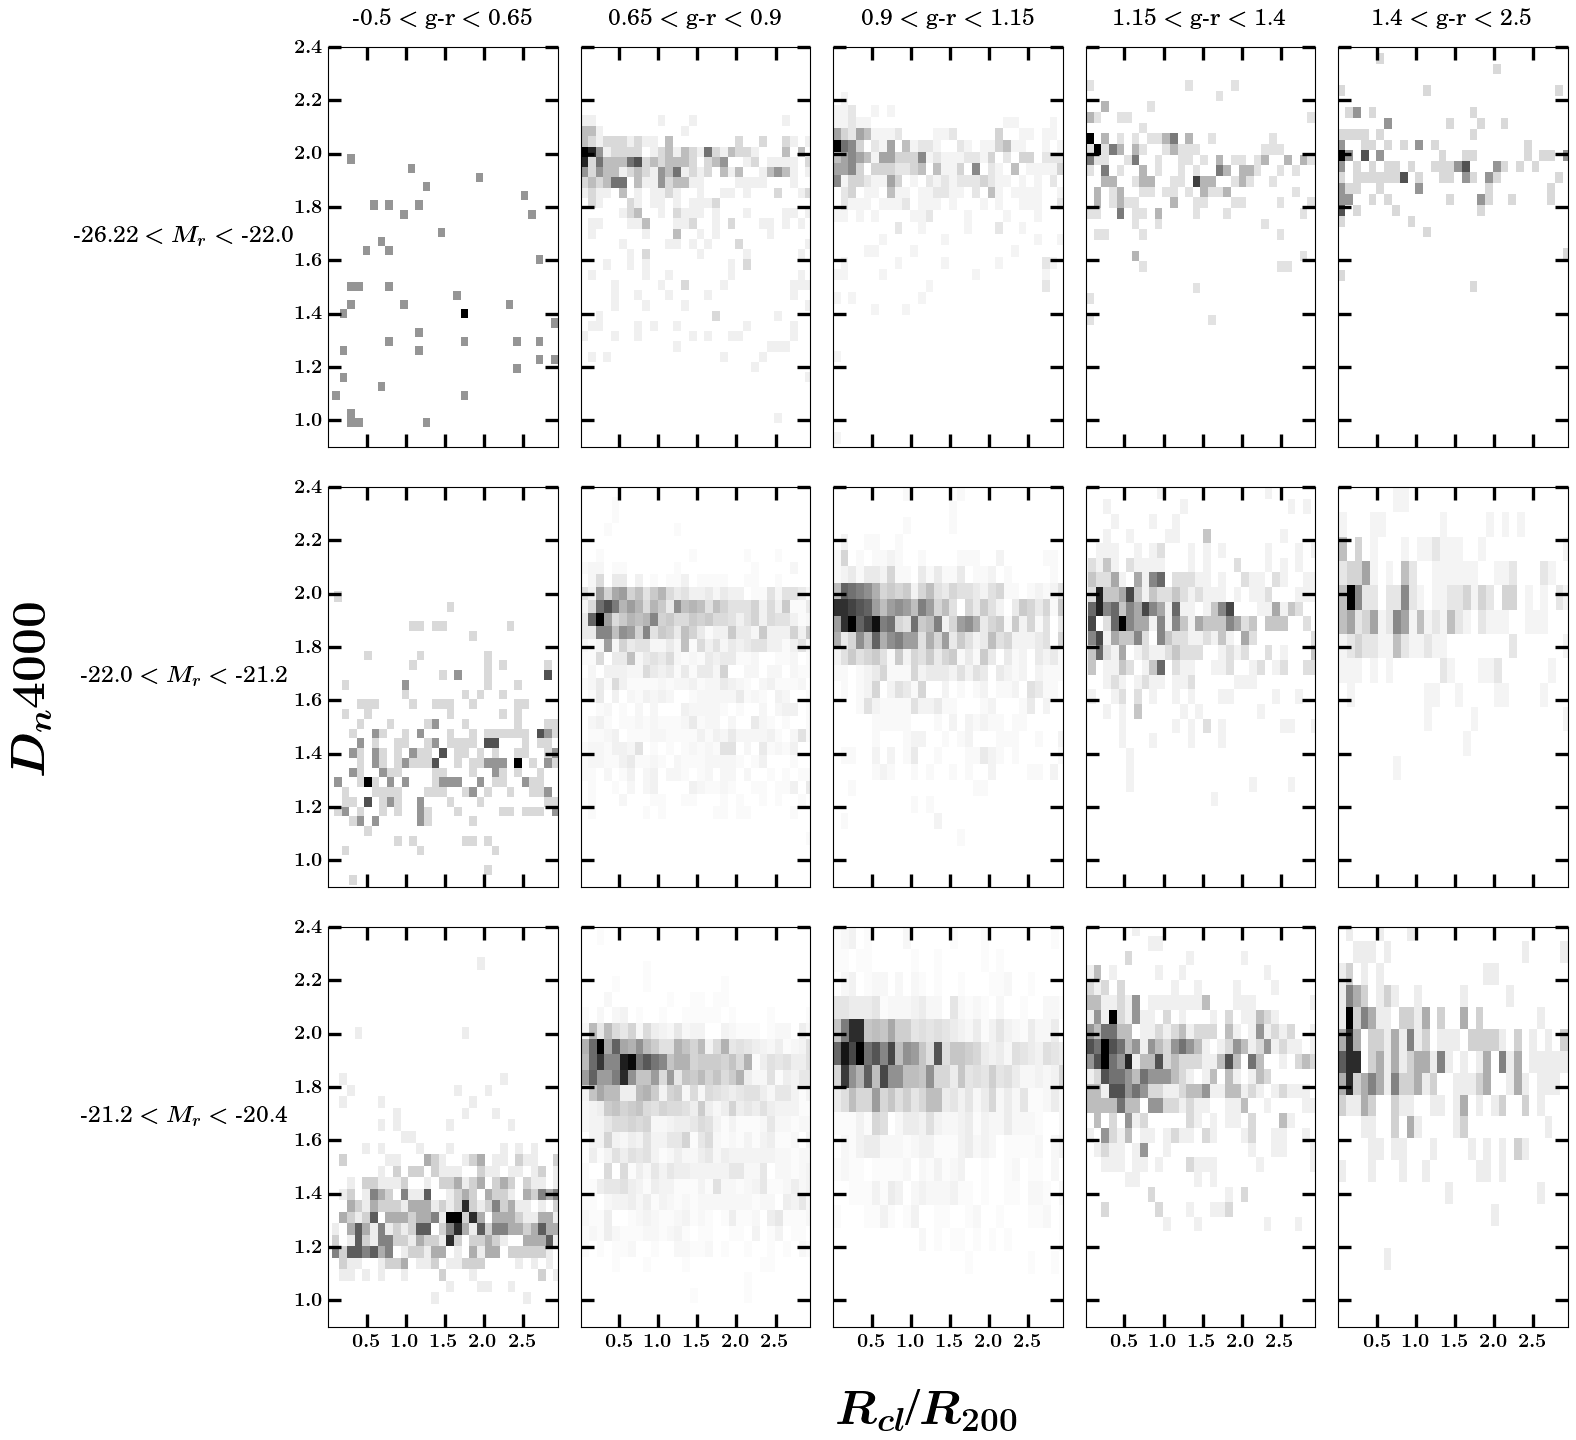

In [15]:
"""
*****************************************************************************
                              Correction Plots
                                 Raw Data
*****************************************************************************
"""
numPlotsPerRow = 5
numPlotsPerCol = 3
fig, axs = plt.subplots(numPlotsPerCol, numPlotsPerRow, sharey = True, sharex = True, figsize=(20,20))

for i, data in enumerate(correctionDistPlotData):
    rowIndex = i % numPlotsPerRow
    colIndex = (i // numPlotsPerRow) % numPlotsPerCol

    counts, xedges, yedges, im = axs[colIndex, rowIndex].hist2d(data[0][0], data[0][1], cmap='Greys', bins=30)
    axs[colIndex, rowIndex].set_ylim(0.9, 2.4)
    
for ax, row in zip(axs[:,0], correctionDistColName):
    ax.set_ylabel(row, rotation=0, labelpad=100, size = 'small')           
for ax, col in zip(axs[0], correctionDistRowName):
    ax.set_title(col, pad=20, size = 'small')  
    
fig.patch.set_facecolor('xkcd:white')  
plt.subplots_adjust(wspace=.1, hspace=.1)

fig.text(0.5, 0.04, r'$R_{cl}$/$R_{200}$', ha='center', size='xx-large')
fig.text(-0.075, 0.5, r'$D_{n}4000$', va='center', size='xx-large', rotation=90)
    
#fig.savefig("Dn4000Dist.pdf", bbox_inches='tight')
fig.show()

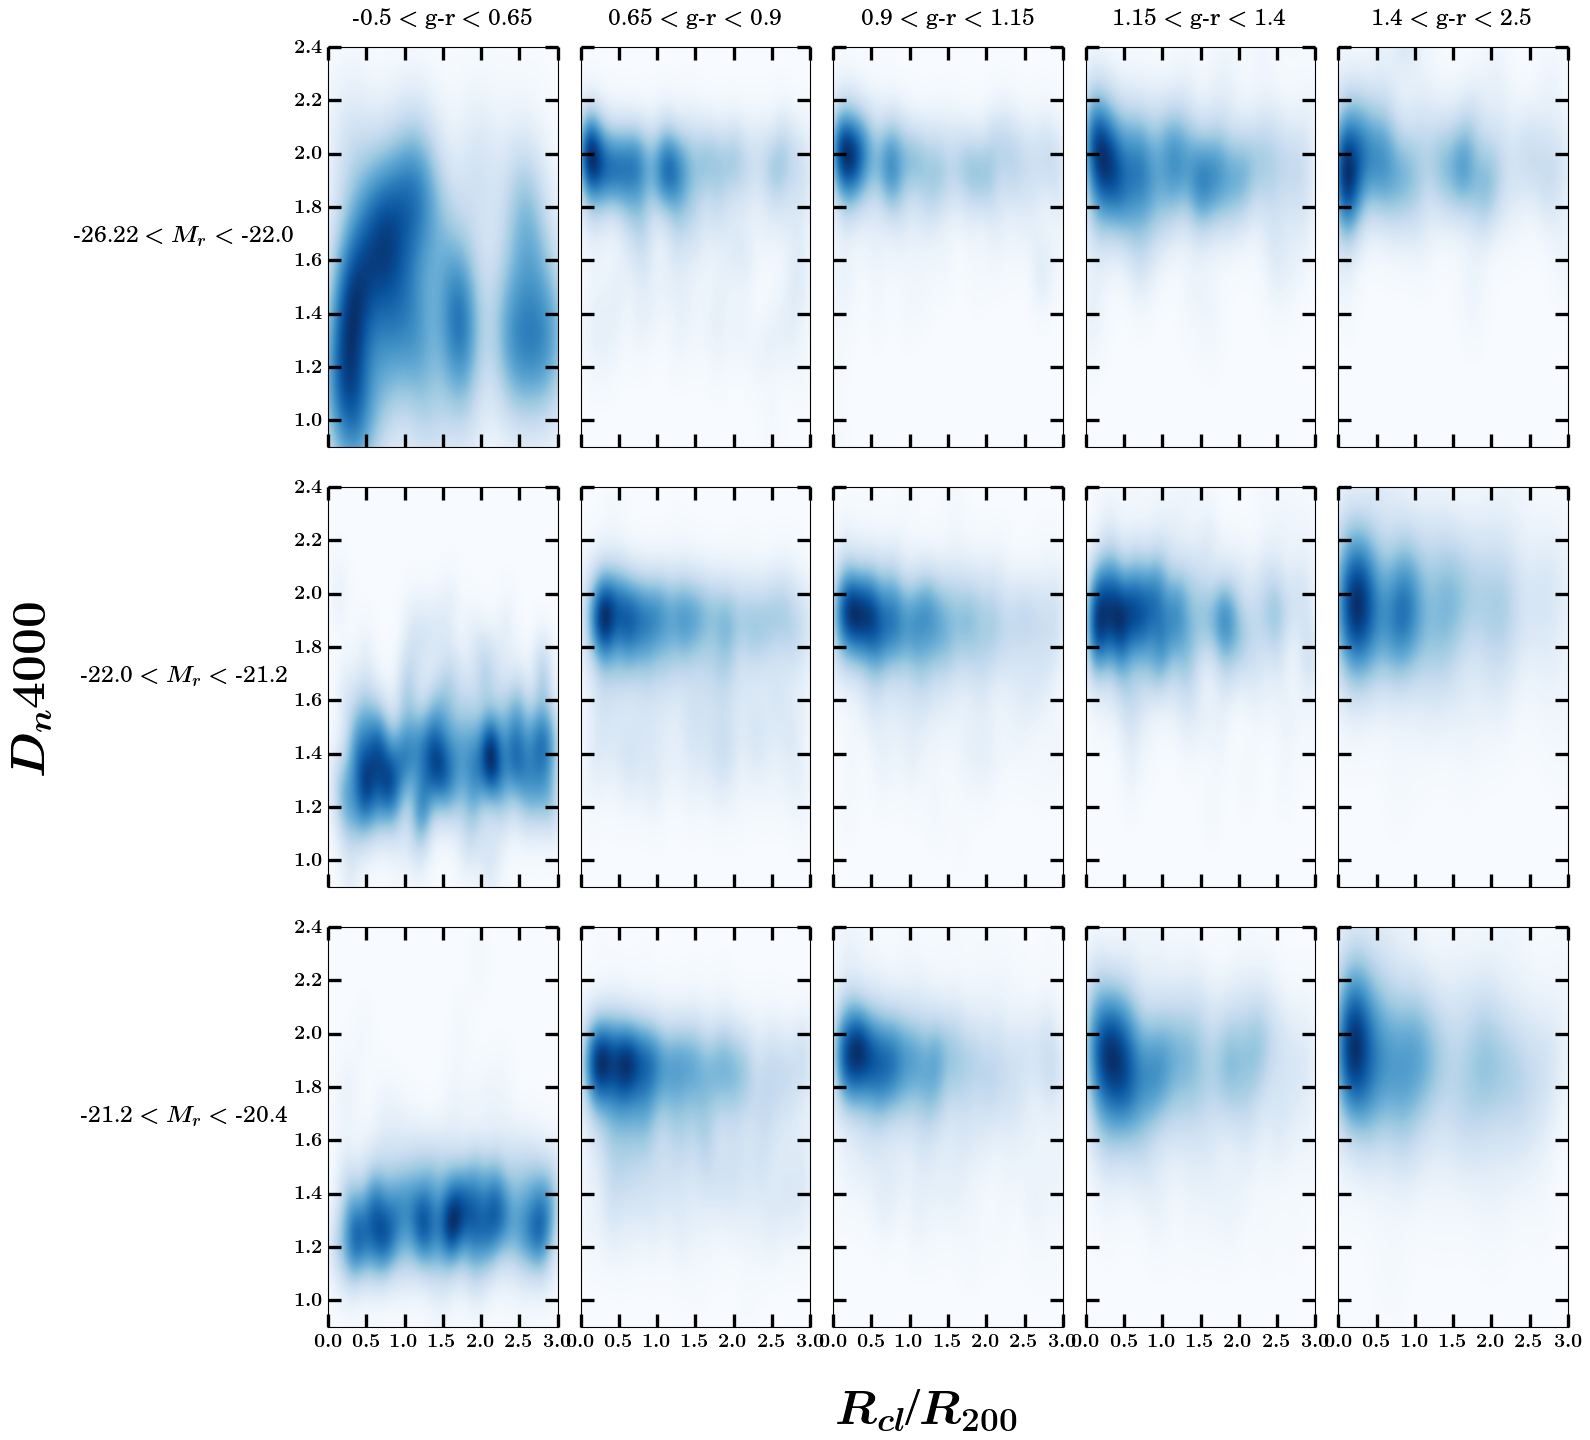

In [16]:
"""
*****************************************************************************
                              Correction Plots
                            Probability Distribution
*****************************************************************************
"""
numPlotsPerRow = 5
numPlotsPerCol = 3
fig, axs = plt.subplots(numPlotsPerCol, numPlotsPerRow, sharey = True, sharex = True, figsize=(20,20))

for i, data in enumerate(correctionDistPlotData):
    rowIndex = i % numPlotsPerRow
    colIndex = (i // numPlotsPerRow) % numPlotsPerCol

    im = axs[colIndex, rowIndex].imshow(data[1], origin='lower', aspect='auto', extent=[0, 3, 0.9, 2.5], cmap='Blues')
    axs[colIndex, rowIndex].set_ylim(0.9, 2.4)
    
for ax, row in zip(axs[:,0], correctionDistColName):
    ax.set_ylabel(row, rotation=0, labelpad=100, size = 'small')          
for ax, col in zip(axs[0], correctionDistRowName):
    ax.set_title(col, pad=20, size = 'small')  
    
fig.patch.set_facecolor('xkcd:white')  
plt.subplots_adjust(wspace=.1, hspace=.1)

fig.text(0.5, 0.04, r'$R_{cl}$/$R_{200}$', ha='center', size='xx-large')
fig.text(-0.075, 0.5, r'$D_{n}4000$', va='center', size='xx-large', rotation=90) 
    
#fig.savefig("Dn4000Dist.pdf", bbox_inches='tight')
fig.show()

In [17]:
"""
*****************************************************************************
                              Correction Plots
                                Table 1.1 Data
*****************************************************************************
"""
print(binStats)

[[[3942   46  920  333]
  [2398  474 1695  287]
  [1515  444 1130  183]
  [ 698  199  448   51]
  [ 661  130  229   51]]

 [[2137  274 1431  126]
  [3548 1609 3195  106]
  [2750 1180 2482   70]
  [1404  568 1204   50]
  [ 981  268  656   52]]

 [[3174  579 2154  213]
  [4883 2130 4261  193]
  [3745 1338 3209  180]
  [1910  645 1555   88]
  [1487  316 1054   60]]

 [[   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]]

 [[   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]
  [   0    0    0    0]]]


Magnitude Limit:  -20.621929593809117


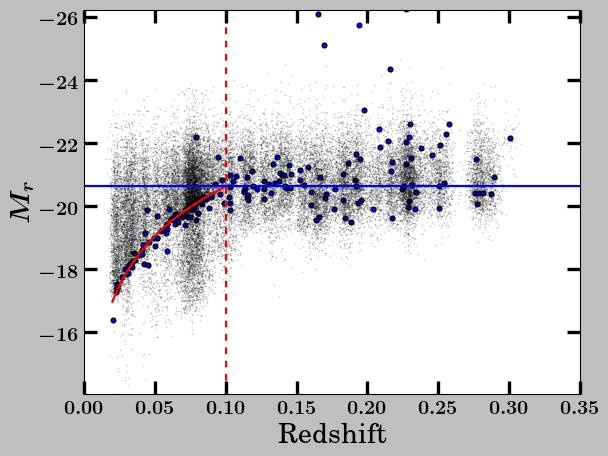

In [18]:
"""
*****************************************************************************
                              Magnitude Limit Plots
*****************************************************************************
"""
print("Magnitude Limit: ", MrLimit)
plt.ylabel("$M_{r}$")
plt.xlabel("Redshift")
plt.scatter(magLimitPlotData[0][0], magLimitPlotData[0][1], c='blue', s=20)
plt.scatter(magLimitPlotData[1][0], magLimitPlotData[1][1], s=0.01, c='blue')
plt.plot(magLimitPlotData[2][0], magLimitPlotData[2][1], color='red', lw=2)
plt.axhline(y=MrLimit, c='blue', lw=2)
plt.axvline(x=0.1, c='red', ls='--', lw=2)
plt.ylim(np.min(magLimitPlotData[1][1]), np.max(magLimitPlotData[1][1]))
plt.gca().invert_yaxis()


#plt.savefig("MagLimit.pdf", bbox_inches='tight')
plt.show()

100%|██████████████████████|Calculating the Completeness Limit for Each Cluster


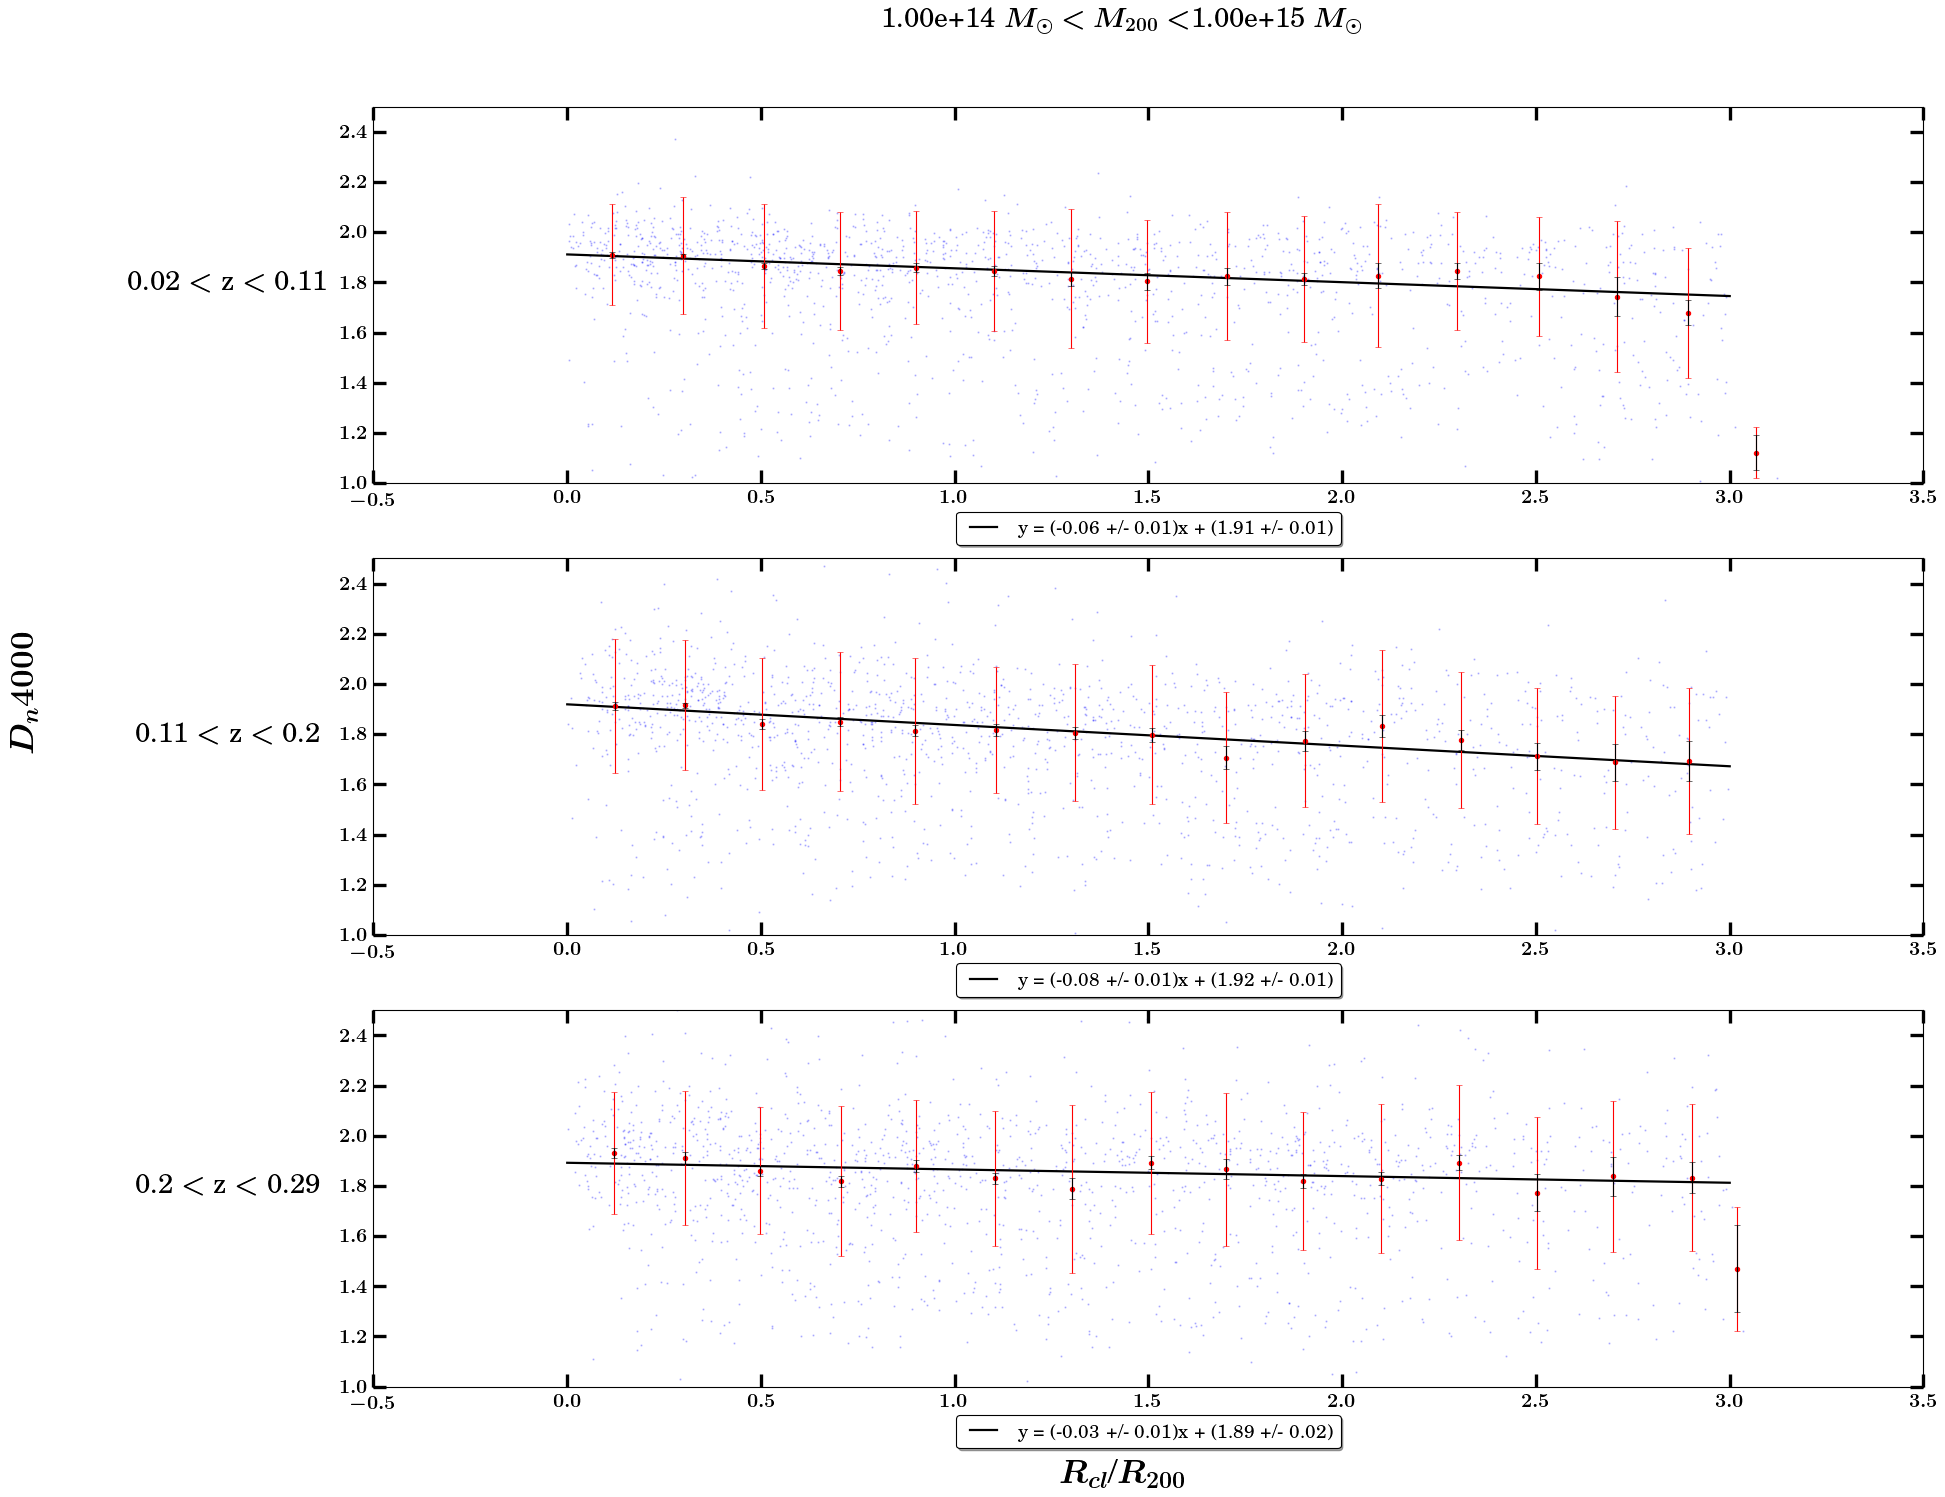

In [19]:
"""
*****************************************************************************
                              Dn4000 Trend Plots
                                    Rnorm
*****************************************************************************
"""
slope, serr, intercept, ierr, dn4000RowName, dn4000ColName, dn4000PlotData = generateDn4000vsRnormPlots(plotDataDict, completnessDict, errorMethod = "std", xproj = 'Rnorm', dataIndex = 1)

fig, axs = plt.subplots(3, 1, figsize=(25,20))
for i, data in enumerate(dn4000PlotData):
    axs[i].scatter(dn4000PlotData[i][0][0], dn4000PlotData[i][0][1], s = 1, alpha=0.2, c='b', edgecolors='b')
    axs[i].scatter(dn4000PlotData[i][1][0], dn4000PlotData[i][1][1], s = 15, c='r',zorder=10, edgecolors='r')
    axs[i].errorbar(dn4000PlotData[i][1][0], dn4000PlotData[i][1][1], yerr=dn4000PlotData[i][1][3], alpha = 1, c='r', linestyle='none',zorder=10)
    axs[i].errorbar(dn4000PlotData[i][1][0], dn4000PlotData[i][1][1], yerr=dn4000PlotData[i][1][2], alpha = 1, c='black', linestyle='none',zorder=10)
    axs[i].plot(dn4000PlotData[i][2][0], dn4000PlotData[i][2][1], c='black', linewidth=2.0, label="y = ({slope:.2f} +/- {serr:.2f})x + ({intercept:.2f} +/- {ierr:.2f})".format(slope = slope[i][0], serr= serr[i][0], intercept = intercept[i][0], ierr = ierr[i][0]))
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, fontsize = 'x-small')
    axs[i].set_ylim((1, 2.5))

fig.patch.set_facecolor('xkcd:white') 
fig.text(0.5, 0.04, '$R_{cl}$/$R_{200}$', ha='center', size=30)   
fig.text(-0.05, 0.5, '$D_{n}4000$', ha='center', size=30, rotation=90)
fig.text(0.5, 0.95, dn4000RowName[0], ha='center')
for ax, row in zip(axs, dn4000ColName):
    ax.set_ylabel(row, rotation=0, labelpad=100)
    
#fig.savefig("Dn4000Rnorm.pdf", bbox_inches='tight')
fig.show()

100%|██████████████████████|Calculating the Completeness Limit for Each Cluster


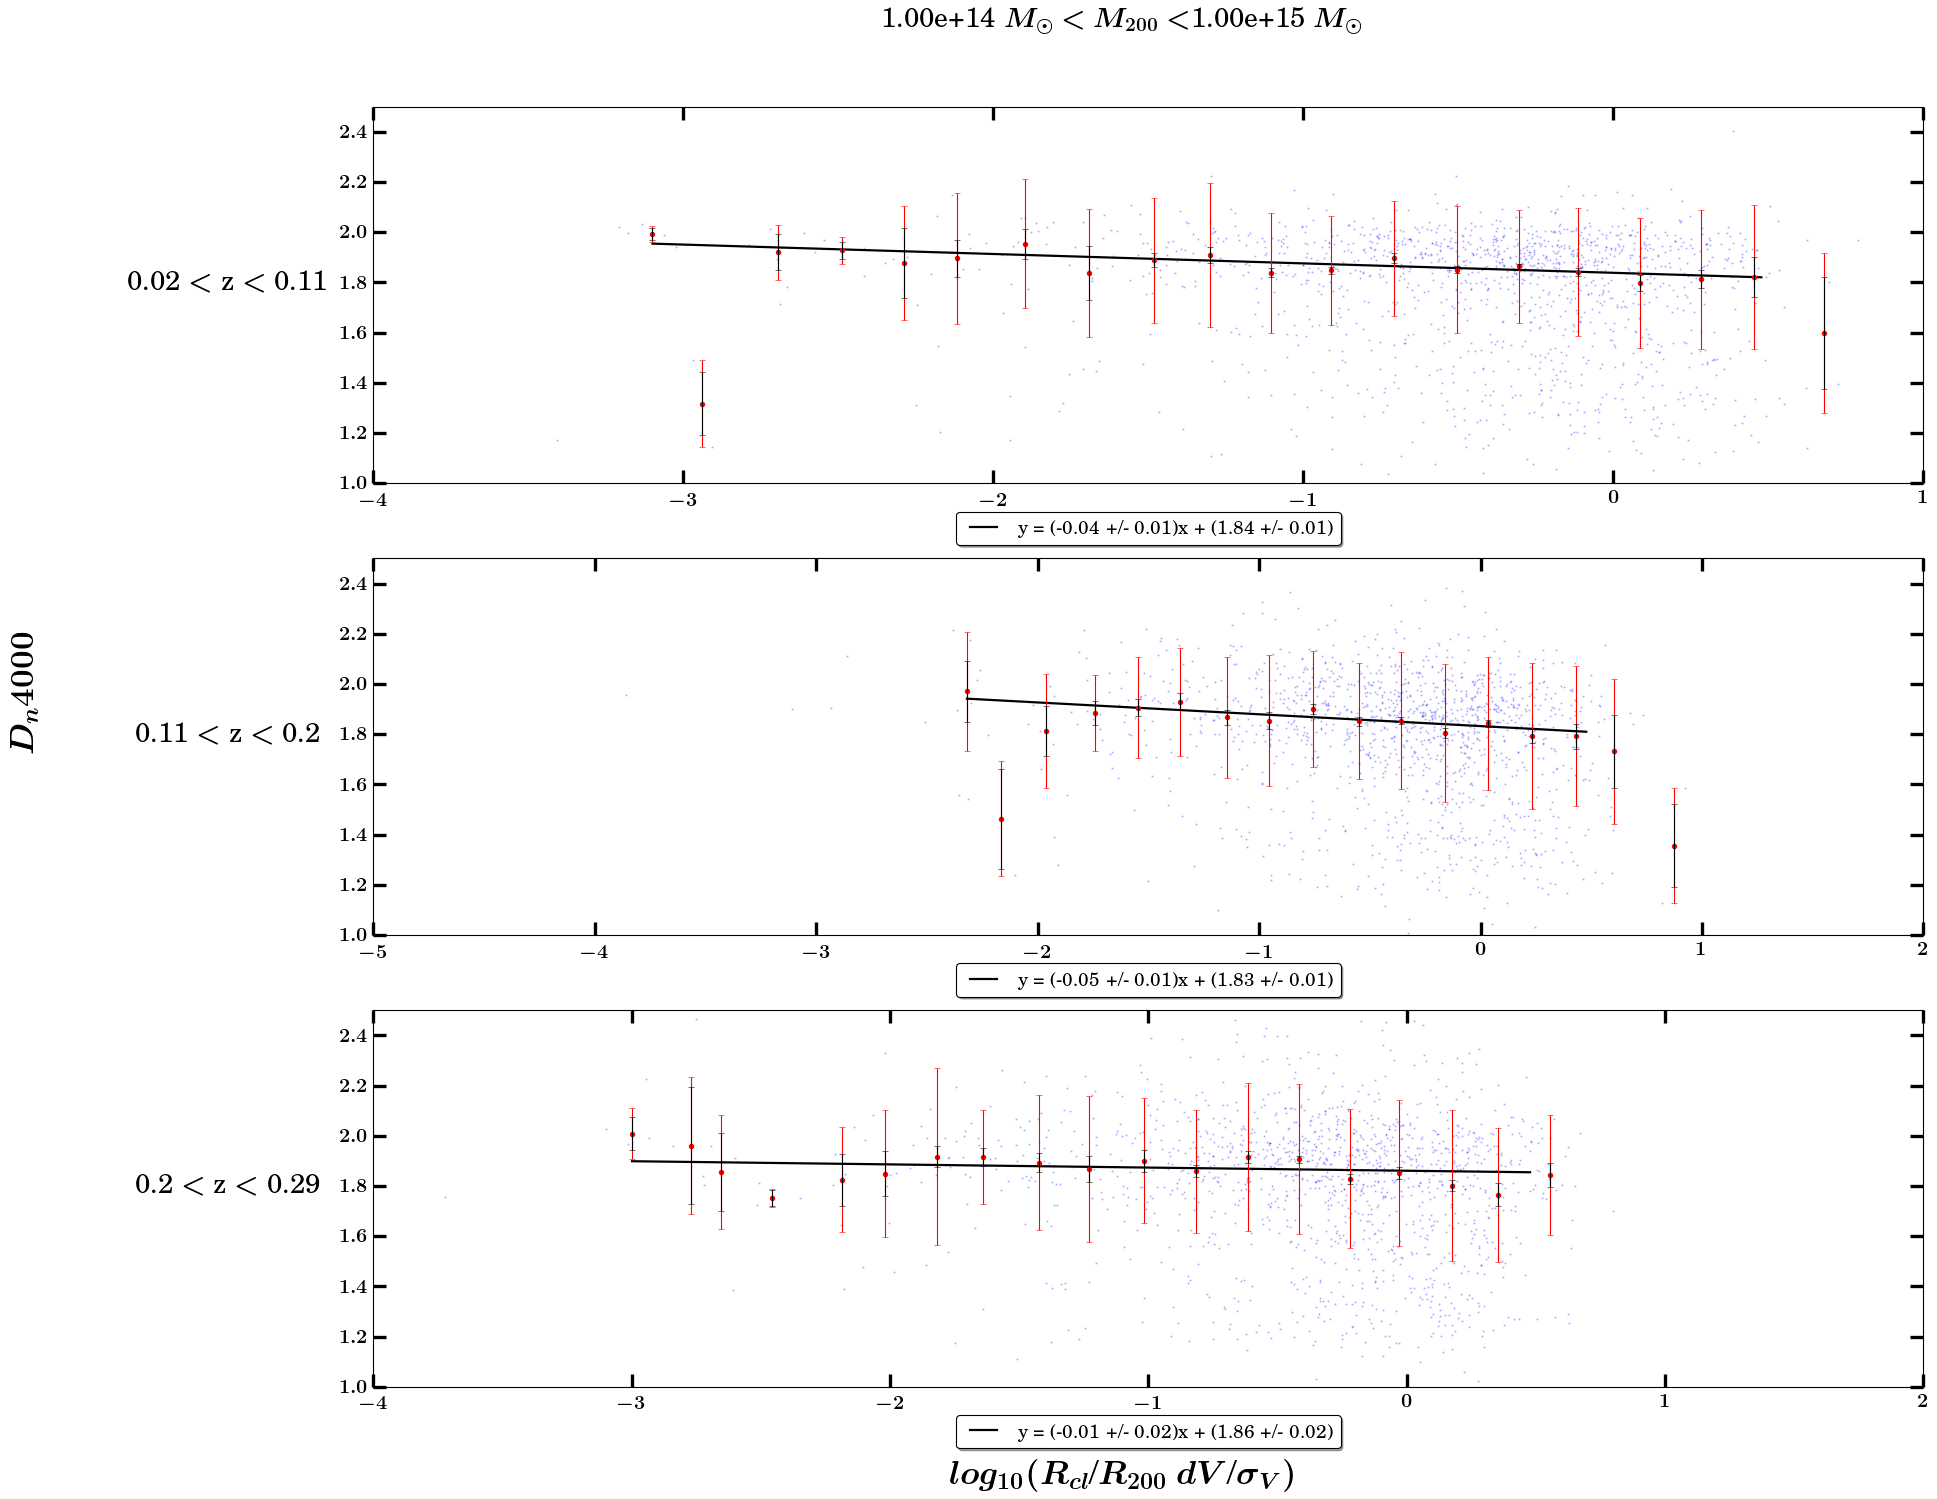

In [20]:
"""
*****************************************************************************
                              Dn4000 Trend Plots
                               Log Infall Time
*****************************************************************************
"""
slope, serr, intercept, ierr, dn4000RowName, dn4000ColName, dn4000PlotData = generateDn4000vsRnormPlots(plotDataDict, completnessDict, errorMethod = "std", xproj = 'LogInfallTime', dataIndex = 1)

fig, axs = plt.subplots(3, 1, figsize=(25,20))
for i, data in enumerate(dn4000PlotData):
    axs[i].scatter(dn4000PlotData[i][0][0], dn4000PlotData[i][0][1], s = 1, alpha=0.2, c='b', edgecolors='b')
    axs[i].scatter(dn4000PlotData[i][1][0], dn4000PlotData[i][1][1], s = 15, c='r',zorder=10, edgecolors='r')
    axs[i].errorbar(dn4000PlotData[i][1][0], dn4000PlotData[i][1][1], yerr=dn4000PlotData[i][1][3], alpha = 1, c='r', linestyle='none',zorder=10)
    axs[i].errorbar(dn4000PlotData[i][1][0], dn4000PlotData[i][1][1], yerr=dn4000PlotData[i][1][2], alpha = 1, c='black', linestyle='none',zorder=10)
    axs[i].plot(dn4000PlotData[i][2][0], dn4000PlotData[i][2][1], c='black', linewidth=2.0, label="y = ({slope:.2f} +/- {serr:.2f})x + ({intercept:.2f} +/- {ierr:.2f})".format(slope = slope[i][0], serr= serr[i][0], intercept = intercept[i][0], ierr = ierr[i][0]))
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, fontsize = 'x-small')
    axs[i].set_ylim((1, 2.5))

fig.patch.set_facecolor('xkcd:white') 
fig.text(0.5, 0.04, '$log_{10}($$R_{cl}$/$R_{200}$ $dV$/$\sigma_{V}$$)$', ha='center', size=30)
fig.text(-0.05, 0.5, '$D_{n}4000$', ha='center', size=30, rotation=90)
fig.text(0.5, 0.95, dn4000RowName[0], ha='center')
for ax, row in zip(axs, dn4000ColName):
    ax.set_ylabel(row, rotation=0, labelpad=100)
    
#fig.savefig("Dn4000LogInfall.pdf", bbox_inches='tight')
fig.show()

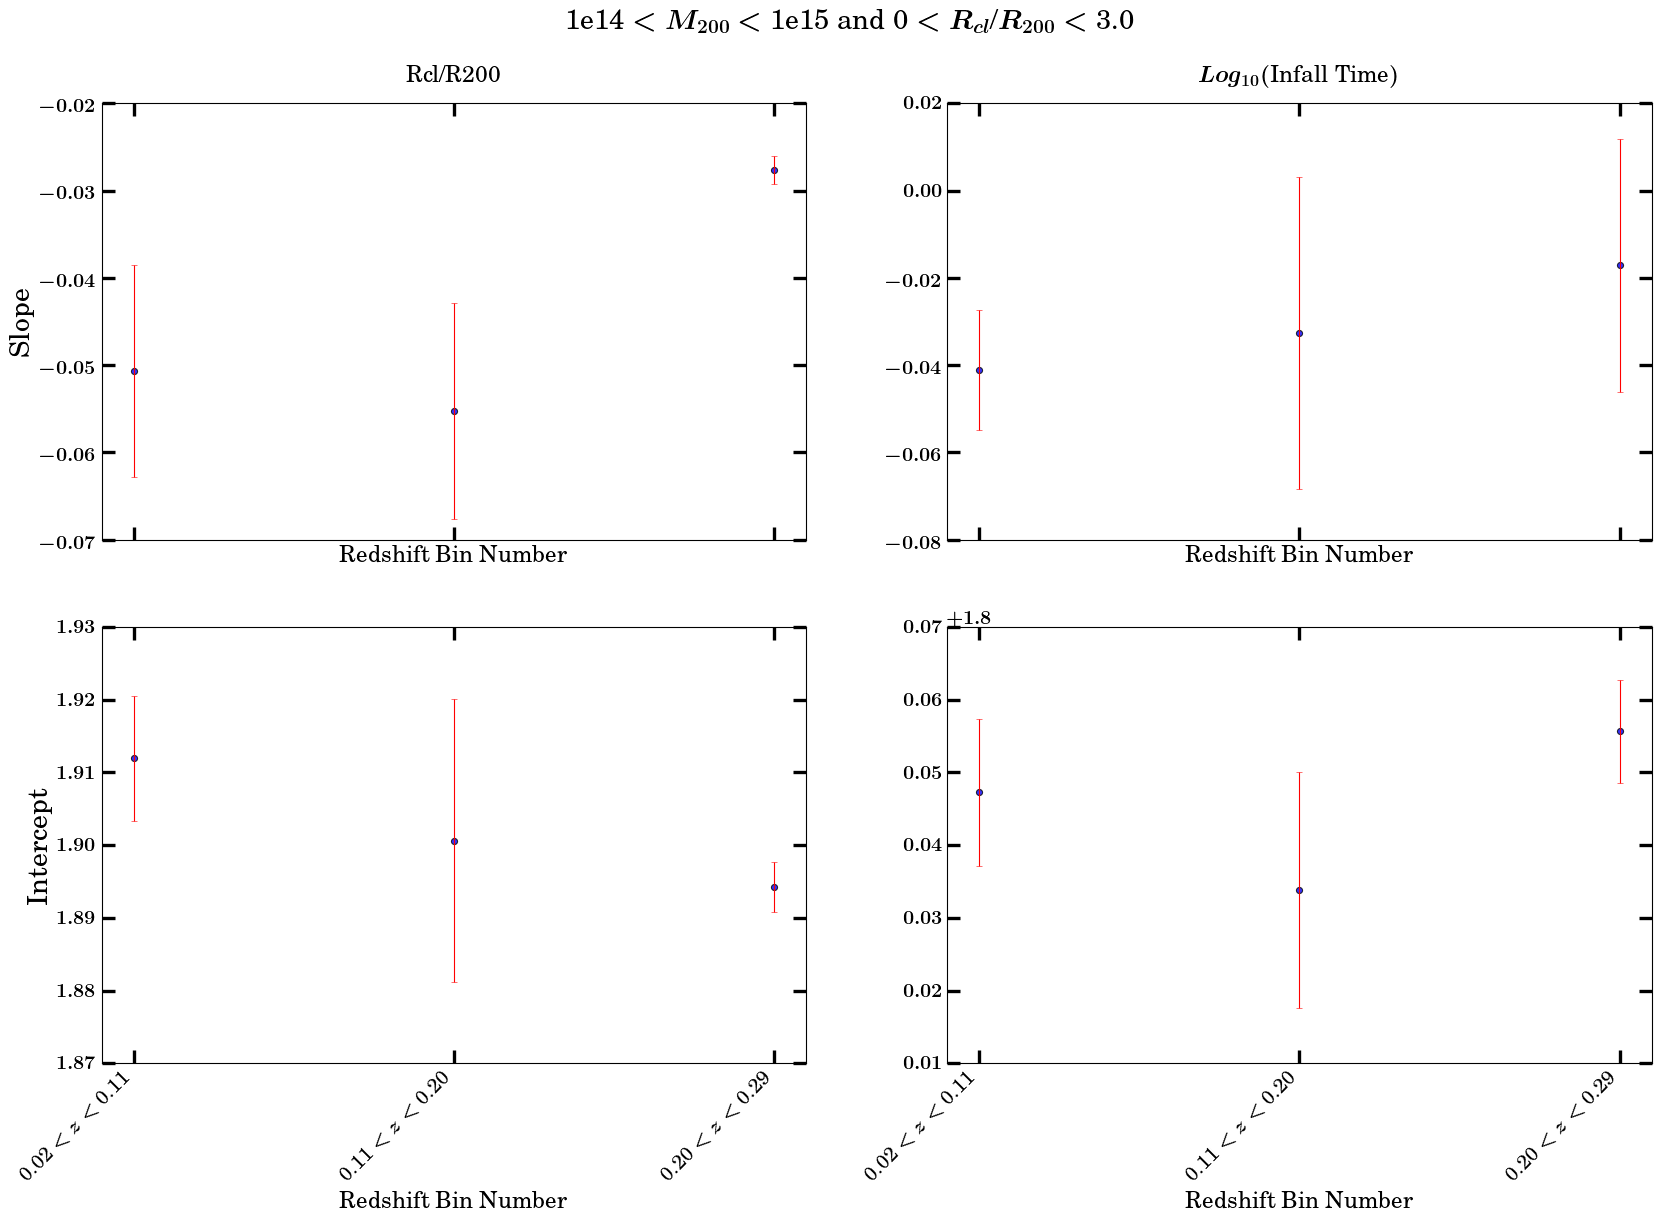

In [21]:
"""
*****************************************************************************
                              Simulation Summary Plots
*****************************************************************************
"""
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(25,15))

axs[0,0].scatter(np.array([i for i in range(3)]), np.array(slopes_newRnorm)[:,0], label=colName[0], alpha=0.8, c='blue', s=30)
axs[0,0].errorbar(np.array([i for i in range(3)]),np.array(slopes_newRnorm)[:,0], yerr=np.array(iqrsRnorm)[:,0], ls='none', c='r')


axs[0,0].set_title("Rcl/R200", pad=20, size='small')
axs[0,0].set_xticks(range(0,3))
axs[0,0].set_xticklabels(["0.02 $<$ $z$ $<$ 0.11", "0.11 $<$ $z$ $<$ 0.20", "0.20 $<$ $z$ $<$ 0.29"], rotation=45, ha='right')
axs[0,0].set_xlabel("Redshift Bin Number", size='small')
axs[0,0].set_ylabel("Slope")
#axs[0,0].legend(bbox_to_anchor=(-0.1, 1.05), fancybox=True, shadow=True, fontsize = 'x-small')


axs[0,1].scatter(np.array([i for i in range(3)]), np.array(slopes_newLogInfallTime)[:, 0], label=colName[0], alpha=0.8, c='blue', s=30)
axs[0,1].errorbar(np.array([i for i in range(3)]), np.array(slopes_newLogInfallTime)[:, 0], yerr=np.array(iqrsLogInfallTime)[:, 0], ls='none', c='r')

axs[0,1].set_title("$Log_{10}($Infall Time$)$", pad=20, size='small')
axs[0,1].set_xticks(range(0,3))
axs[0,1].set_xticklabels(["0.02 $<$ $z$ $<$ 0.11", "0.11 $<$ $z$ $<$ 0.20", "0.20 $<$ $z$ $<$ 0.29"], rotation=45, ha='right')
axs[0,1].set_xlabel("Redshift Bin Number", size='small')
#axs[0,1].set_ylabel("Slope")
#axs[0,1].legend(bbox_to_anchor=(-0.1, 1.05), fancybox=True, shadow=True, fontsize = 'x-small')



axs[1,0].scatter(np.array([i for i in range(3)]), np.array(intercepts_newRnorm)[:, 0], label=colName[0], alpha=0.8, c='blue', s=30)
axs[1,0].errorbar(np.array([i for i in range(3)]),np.array(intercepts_newRnorm)[:, 0], yerr=np.array(iqriRnorm)[:, 0], ls='none', c='r')


axs[1,0].set_xticks(range(0,3))
axs[1,0].set_xticklabels(["0.02 $<$ $z$ $<$ 0.11", "0.11 $<$ $z$ $<$ 0.20", "0.20 $<$ $z$ $<$ 0.29"], rotation=45, ha='right')
axs[1,0].set_xlabel("Redshift Bin Number", size='small')
axs[1,0].set_ylabel("Intercept")
#axs[1,0].legend(bbox_to_anchor=(-0.1, 1.05), fancybox=True, shadow=True, fontsize = 'x-small')



axs[1,1].scatter(np.array([i for i in range(3)]), np.array(intercepts_newLogInfallTime)[:, 0], label=colName[0], alpha=0.8, c='blue', s=30)
axs[1,1].errorbar(np.array([i for i in range(3)]), np.array(intercepts_newLogInfallTime)[:, 0], yerr=np.array(iqriLogInfallTime)[:, 0], ls='none', c='r')


axs[1,1].set_xticks(range(0,3))
axs[1,1].set_xticklabels(["0.02 $<$ $z$ $<$ 0.11", "0.11 $<$ $z$ $<$ 0.20", "0.20 $<$ $z$ $<$ 0.29"], rotation=45, ha='right')
axs[1,1].set_xlabel("Redshift Bin Number", size='small')
#axs[1,1].set_ylabel("Intercept")
#axs[1,1].legend(bbox_to_anchor=(-0.1, 1.05), fancybox=True, shadow=True, fontsize = 'x-small')

fig.suptitle("1e14 $<$ $M_{200}$ $<$ 1e15 and 0 $<$ $R_{cl}$/$R_{200}$ $<$ 3.0")
fig.patch.set_facecolor('xkcd:white') 
fig.savefig("simulation.pdf", bbox_inches='tight')

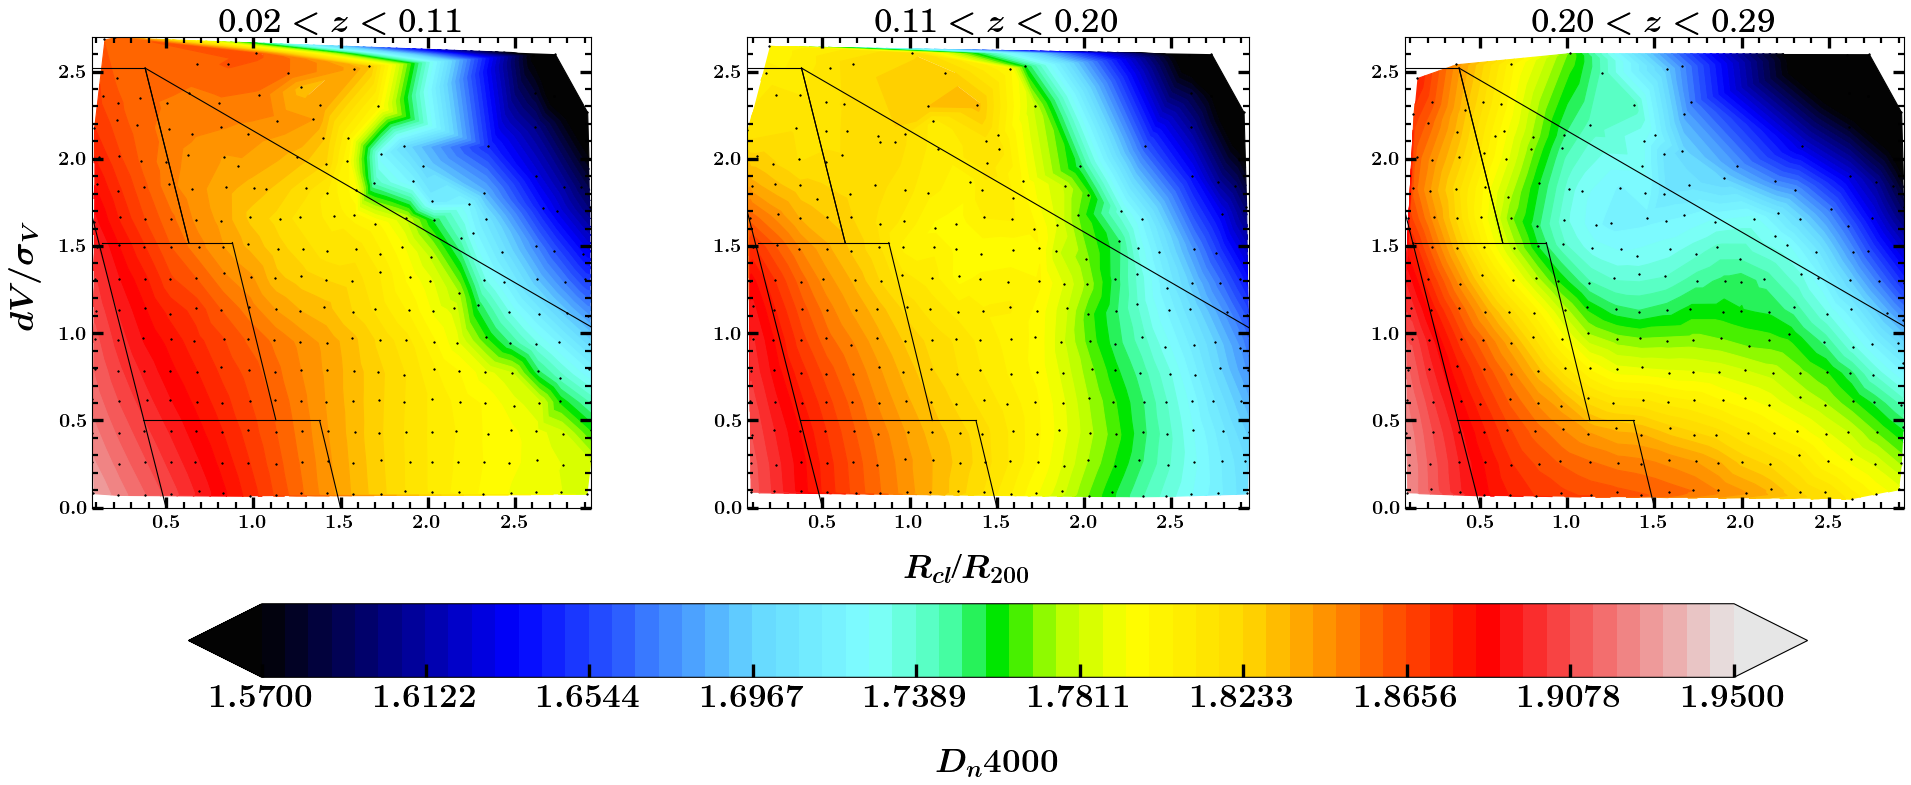

In [22]:
"""
*****************************************************************************
                              dV Plots
                        redshift with correction
*****************************************************************************
"""
dVplotData1 = generateRelativeVelocityPlots(plotDataDict, 0.0, 0.11, 1e14, 1e15, useCorrection = True, useMagLimit = True)
dVplotData2 = generateRelativeVelocityPlots(plotDataDict, 0.11, 0.20, 1e14, 1e15, useCorrection = True, useMagLimit = True)
dVplotData3 = generateRelativeVelocityPlots(plotDataDict, 0.20, 0.30, 1e14, 1e15, useCorrection = True, useMagLimit = True)

f = plt.figure(figsize=(30,10))

ax1 = f.add_subplot(131)
fig1 = plot_velfield(dVplotData1[0][0], dVplotData1[0][1], dVplotData1[0][2], vmin=1.57, vmax=1.95)
# Plots Regions
plt.plot([0.38, 0.63], [2.52, 1.52], c='black')
plt.plot([0.38, 0.63], [2.52, 1.52], c='black')
plt.plot([0.88, 1.13], [1.52, 0.50], c='black')
plt.plot([1.38, 1.50], [0.50, 0.0], c='black')
plt.plot([0.0, 0.38], [2.52, 2.52], c='black')
plt.plot([0.13, 0.88], [1.52, 1.52], c='black')
plt.plot([0.37, 1.38], [0.50, 0.50], c='black')
plt.plot([0.0, 0.50], [1.97, 0.0], c='black')
plt.plot([3.0, 0.38], [1.0, 2.52], c='black')
plt.title("0.02 $<$ $z$ $<$ 0.11")
plt.tick_params('y', labelbottom=False)

ax2 = f.add_subplot(132, sharey = ax1)
fig2 = plot_velfield(dVplotData2[0][0], dVplotData2[0][1], dVplotData2[0][2], vmin=1.57, vmax=1.95)
plt.plot([0.38, 0.63], [2.52, 1.52], c='black')
plt.plot([0.38, 0.63], [2.52, 1.52], c='black')
plt.plot([0.88, 1.13], [1.52, 0.50], c='black')
plt.plot([1.38, 1.50], [0.50, 0.0], c='black')
plt.plot([0.0, 0.38], [2.52, 2.52], c='black')
plt.plot([0.13, 0.88], [1.52, 1.52], c='black')
plt.plot([0.37, 1.38], [0.50, 0.50], c='black')
plt.plot([0.0, 0.50], [1.97, 0.0], c='black')
plt.plot([3.0, 0.38], [1.0, 2.52], c='black')
plt.title("0.11 $<$ $z$ $<$ 0.20")
plt.tick_params('y', labelbottom=False)

ax3 = f.add_subplot(133, sharey = ax1)
fig3 = plot_velfield(dVplotData3[0][0], dVplotData3[0][1], dVplotData3[0][2], vmin=1.57, vmax=1.95)
plt.plot([0.38, 0.63], [2.52, 1.52], c='black')
plt.plot([0.38, 0.63], [2.52, 1.52], c='black')
plt.plot([0.88, 1.13], [1.52, 0.50], c='black')
plt.plot([1.38, 1.50], [0.50, 0.0], c='black')
plt.plot([0.0, 0.38], [2.52, 2.52], c='black')
plt.plot([0.13, 0.88], [1.52, 1.52], c='black')
plt.plot([0.37, 1.38], [0.50, 0.50], c='black')
plt.plot([0.0, 0.50], [1.97, 0.0], c='black')
plt.plot([3.0, 0.38], [1.0, 2.52], c='black')
plt.title("0.20 $<$ $z$ $<$ 0.29")

plt.tick_params('y', labelbottom=False)
f.patch.set_facecolor('xkcd:white')
f.text(0.5, 0.225, r'$R_{cl}$/$R_{200}$', ha='center', size='large')
f.text(0.1, 0.6, r'$dV/\sigma_{V}$', va='center', size='large', rotation=90) 
cbar = f.colorbar(fig3, ax=(ax1, ax2, ax3), orientation='horizontal', fraction=0.115)
cbar.set_label(label="$D_{n}4000$", size='large', rotation=0, labelpad=30)  
cbar.ax.tick_params(labelsize=30)
cbar.draw_all()
plt.savefig("redshiftDVCorrection.pdf", bbox_inches='tight')

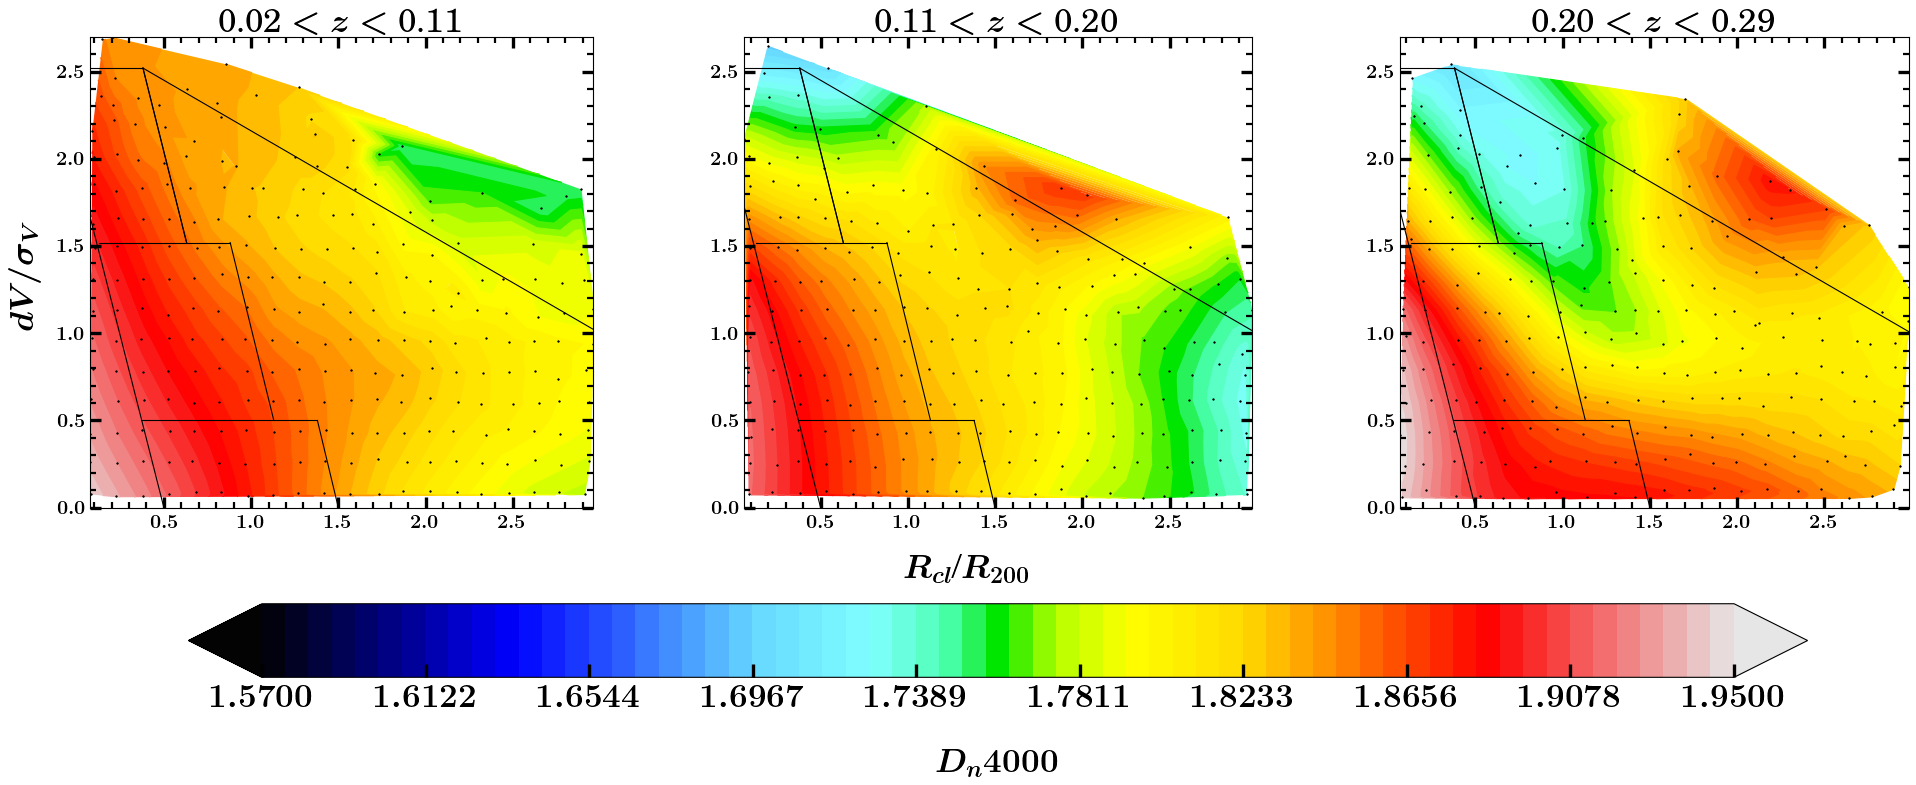

In [23]:
"""
*****************************************************************************
                              dV Plots
                        redshift without correction
*****************************************************************************
"""
# Gets data without correction
dVplotData1 = generateRelativeVelocityPlots(plotDataDict, 0.0, 0.11, 1e14, 1e15, useCorrection = False, useMagLimit = True)
dVplotData2 = generateRelativeVelocityPlots(plotDataDict, 0.11, 0.20, 1e14, 1e15, useCorrection = False, useMagLimit = True)
dVplotData3 = generateRelativeVelocityPlots(plotDataDict, 0.20, 0.30, 1e14, 1e15, useCorrection = False, useMagLimit = True)

f = plt.figure(figsize=(30,10))

ax1 = f.add_subplot(131)
fig1 = plot_velfield(dVplotData1[0][0], dVplotData1[0][1], dVplotData1[0][2], vmin=1.57, vmax=1.95)
# Plots Regions
plt.plot([0.38, 0.63], [2.52, 1.52], c='black')
plt.plot([0.38, 0.63], [2.52, 1.52], c='black')
plt.plot([0.88, 1.13], [1.52, 0.50], c='black')
plt.plot([1.38, 1.50], [0.50, 0.0], c='black')
plt.plot([0.0, 0.38], [2.52, 2.52], c='black')
plt.plot([0.13, 0.88], [1.52, 1.52], c='black')
plt.plot([0.37, 1.38], [0.50, 0.50], c='black')
plt.plot([0.0, 0.50], [1.97, 0.0], c='black')
plt.plot([3.0, 0.38], [1.0, 2.52], c='black')
plt.title("0.02 $<$ $z$ $<$ 0.11")
plt.tick_params('y', labelbottom=False)

ax2 = f.add_subplot(132, sharey = ax1)
fig2 = plot_velfield(dVplotData2[0][0], dVplotData2[0][1], dVplotData2[0][2], vmin=1.57, vmax=1.95)
plt.plot([0.38, 0.63], [2.52, 1.52], c='black')
plt.plot([0.38, 0.63], [2.52, 1.52], c='black')
plt.plot([0.88, 1.13], [1.52, 0.50], c='black')
plt.plot([1.38, 1.50], [0.50, 0.0], c='black')
plt.plot([0.0, 0.38], [2.52, 2.52], c='black')
plt.plot([0.13, 0.88], [1.52, 1.52], c='black')
plt.plot([0.37, 1.38], [0.50, 0.50], c='black')
plt.plot([0.0, 0.50], [1.97, 0.0], c='black')
plt.plot([3.0, 0.38], [1.0, 2.52], c='black')
plt.title("0.11 $<$ $z$ $<$ 0.20")
plt.tick_params('y', labelbottom=False)

ax3 = f.add_subplot(133, sharey = ax1)
fig3 = plot_velfield(dVplotData3[0][0], dVplotData3[0][1], dVplotData3[0][2], vmin=1.57, vmax=1.95)
plt.plot([0.38, 0.63], [2.52, 1.52], c='black')
plt.plot([0.38, 0.63], [2.52, 1.52], c='black')
plt.plot([0.88, 1.13], [1.52, 0.50], c='black')
plt.plot([1.38, 1.50], [0.50, 0.0], c='black')
plt.plot([0.0, 0.38], [2.52, 2.52], c='black')
plt.plot([0.13, 0.88], [1.52, 1.52], c='black')
plt.plot([0.37, 1.38], [0.50, 0.50], c='black')
plt.plot([0.0, 0.50], [1.97, 0.0], c='black')
plt.plot([3.0, 0.38], [1.0, 2.52], c='black')
plt.title("0.20 $<$ $z$ $<$ 0.29")

plt.tick_params('y', labelbottom=False)
f.patch.set_facecolor('xkcd:white')
f.text(0.5, 0.225, r'$R_{cl}$/$R_{200}$', ha='center', size='large')
f.text(0.1, 0.6, r'$dV/\sigma_{V}$', va='center', size='large', rotation=90) 
cbar = f.colorbar(fig3, ax=(ax1, ax2, ax3), orientation='horizontal', fraction=0.115)
cbar.set_label(label="$D_{n}4000$", size='large', rotation=0, labelpad=30)  
cbar.ax.tick_params(labelsize=30)
cbar.draw_all()
plt.savefig("redshiftDVNoCorrection.pdf", bbox_inches='tight')

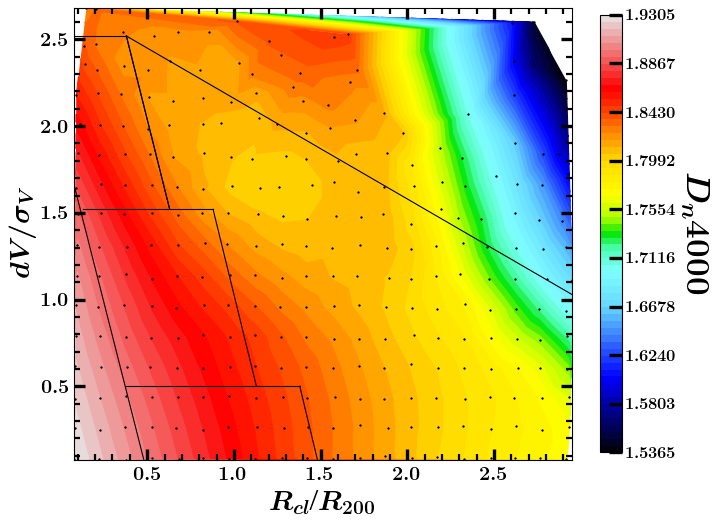

In [24]:
"""
*****************************************************************************
                              dV Plots
                        full smaple with correction
*****************************************************************************
"""
# Gets data full range data
dVplotData = generateRelativeVelocityPlots(plotDataDict, 0.0, 0.30, 1e13, 1e16, useCorrection = True, useMagLimit = True)
f = plt.figure(figsize=(30,10))
ax1 = f.add_subplot(131)
fig1 = plot_velfield(dVplotData[0][0], dVplotData[0][1], dVplotData[0][2])
# Plots Regions
plt.plot([0.38, 0.63], [2.52, 1.52], c='black')
plt.plot([0.38, 0.63], [2.52, 1.52], c='black')
plt.plot([0.88, 1.13], [1.52, 0.50], c='black')
plt.plot([1.38, 1.50], [0.50, 0.0], c='black')
plt.plot([0.0, 0.38], [2.52, 2.52], c='black')
plt.plot([0.13, 0.88], [1.52, 1.52], c='black')
plt.plot([0.37, 1.38], [0.50, 0.50], c='black')
plt.plot([0.0, 0.50], [1.97, 0.0], c='black')
plt.plot([3.0, 0.38], [1.0, 2.52], c='black')
plt.tick_params('y', labelbottom=False)

plt.tick_params('y', labelbottom=False)
f.patch.set_facecolor('xkcd:white')
plt.xlabel("$R_{cl}$/$R_{200}$")
plt.ylabel("$dV/\sigma_{V}$")
cbar = f.colorbar(fig1, fraction=0.04)
cbar.set_label(label="$D_{n}4000$", size='large', rotation=270, labelpad=30)  
cbar.ax.tick_params(labelsize=15)
cbar.draw_all()
plt.savefig("dVCorrection.pdf", bbox_inches='tight')

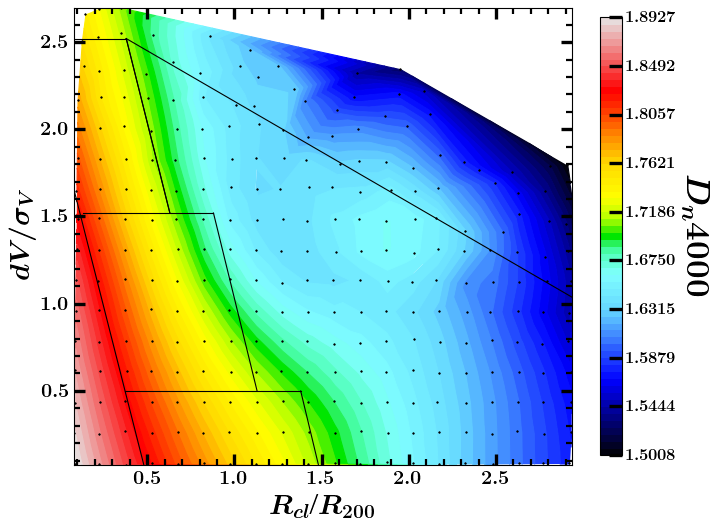

In [25]:
"""
*****************************************************************************
                              dV Plots
                full smaple without correction and mag limit
*****************************************************************************
"""
# Gets data full range data
dVplotData = generateRelativeVelocityPlots(plotDataDict, 0.0, 0.30, 1e13, 1e16, useCorrection = False, useMagLimit = False)
f = plt.figure(figsize=(30,10))
ax1 = f.add_subplot(131)
fig1 = plot_velfield(dVplotData[0][0], dVplotData[0][1], dVplotData[0][2])
# Plots Regions
plt.plot([0.38, 0.63], [2.52, 1.52], c='black')
plt.plot([0.38, 0.63], [2.52, 1.52], c='black')
plt.plot([0.88, 1.13], [1.52, 0.50], c='black')
plt.plot([1.38, 1.50], [0.50, 0.0], c='black')
plt.plot([0.0, 0.38], [2.52, 2.52], c='black')
plt.plot([0.13, 0.88], [1.52, 1.52], c='black')
plt.plot([0.37, 1.38], [0.50, 0.50], c='black')
plt.plot([0.0, 0.50], [1.97, 0.0], c='black')
plt.plot([3.0, 0.38], [1.0, 2.52], c='black')
plt.tick_params('y', labelbottom=False)

plt.tick_params('y', labelbottom=False)
f.patch.set_facecolor('xkcd:white')
plt.xlabel("$R_{cl}$/$R_{200}$")
plt.ylabel("$dV/\sigma_{V}$")
cbar = f.colorbar(fig1, fraction=0.04)
cbar.set_label(label="$D_{n}4000$", size='large', rotation=270, labelpad=30)  
cbar.ax.tick_params(labelsize=15)
cbar.draw_all()
plt.savefig("dVNoCorrectionAndMagLimit.pdf", bbox_inches='tight')